# ROI 2000

In [1]:
import numpy as np
import os
#import ipdb

def connect_dataset(file_list, icond_file_list, outputdir,
                    topodx=15, roi=2500, offset=5000,gclass_num=6,test_data_num=500):
    """
    複数のデータセットを連結する
    """
    #ipdb.set_trace()
    
    #Reading and combining files Decide start and end points of the learning area and convert them to grid numbers
    H = np.loadtxt(file_list[0], delimiter = ',')
    icond = np.loadtxt(icond_file_list[0], delimiter = ',')
    
    #Reading and combining files
    if len(file_list) > 1:
        for i in range(1, len(file_list)):
            H_temp = np.loadtxt(file_list[i], delimiter = ',')
            icond_temp = np.loadtxt(icond_file_list[i], delimiter = ',')
            H = np.concatenate((H,H_temp),axis=0)
            icond = np.concatenate((icond,icond_temp),axis = 0)
    
    roi_grids = int(roi / topodx)
    num_grids = int(H.shape[1] / gclass_num)
    H_subset = np.zeros([H.shape[0], roi_grids * gclass_num])
    for i in range(gclass_num):
        H_subset[:, i*roi_grids:(i+1)*roi_grids] = H[:, i*num_grids:(i*num_grids+roi_grids)]
    
    #Obtain the maximum and minimum values of data
    max_x = np.max(H_subset)
    min_x = np.min(H_subset)
    icond_max = np.max(icond, axis=0)
    icond_min = np.min(icond, axis=0)
    
    #Split the data into tests and training
    H_train = H_subset[0:-test_data_num,:]
    H_test = H_subset[H_subset.shape[0] - test_data_num:,:]
    icond_train = icond[0:-test_data_num,:]
    icond_test = icond[H.shape[0] - test_data_num:,:]
    
    #Save the data
    if not os.path.exists(outputdir):
        os.mkdir(outputdir)
    np.savetxt(outputdir + '/x_train.txt',H_train,delimiter = ',')
    np.savetxt(outputdir + '/x_test.txt',H_test,delimiter = ',')
    np.savetxt(outputdir + '/icond_train.txt',icond_train,delimiter = ',')
    np.savetxt(outputdir + '/icond_test.txt',icond_test,delimiter = ',')
    np.savetxt(outputdir + '/icond_min.txt',icond_min,delimiter = ',')
    np.savetxt(outputdir + '/icond_max.txt',icond_max,delimiter = ',')
    np.savetxt(outputdir + '/x_minmax.txt',[min_x, max_x],delimiter = ',')
    
    
if __name__=="__main__":
    original_data_dir = "/home/rimali2009/FITTNUSS-forward_training_DNN"
    parent_dir = "/home/rimali2009/FITTNUSS-forward_training_DNN"
    if not os.path.exists(parent_dir):
        os.mkdir(parent_dir)
    outputdir = parent_dir + "/data_g6_300grid_H_5000_20_11_roi2000_TC"
    file_list = ['/home/rimali2009/FITTNUSS-forward_training_DNN/eta_5000_g6_300grid_19_11.csv']
    initial_conditions = ['/home/rimali2009/FITTNUSS-forward_training_DNN/start_param_random_5000_g6_300grid_19_11.csv']
connect_dataset(file_list, initial_conditions, outputdir, test_data_num=500, gclass_num=6, topodx=15., roi=2000)
        
        
    

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar  7 15:43:18 2017

@author: hanar
"""
import time
import numpy as np
import os
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.models import load_model
#from keras.utils.visualize_util import plot
import matplotlib.pyplot as plt
import keras.callbacks
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf

#Global variables for normalizing parameters
max_x = 1.0
min_x = 0.0
max_y = 1.0
min_y = 0.0


def deep_learning_tsunami(resdir, X_train_raw, y_train_raw, X_test_raw, y_test_raw,
                            _lr=0.02, _decay=0,
                            _validation_split=0.2, _batch_size=32,
                            _momentum=0.9, _nesterov=True,
                            num_layers=4, dropout=0.5,
                            node_num = 2500,
                            _epochs=2000):
    """
    Creating the inversion model of turbidity currents by deep learning
    """
    #Normalizing dataset
    X_train = get_normalized_data(X_train_raw, min_x, max_x)
    X_test = get_normalized_data(X_test_raw, min_x, max_x)
    y_train = get_normalized_data(y_train_raw, min_y, max_y)
    y_test = get_normalized_data(y_test_raw, min_y, max_y)
    
    #Generation of neural network model
    model = Sequential()
    model.add(Dense(node_num, input_dim=X_train.shape[1], activation='relu', kernel_initializer ='glorot_uniform'))#1st layer
    model.add(Dropout(dropout))
    for i in range(num_layers - 2):
        model.add(Dense(node_num, activation='relu', kernel_initializer ='glorot_uniform'))#2nd layer
        model.add(Dropout(dropout))
    model.add(Dense(y_train.shape[1], activation = 'relu', kernel_initializer ='glorot_uniform')) #last layer
    
    #Compiling the model
    model.compile(loss="mean_squared_error", 
              optimizer=SGD(lr=_lr, decay=_decay, momentum=_momentum, nesterov=_nesterov),
              #optimizer=Adadelta(),
              metrics=["mean_squared_error"])    
    
    #Perform learning
    t = time.time()
    check = ModelCheckpoint("model3.hdf5")
    #es_cb = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    #tb_cb = TensorBoard(log_dir=resdir, histogram_freq=2, write_graph=True, write_images=True)
    history = model.fit(X_train, y_train, epochs=_epochs, 
                    validation_split=_validation_split, batch_size=_batch_size,
                    callbacks=[check])
    
    #Evaluate learning result
    loss_and_metrics = model.evaluate(X_test,y_test)
    print("\nloss:{} mse:{}".format(loss_and_metrics[0],loss_and_metrics[1]))
    
    print("Elapsed time: {:.1f} sec.".format(time.time()-t))
    
    #Visualize learning result   
    #plot(model, to_file="model.png", show_shapes=True, show_layer_names=True)

    # model The state of change when letting you learnplot
    plot_history(history)
    
    return model, history

def apply_model(model, X, min_x, max_x, min_y, max_y):
    """
    Apply model
    Maximum and minimum values ​​of X and Y are required to normalize
    """
    X_norm =  (X - min_x) / (max_x - min_x)
    Y_norm = model.predict(X_norm)
    Y = Y_norm*(max_y - min_y)+min_y
    return Y

def plot_history(history):
    # Plot accuracy history
    plt.plot(history.history['mean_squared_error'],"o-",label="mse")
    plt.plot(history.history['val_mean_squared_error'],"o-",label="val mse")
    plt.title('model mse')
    plt.xlabel('epoch')
    plt.ylabel('mse')
    plt.legend(loc="upper right")
    plt.show()

#    # 損失の履歴をプロット
#    plt.plot(history.history['loss'],"o-",label="loss",)
#    plt.plot(history.history['val_loss'],"o-",label="val_loss")
#    plt.title('model loss')
#    plt.xlabel('epoch')
#    plt.ylabel('loss')
#    plt.legend(loc='upper right')
#    plt.show()

def test_model(model, x_test):
    #Test the results
    
    x_test_norm = get_normalized_data(x_test, min_x, max_x)
    test_result_norm = model.predict(x_test_norm)
    test_result = get_raw_data(test_result_norm, min_y, max_y)
    
    return test_result


def save_result(savedir, model, history, test_result):
    
    
    np.savetxt(savedir + 'test_result.txt',test_result,delimiter=',')
    np.savetxt(savedir+'loss.txt',history.history.get('loss'),delimiter=',')
    np.savetxt(savedir+'val_loss.txt',history.history.get('val_loss'),delimiter=',')
    
    #Serialize model and save
    print('save the model')
    model.save(savedir + 'model3.hdf5')

def load_data(datadir):
    """
    This function load training and test data sets, and returns variables
    """
    global min_x, max_x, min_y, max_y
    
    x_train = np.loadtxt(datadir + 'x_train.txt',delimiter=',')
    x_test = np.loadtxt(datadir + 'x_test.txt',delimiter=',')
    y_train = np.loadtxt(datadir + 'icond_train.txt',delimiter=',')
    y_test = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')
    min_y = np.loadtxt(datadir + 'icond_min.txt',delimiter=',')
    max_y = np.loadtxt(datadir + 'icond_max.txt',delimiter=',')
    [min_x, max_x] = np.loadtxt(datadir + 'x_minmax.txt',delimiter=',')
    
    return x_train, y_train, x_test, y_test

def set_minmax_data(_min_x, _max_x, _min_y, _max_y):
    global min_x, max_x, min_y, max_y
    
    min_x, max_x, min_y, max_y = _min_x, _max_x, _min_y, _max_y
    return
    


def get_normalized_data(x, min_val, max_val):
    """
    Normalizing the training and test dataset
    """
    x_norm = (x - min_val) / (max_val - min_val)
    
    return x_norm

def get_raw_data(x_norm, min_val, max_val):
    """
    Get raw data from the normalized dataset
    """
    x = x_norm * (max_val - min_val) + min_val
    
    return x

if __name__ == "__main__":
    
    #Reading data  
    datadir = '/home/rimali2009/FITTNUSS-forward_training_DNN/data_g6_300grid_H_5000_20_11_roi2000_TC/'
    resdir = '/home/rimali2009/FITTNUSS-forward_training_DNN/result_g6_300grid_H_5000_20_11_roi2000_TC/'
    if not os.path.exists(resdir):
        os.mkdir(resdir)
    
    x_train, y_train, x_test, y_test = load_data(datadir)
    
     
    #Execution of learning
    testcases = [500,1500,2500,3500,4500]
    for i in range(len(testcases)):
        resdir_case = resdir + '{}/'.format(testcases[i])        
        if not os.path.exists(resdir_case):
            os.mkdir(resdir_case)
        x_train_sub = x_train[0:testcases[i],:]
        y_train_sub = y_train[0:testcases[i],:]
        model, history = deep_learning_tsunami(resdir_case, x_train_sub, y_train_sub, x_test, y_test, num_layers=5)
        #Verify and save results
        result = test_model(model, x_test)
        save_result(resdir_case,model,history,result)




Using TensorFlow backend.


Train on 400 samples, validate on 100 samples
Epoch 1/2000
400/400 [==============================] - 1s 3ms/step - loss: 0.2221 - mean_squared_error: 0.2221 - val_loss: 0.1107 - val_mean_squared_error: 0.1107
Epoch 2/2000
400/400 [==============================] - 0s 367us/step - loss: 0.1072 - mean_squared_error: 0.1072 - val_loss: 0.0912 - val_mean_squared_error: 0.0912
Epoch 3/2000
400/400 [==============================] - 0s 363us/step - loss: 0.0862 - mean_squared_error: 0.0862 - val_loss: 0.0871 - val_mean_squared_error: 0.0871
Epoch 4/2000
400/400 [==============================] - 0s 367us/step - loss: 0.0800 - mean_squared_error: 0.0800 - val_loss: 0.0809 - val_mean_squared_error: 0.0809
Epoch 5/2000
400/400 [==============================] - 0s 366us/step - loss: 0.0770 - mean_squared_error: 0.0770 - val_loss: 0.0795 - val_mean_squared_error: 0.0795
Epoch 6/2000
400/400 [==============================] - 0s 363us/step - loss: 0.0750 - mean_squared_error: 0.0750 - val_loss: 

Epoch 50/2000
400/400 [==============================] - 0s 360us/step - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0381 - val_mean_squared_error: 0.0381
Epoch 51/2000
400/400 [==============================] - 0s 364us/step - loss: 0.0376 - mean_squared_error: 0.0376 - val_loss: 0.0376 - val_mean_squared_error: 0.0376
Epoch 52/2000
400/400 [==============================] - 0s 361us/step - loss: 0.0359 - mean_squared_error: 0.0359 - val_loss: 0.0369 - val_mean_squared_error: 0.0369
Epoch 53/2000
400/400 [==============================] - 0s 358us/step - loss: 0.0363 - mean_squared_error: 0.0363 - val_loss: 0.0371 - val_mean_squared_error: 0.0371
Epoch 54/2000
400/400 [==============================] - 0s 360us/step - loss: 0.0356 - mean_squared_error: 0.0356 - val_loss: 0.0361 - val_mean_squared_error: 0.0361
Epoch 55/2000
400/400 [==============================] - 0s 360us/step - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0362 - val_mean_squared_error: 0.036

400/400 [==============================] - 0s 364us/step - loss: 0.0249 - mean_squared_error: 0.0249 - val_loss: 0.0280 - val_mean_squared_error: 0.0280
Epoch 100/2000
400/400 [==============================] - 0s 362us/step - loss: 0.0250 - mean_squared_error: 0.0250 - val_loss: 0.0283 - val_mean_squared_error: 0.0283
Epoch 101/2000
400/400 [==============================] - 0s 359us/step - loss: 0.0251 - mean_squared_error: 0.0251 - val_loss: 0.0281 - val_mean_squared_error: 0.0281
Epoch 102/2000
400/400 [==============================] - 0s 357us/step - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.0278 - val_mean_squared_error: 0.0278
Epoch 103/2000
400/400 [==============================] - 0s 361us/step - loss: 0.0240 - mean_squared_error: 0.0240 - val_loss: 0.0280 - val_mean_squared_error: 0.0280
Epoch 104/2000
400/400 [==============================] - 0s 350us/step - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.0273 - val_mean_squared_error: 0.0273
Epoch 1

Epoch 148/2000
400/400 [==============================] - 0s 362us/step - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0233 - val_mean_squared_error: 0.0233
Epoch 149/2000
400/400 [==============================] - 0s 351us/step - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.0226 - val_mean_squared_error: 0.0226
Epoch 150/2000
400/400 [==============================] - 0s 357us/step - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0230 - val_mean_squared_error: 0.0230
Epoch 151/2000
400/400 [==============================] - 0s 350us/step - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
Epoch 152/2000
400/400 [==============================] - 0s 373us/step - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0230 - val_mean_squared_error: 0.0230
Epoch 153/2000
400/400 [==============================] - 0s 359us/step - loss: 0.0200 - mean_squared_error: 0.0200 - val_loss: 0.0220 - val_mean_squared_error:

Epoch 197/2000
400/400 [==============================] - 0s 352us/step - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 198/2000
400/400 [==============================] - 0s 352us/step - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 199/2000
400/400 [==============================] - 0s 472us/step - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 200/2000
400/400 [==============================] - 0s 385us/step - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Epoch 201/2000
400/400 [==============================] - 0s 360us/step - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 202/2000
400/400 [==============================] - 0s 356us/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0201 - val_mean_squared_error:

Epoch 246/2000
400/400 [==============================] - 0s 350us/step - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0.0192 - val_mean_squared_error: 0.0192
Epoch 247/2000
400/400 [==============================] - 0s 365us/step - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0192 - val_mean_squared_error: 0.0192
Epoch 248/2000
400/400 [==============================] - 0s 358us/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0190 - val_mean_squared_error: 0.0190
Epoch 249/2000
400/400 [==============================] - 0s 391us/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0192 - val_mean_squared_error: 0.0192
Epoch 250/2000
400/400 [==============================] - 0s 357us/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0186 - val_mean_squared_error: 0.0186
Epoch 251/2000
400/400 [==============================] - 0s 359us/step - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.0192 - val_mean_squared_error:

Epoch 295/2000
400/400 [==============================] - 0s 360us/step - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.0178 - val_mean_squared_error: 0.0178
Epoch 296/2000
400/400 [==============================] - 0s 360us/step - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0185 - val_mean_squared_error: 0.0185
Epoch 297/2000
400/400 [==============================] - 0s 353us/step - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.0176 - val_mean_squared_error: 0.0176
Epoch 298/2000
400/400 [==============================] - 0s 352us/step - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.0181 - val_mean_squared_error: 0.0181
Epoch 299/2000
400/400 [==============================] - 0s 353us/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0178 - val_mean_squared_error: 0.0178
Epoch 300/2000
400/400 [==============================] - 0s 357us/step - loss: 0.0145 - mean_squared_error: 0.0145 - val_loss: 0.0181 - val_mean_squared_error:

Epoch 344/2000
400/400 [==============================] - 0s 356us/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0177 - val_mean_squared_error: 0.0177
Epoch 345/2000
400/400 [==============================] - 0s 358us/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0176 - val_mean_squared_error: 0.0176
Epoch 346/2000
400/400 [==============================] - 0s 362us/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0172 - val_mean_squared_error: 0.0172
Epoch 347/2000
400/400 [==============================] - 0s 378us/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 348/2000
400/400 [==============================] - 0s 357us/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0168 - val_mean_squared_error: 0.0168
Epoch 349/2000
400/400 [==============================] - 0s 363us/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0171 - val_mean_squared_error:

Epoch 393/2000
400/400 [==============================] - 0s 359us/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0169 - val_mean_squared_error: 0.0169
Epoch 394/2000
400/400 [==============================] - 0s 358us/step - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.0164 - val_mean_squared_error: 0.0164
Epoch 395/2000
400/400 [==============================] - 0s 357us/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0164 - val_mean_squared_error: 0.0164
Epoch 396/2000
400/400 [==============================] - 0s 376us/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0166 - val_mean_squared_error: 0.0166
Epoch 397/2000
400/400 [==============================] - 0s 361us/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 398/2000
400/400 [==============================] - 0s 361us/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0164 - val_mean_squared_error:

Epoch 442/2000
400/400 [==============================] - 0s 369us/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0160 - val_mean_squared_error: 0.0160
Epoch 443/2000
400/400 [==============================] - 0s 357us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0155 - val_mean_squared_error: 0.0155
Epoch 444/2000
400/400 [==============================] - 0s 377us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0162 - val_mean_squared_error: 0.0162
Epoch 445/2000
400/400 [==============================] - 0s 353us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0156 - val_mean_squared_error: 0.0156
Epoch 446/2000
400/400 [==============================] - 0s 351us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0157 - val_mean_squared_error: 0.0157
Epoch 447/2000
400/400 [==============================] - 0s 364us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0153 - val_mean_squared_error:

Epoch 491/2000
400/400 [==============================] - 0s 362us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 492/2000
400/400 [==============================] - 0s 357us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 493/2000
400/400 [==============================] - 0s 352us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 494/2000
400/400 [==============================] - 0s 359us/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 495/2000
400/400 [==============================] - 0s 374us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 496/2000
400/400 [==============================] - 0s 348us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0152 - val_mean_squared_error:

Epoch 540/2000
400/400 [==============================] - 0s 351us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0153 - val_mean_squared_error: 0.0153
Epoch 541/2000
400/400 [==============================] - 0s 351us/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 542/2000
400/400 [==============================] - 0s 349us/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 543/2000
400/400 [==============================] - 0s 355us/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 544/2000
400/400 [==============================] - 0s 350us/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 545/2000
400/400 [==============================] - 0s 353us/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0144 - val_mean_squared_error:

Epoch 589/2000
400/400 [==============================] - 0s 362us/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 590/2000
400/400 [==============================] - 0s 356us/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 591/2000
400/400 [==============================] - 0s 371us/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 592/2000
400/400 [==============================] - 0s 352us/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 593/2000
400/400 [==============================] - 0s 375us/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 594/2000
400/400 [==============================] - 0s 356us/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0137 - val_mean_squared_error:

Epoch 638/2000
400/400 [==============================] - 0s 367us/step - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 639/2000
400/400 [==============================] - 0s 350us/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 640/2000
400/400 [==============================] - 0s 350us/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 641/2000
400/400 [==============================] - 0s 358us/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 642/2000
400/400 [==============================] - 0s 360us/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 643/2000
400/400 [==============================] - 0s 348us/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0134 - val_mean_squared_error:

Epoch 687/2000
400/400 [==============================] - 0s 361us/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 688/2000
400/400 [==============================] - 0s 354us/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 689/2000
400/400 [==============================] - 0s 369us/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 690/2000
400/400 [==============================] - 0s 368us/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 691/2000
400/400 [==============================] - 0s 357us/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 692/2000
400/400 [==============================] - 0s 469us/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0132 - val_mean_squared_error:

Epoch 736/2000
400/400 [==============================] - 0s 349us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 737/2000
400/400 [==============================] - 0s 375us/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 738/2000
400/400 [==============================] - 0s 369us/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 739/2000
400/400 [==============================] - 0s 360us/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 740/2000
400/400 [==============================] - 0s 359us/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 741/2000
400/400 [==============================] - 0s 357us/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0127 - val_mean_squared_error:

Epoch 785/2000
400/400 [==============================] - 0s 355us/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 786/2000
400/400 [==============================] - 0s 352us/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 787/2000
400/400 [==============================] - 0s 350us/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 788/2000
400/400 [==============================] - 0s 365us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 789/2000
400/400 [==============================] - 0s 361us/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 790/2000
400/400 [==============================] - 0s 364us/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0121 - val_mean_squared_error:

Epoch 834/2000
400/400 [==============================] - 0s 357us/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 835/2000
400/400 [==============================] - 0s 349us/step - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 836/2000
400/400 [==============================] - 0s 358us/step - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 837/2000
400/400 [==============================] - 0s 363us/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 838/2000
400/400 [==============================] - 0s 353us/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 839/2000
400/400 [==============================] - 0s 351us/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0115 - val_mean_squared_error:

Epoch 883/2000
400/400 [==============================] - 0s 358us/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 884/2000
400/400 [==============================] - 0s 365us/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 885/2000
400/400 [==============================] - 0s 350us/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 886/2000
400/400 [==============================] - 0s 361us/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 887/2000
400/400 [==============================] - 0s 363us/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 888/2000
400/400 [==============================] - 0s 349us/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0110 - val_mean_squared_error:

Epoch 932/2000
400/400 [==============================] - 0s 357us/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 933/2000
400/400 [==============================] - 0s 365us/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 934/2000
400/400 [==============================] - 0s 494us/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 935/2000
400/400 [==============================] - 0s 367us/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 936/2000
400/400 [==============================] - 0s 364us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 937/2000
400/400 [==============================] - 0s 350us/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0115 - val_mean_squared_error:

Epoch 981/2000
400/400 [==============================] - 0s 352us/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 982/2000
400/400 [==============================] - 0s 354us/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 983/2000
400/400 [==============================] - 0s 352us/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 984/2000
400/400 [==============================] - 0s 354us/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 985/2000
400/400 [==============================] - 0s 366us/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 986/2000
400/400 [==============================] - 0s 476us/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0105 - val_mean_squared_error:

400/400 [==============================] - 0s 351us/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 1078/2000
400/400 [==============================] - 0s 349us/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 1079/2000
400/400 [==============================] - 0s 355us/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 1080/2000
400/400 [==============================] - 0s 352us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 1081/2000
400/400 [==============================] - 0s 361us/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 1082/2000
400/400 [==============================] - 0s 352us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Ep

400/400 [==============================] - 0s 366us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 1174/2000
400/400 [==============================] - 0s 363us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 1175/2000
400/400 [==============================] - 0s 356us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 1176/2000
400/400 [==============================] - 0s 359us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 1177/2000
400/400 [==============================] - 0s 373us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 1178/2000
400/400 [==============================] - 0s 352us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Ep

400/400 [==============================] - 0s 352us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 1270/2000
400/400 [==============================] - 0s 351us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 1271/2000
400/400 [==============================] - 0s 351us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 1272/2000
400/400 [==============================] - 0s 356us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 1273/2000
400/400 [==============================] - 0s 352us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 1274/2000
400/400 [==============================] - 0s 411us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Ep

400/400 [==============================] - 0s 356us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 1366/2000
400/400 [==============================] - 0s 364us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 1367/2000
400/400 [==============================] - 0s 359us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 1368/2000
400/400 [==============================] - 0s 354us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 1369/2000
400/400 [==============================] - 0s 356us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 1370/2000
400/400 [==============================] - 0s 350us/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Ep

400/400 [==============================] - 0s 367us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 1462/2000
400/400 [==============================] - 0s 352us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 1463/2000
400/400 [==============================] - 0s 359us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 1464/2000
400/400 [==============================] - 0s 359us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 1465/2000
400/400 [==============================] - 0s 358us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 1466/2000
400/400 [==============================] - 0s 352us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Ep

400/400 [==============================] - 0s 351us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 1558/2000
400/400 [==============================] - 0s 357us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 1559/2000
400/400 [==============================] - 0s 366us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 1560/2000
400/400 [==============================] - 0s 362us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 1561/2000
400/400 [==============================] - 0s 349us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 1562/2000
400/400 [==============================] - 0s 356us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Ep

400/400 [==============================] - 0s 350us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 1654/2000
400/400 [==============================] - 0s 351us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 1655/2000
400/400 [==============================] - 0s 350us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 1656/2000
400/400 [==============================] - 0s 366us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 1657/2000
400/400 [==============================] - 0s 372us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 1658/2000
400/400 [==============================] - 0s 351us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Ep

400/400 [==============================] - 0s 351us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 1750/2000
400/400 [==============================] - 0s 360us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 1751/2000
400/400 [==============================] - 0s 352us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 1752/2000
400/400 [==============================] - 0s 351us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 1753/2000
400/400 [==============================] - 0s 359us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 1754/2000
400/400 [==============================] - 0s 358us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Ep

400/400 [==============================] - 0s 360us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 1846/2000
400/400 [==============================] - 0s 358us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 1847/2000
400/400 [==============================] - 0s 350us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 1848/2000
400/400 [==============================] - 0s 352us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 1849/2000
400/400 [==============================] - 0s 362us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 1850/2000
400/400 [==============================] - 0s 352us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Ep

400/400 [==============================] - 0s 367us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 1942/2000
400/400 [==============================] - 0s 468us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 1943/2000
400/400 [==============================] - 0s 357us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 1944/2000
400/400 [==============================] - 0s 348us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 1945/2000
400/400 [==============================] - 0s 361us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 1946/2000
400/400 [==============================] - 0s 355us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Ep

<Figure size 640x480 with 1 Axes>

save the model
Train on 1200 samples, validate on 300 samples
Epoch 1/2000
1200/1200 [==============================] - 1s 770us/step - loss: 0.1418 - mean_squared_error: 0.1418 - val_loss: 0.0875 - val_mean_squared_error: 0.0875
Epoch 2/2000
1200/1200 [==============================] - 0s 338us/step - loss: 0.0780 - mean_squared_error: 0.0780 - val_loss: 0.0754 - val_mean_squared_error: 0.0754
Epoch 3/2000
1200/1200 [==============================] - 0s 347us/step - loss: 0.0724 - mean_squared_error: 0.0724 - val_loss: 0.0702 - val_mean_squared_error: 0.0702
Epoch 4/2000
1200/1200 [==============================] - 0s 344us/step - loss: 0.0682 - mean_squared_error: 0.0682 - val_loss: 0.0655 - val_mean_squared_error: 0.0655
Epoch 5/2000
1200/1200 [==============================] - 0s 356us/step - loss: 0.0651 - mean_squared_error: 0.0651 - val_loss: 0.0608 - val_mean_squared_error: 0.0608
Epoch 6/2000
1200/1200 [==============================] - 0s 344us/step - loss: 0.0618 - mean_squa

1200/1200 [==============================] - 0s 344us/step - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 98/2000
1200/1200 [==============================] - 0s 346us/step - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 99/2000
1200/1200 [==============================] - 0s 373us/step - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 100/2000
1200/1200 [==============================] - 0s 365us/step - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.0147 - val_mean_squared_error: 0.0147
Epoch 101/2000
1200/1200 [==============================] - 0s 344us/step - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 102/2000
1200/1200 [==============================] - 0s 352us/step - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0140 - val_mean_squared_error: 0.01

1200/1200 [==============================] - 0s 415us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 194/2000
1200/1200 [==============================] - 0s 348us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 195/2000
1200/1200 [==============================] - 0s 350us/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 196/2000
1200/1200 [==============================] - 0s 377us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 197/2000
1200/1200 [==============================] - 0s 356us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 198/2000
1200/1200 [==============================] - 0s 355us/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0108 - val_mean_squared_error: 0.

1200/1200 [==============================] - 0s 348us/step - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 290/2000
1200/1200 [==============================] - 0s 342us/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 291/2000
1200/1200 [==============================] - 0s 350us/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 292/2000
1200/1200 [==============================] - 0s 400us/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 293/2000
1200/1200 [==============================] - 0s 371us/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 294/2000
1200/1200 [==============================] - 0s 344us/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0082 - val_mean_squared_error: 0.

1200/1200 [==============================] - 0s 345us/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 386/2000
1200/1200 [==============================] - 0s 345us/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 387/2000
1200/1200 [==============================] - 0s 361us/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 388/2000
1200/1200 [==============================] - 0s 344us/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 389/2000
1200/1200 [==============================] - 0s 366us/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 390/2000
1200/1200 [==============================] - 0s 342us/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0068 - val_mean_squared_error: 0.

1200/1200 [==============================] - 0s 360us/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 482/2000
1200/1200 [==============================] - 0s 345us/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 483/2000
1200/1200 [==============================] - 0s 357us/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 484/2000
1200/1200 [==============================] - 0s 349us/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 485/2000
1200/1200 [==============================] - 0s 381us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 486/2000
1200/1200 [==============================] - 0s 341us/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0066 - val_mean_squared_error: 0.

1200/1200 [==============================] - 0s 346us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 578/2000
1200/1200 [==============================] - 0s 355us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 579/2000
1200/1200 [==============================] - 0s 406us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 580/2000
1200/1200 [==============================] - 0s 382us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 581/2000
1200/1200 [==============================] - 0s 353us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 582/2000
1200/1200 [==============================] - 0s 351us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0055 - val_mean_squared_error: 0.

1200/1200 [==============================] - 0s 348us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 674/2000
1200/1200 [==============================] - 0s 348us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 675/2000
1200/1200 [==============================] - 0s 401us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 676/2000
1200/1200 [==============================] - 0s 354us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 677/2000
1200/1200 [==============================] - 0s 343us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 678/2000
1200/1200 [==============================] - 0s 341us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0057 - val_mean_squared_error: 0.

1200/1200 [==============================] - 0s 347us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 770/2000
1200/1200 [==============================] - 0s 379us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 771/2000
1200/1200 [==============================] - 0s 348us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 772/2000
1200/1200 [==============================] - 0s 340us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 773/2000
1200/1200 [==============================] - 0s 353us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 774/2000
1200/1200 [==============================] - 0s 361us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0048 - val_mean_squared_error: 0.

1200/1200 [==============================] - 0s 358us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 866/2000
1200/1200 [==============================] - 1s 452us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 867/2000
1200/1200 [==============================] - 0s 348us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 868/2000
1200/1200 [==============================] - 0s 349us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 869/2000
1200/1200 [==============================] - 0s 345us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 870/2000
1200/1200 [==============================] - 0s 347us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0054 - val_mean_squared_error: 0.

1200/1200 [==============================] - 0s 345us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 962/2000
1200/1200 [==============================] - 0s 345us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 963/2000
1200/1200 [==============================] - 0s 355us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 964/2000
1200/1200 [==============================] - 0s 353us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 965/2000
1200/1200 [==============================] - 0s 345us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 966/2000
1200/1200 [==============================] - 0s 347us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0052 - val_mean_squared_error: 0.

1200/1200 [==============================] - 0s 355us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1058/2000
1200/1200 [==============================] - 0s 341us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1059/2000
1200/1200 [==============================] - 0s 344us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1060/2000
1200/1200 [==============================] - 0s 357us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1061/2000
1200/1200 [==============================] - 0s 375us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1062/2000
1200/1200 [==============================] - 0s 344us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0050 - val_mean_squared_erro

1200/1200 [==============================] - 0s 368us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1106/2000
1200/1200 [==============================] - 0s 349us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1107/2000
1200/1200 [==============================] - 0s 349us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1108/2000
1200/1200 [==============================] - 0s 402us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 1109/2000
1200/1200 [==============================] - 0s 347us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1110/2000
1200/1200 [==============================] - 0s 346us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0044 - val_mean_squared_erro

1200/1200 [==============================] - 0s 347us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1154/2000
1200/1200 [==============================] - 0s 353us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1155/2000
1200/1200 [==============================] - 0s 377us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1156/2000
1200/1200 [==============================] - 0s 349us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1157/2000
1200/1200 [==============================] - 0s 369us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1158/2000
1200/1200 [==============================] - 0s 366us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0042 - val_mean_squared_erro

1200/1200 [==============================] - 0s 341us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1202/2000
1200/1200 [==============================] - 0s 341us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1203/2000
1200/1200 [==============================] - 0s 348us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1204/2000
1200/1200 [==============================] - 0s 352us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1205/2000
1200/1200 [==============================] - 0s 351us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1206/2000
1200/1200 [==============================] - 0s 353us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0050 - val_mean_squared_erro

1200/1200 [==============================] - 0s 340us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 1250/2000
1200/1200 [==============================] - 0s 344us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1251/2000
1200/1200 [==============================] - 0s 345us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1252/2000
1200/1200 [==============================] - 0s 405us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1253/2000
1200/1200 [==============================] - 0s 344us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1254/2000
1200/1200 [==============================] - 0s 357us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0040 - val_mean_squared_erro

1200/1200 [==============================] - 0s 365us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1298/2000
1200/1200 [==============================] - 0s 347us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1299/2000
1200/1200 [==============================] - 0s 352us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1300/2000
1200/1200 [==============================] - 0s 342us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1301/2000
1200/1200 [==============================] - 0s 344us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1302/2000
1200/1200 [==============================] - 0s 349us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0040 - val_mean_squared_erro

1200/1200 [==============================] - 0s 358us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1346/2000
1200/1200 [==============================] - 0s 342us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1347/2000
1200/1200 [==============================] - 0s 351us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1348/2000
1200/1200 [==============================] - 0s 349us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1349/2000
1200/1200 [==============================] - 0s 403us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1350/2000
1200/1200 [==============================] - 0s 347us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0045 - val_mean_squared_erro

1200/1200 [==============================] - 0s 346us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1394/2000
1200/1200 [==============================] - 0s 344us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1395/2000
1200/1200 [==============================] - 0s 343us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1396/2000
1200/1200 [==============================] - 0s 348us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1397/2000
1200/1200 [==============================] - 0s 341us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1398/2000
1200/1200 [==============================] - 0s 347us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0040 - val_mean_squared_erro

1200/1200 [==============================] - 0s 355us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1442/2000
1200/1200 [==============================] - 0s 343us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1443/2000
1200/1200 [==============================] - 0s 394us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1444/2000
1200/1200 [==============================] - 0s 340us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1445/2000
1200/1200 [==============================] - 0s 356us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1446/2000
1200/1200 [==============================] - 0s 348us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0038 - val_mean_squared_erro

1200/1200 [==============================] - 0s 346us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1490/2000
1200/1200 [==============================] - 0s 342us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1491/2000
1200/1200 [==============================] - 0s 389us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1492/2000
1200/1200 [==============================] - 0s 379us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1493/2000
1200/1200 [==============================] - 0s 346us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1494/2000
1200/1200 [==============================] - 0s 352us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0036 - val_mean_squared_erro

1200/1200 [==============================] - 0s 352us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1538/2000
1200/1200 [==============================] - 0s 344us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1539/2000
1200/1200 [==============================] - 0s 345us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1540/2000
1200/1200 [==============================] - 0s 351us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1541/2000
1200/1200 [==============================] - 0s 354us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1542/2000
1200/1200 [==============================] - 0s 405us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0035 - val_mean_squared_erro

1200/1200 [==============================] - 0s 349us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1586/2000
1200/1200 [==============================] - 0s 345us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1587/2000
1200/1200 [==============================] - 0s 354us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1588/2000
1200/1200 [==============================] - 0s 364us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1589/2000
1200/1200 [==============================] - 0s 347us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1590/2000
1200/1200 [==============================] - 0s 352us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0041 - val_mean_squared_erro

1200/1200 [==============================] - 0s 359us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1634/2000
1200/1200 [==============================] - 0s 355us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1635/2000
1200/1200 [==============================] - 0s 346us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1636/2000
1200/1200 [==============================] - 0s 357us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1637/2000
1200/1200 [==============================] - 0s 344us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1638/2000
1200/1200 [==============================] - 0s 347us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0036 - val_mean_squared_erro

1200/1200 [==============================] - 0s 348us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1682/2000
1200/1200 [==============================] - 0s 343us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1683/2000
1200/1200 [==============================] - 0s 345us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1684/2000
1200/1200 [==============================] - 0s 355us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1685/2000
1200/1200 [==============================] - 0s 344us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1686/2000
1200/1200 [==============================] - 0s 370us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0037 - val_mean_squared_erro

1200/1200 [==============================] - 0s 348us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1730/2000
1200/1200 [==============================] - 0s 342us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1731/2000
1200/1200 [==============================] - 0s 363us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1732/2000
1200/1200 [==============================] - 0s 345us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1733/2000
1200/1200 [==============================] - 0s 346us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1734/2000
1200/1200 [==============================] - 0s 343us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0036 - val_mean_squared_erro

1200/1200 [==============================] - 0s 346us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1778/2000
1200/1200 [==============================] - 0s 342us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1779/2000
1200/1200 [==============================] - 0s 349us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1780/2000
1200/1200 [==============================] - 0s 349us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1781/2000
1200/1200 [==============================] - 0s 345us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1782/2000
1200/1200 [==============================] - 0s 389us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0037 - val_mean_squared_erro

1200/1200 [==============================] - 0s 346us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1826/2000
1200/1200 [==============================] - 0s 339us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1827/2000
1200/1200 [==============================] - 0s 347us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1828/2000
1200/1200 [==============================] - 0s 354us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1829/2000
1200/1200 [==============================] - 0s 344us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1830/2000
1200/1200 [==============================] - 0s 344us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0037 - val_mean_squared_erro

1200/1200 [==============================] - 0s 361us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1874/2000
1200/1200 [==============================] - 0s 343us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1875/2000
1200/1200 [==============================] - 0s 351us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1876/2000
1200/1200 [==============================] - 0s 357us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1877/2000
1200/1200 [==============================] - 0s 361us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1878/2000
1200/1200 [==============================] - 0s 343us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0038 - val_mean_squared_erro

1200/1200 [==============================] - 0s 347us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1922/2000
1200/1200 [==============================] - 0s 343us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1923/2000
1200/1200 [==============================] - 0s 348us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1924/2000
1200/1200 [==============================] - 0s 352us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1925/2000
1200/1200 [==============================] - 0s 342us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1926/2000
1200/1200 [==============================] - 0s 348us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0034 - val_mean_squared_erro

1200/1200 [==============================] - 0s 350us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1970/2000
1200/1200 [==============================] - 0s 351us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1971/2000
1200/1200 [==============================] - 0s 349us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1972/2000
1200/1200 [==============================] - 0s 347us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1973/2000
1200/1200 [==============================] - 0s 369us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1974/2000
1200/1200 [==============================] - 0s 348us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0044 - val_mean_squared_erro

<Figure size 640x480 with 1 Axes>

save the model
Train on 2000 samples, validate on 500 samples
Epoch 1/2000
2000/2000 [==============================] - 1s 610us/step - loss: 0.1138 - mean_squared_error: 0.1138 - val_loss: 0.0763 - val_mean_squared_error: 0.0763
Epoch 2/2000
2000/2000 [==============================] - 1s 358us/step - loss: 0.0726 - mean_squared_error: 0.0726 - val_loss: 0.0672 - val_mean_squared_error: 0.0672
Epoch 3/2000
2000/2000 [==============================] - 1s 346us/step - loss: 0.0658 - mean_squared_error: 0.0658 - val_loss: 0.0604 - val_mean_squared_error: 0.0604
Epoch 4/2000
2000/2000 [==============================] - 1s 343us/step - loss: 0.0602 - mean_squared_error: 0.0602 - val_loss: 0.0543 - val_mean_squared_error: 0.0543
Epoch 5/2000
2000/2000 [==============================] - 1s 358us/step - loss: 0.0557 - mean_squared_error: 0.0557 - val_loss: 0.0505 - val_mean_squared_error: 0.0505
Epoch 6/2000
2000/2000 [==============================] - 1s 363us/step - loss: 0.0521 - mean_squa

2000/2000 [==============================] - 1s 355us/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 98/2000
2000/2000 [==============================] - 1s 351us/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 99/2000
2000/2000 [==============================] - 1s 349us/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 100/2000
2000/2000 [==============================] - 1s 361us/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 101/2000
2000/2000 [==============================] - 1s 355us/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 102/2000
2000/2000 [==============================] - 1s 345us/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0120 - val_mean_squared_error: 0.01

2000/2000 [==============================] - 1s 355us/step - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 194/2000
2000/2000 [==============================] - 1s 347us/step - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 195/2000
2000/2000 [==============================] - 1s 375us/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 196/2000
2000/2000 [==============================] - 1s 346us/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 197/2000
2000/2000 [==============================] - 1s 391us/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 198/2000
2000/2000 [==============================] - 1s 361us/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0081 - val_mean_squared_error: 0.

2000/2000 [==============================] - 1s 368us/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 290/2000
2000/2000 [==============================] - 1s 363us/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 291/2000
2000/2000 [==============================] - 1s 349us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 292/2000
2000/2000 [==============================] - 1s 368us/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 293/2000
2000/2000 [==============================] - 1s 353us/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 294/2000
2000/2000 [==============================] - 1s 349us/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0071 - val_mean_squared_error: 0.

2000/2000 [==============================] - 1s 372us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 386/2000
2000/2000 [==============================] - 1s 342us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 387/2000
2000/2000 [==============================] - 1s 347us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 388/2000
2000/2000 [==============================] - 1s 361us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 389/2000
2000/2000 [==============================] - 1s 405us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 390/2000
2000/2000 [==============================] - 1s 374us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0056 - val_mean_squared_error: 0.

2000/2000 [==============================] - 1s 349us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 482/2000
2000/2000 [==============================] - 1s 348us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 483/2000
2000/2000 [==============================] - 1s 429us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 484/2000
2000/2000 [==============================] - 1s 389us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 485/2000
2000/2000 [==============================] - 1s 344us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 486/2000
2000/2000 [==============================] - 1s 342us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0045 - val_mean_squared_error: 0.

2000/2000 [==============================] - 1s 374us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 578/2000
2000/2000 [==============================] - 1s 361us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 579/2000
2000/2000 [==============================] - 1s 353us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 580/2000
2000/2000 [==============================] - 1s 373us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 581/2000
2000/2000 [==============================] - 1s 363us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 582/2000
2000/2000 [==============================] - 1s 349us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0041 - val_mean_squared_error: 0.

2000/2000 [==============================] - 1s 346us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 674/2000
2000/2000 [==============================] - 1s 353us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 675/2000
2000/2000 [==============================] - 1s 382us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 676/2000
2000/2000 [==============================] - 1s 347us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 677/2000
2000/2000 [==============================] - 1s 366us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 678/2000
2000/2000 [==============================] - 1s 356us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0038 - val_mean_squared_error: 0.

2000/2000 [==============================] - 1s 350us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 770/2000
2000/2000 [==============================] - 1s 351us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 771/2000
2000/2000 [==============================] - 1s 348us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 772/2000
2000/2000 [==============================] - 1s 345us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 773/2000
2000/2000 [==============================] - 1s 389us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 774/2000
2000/2000 [==============================] - 1s 369us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0037 - val_mean_squared_error: 0.

2000/2000 [==============================] - 1s 385us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 866/2000
2000/2000 [==============================] - 1s 348us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 867/2000
2000/2000 [==============================] - 1s 346us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 868/2000
2000/2000 [==============================] - 1s 368us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 869/2000
2000/2000 [==============================] - 1s 356us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 870/2000
2000/2000 [==============================] - 1s 343us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0036 - val_mean_squared_error: 0.

2000/2000 [==============================] - 1s 345us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 962/2000
2000/2000 [==============================] - 1s 353us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 963/2000
2000/2000 [==============================] - 1s 380us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 964/2000
2000/2000 [==============================] - 1s 361us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 965/2000
2000/2000 [==============================] - 1s 374us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 966/2000
2000/2000 [==============================] - 1s 377us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0033 - val_mean_squared_error: 0.

2000/2000 [==============================] - 1s 351us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1058/2000
2000/2000 [==============================] - 1s 345us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1059/2000
2000/2000 [==============================] - 1s 368us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1060/2000
2000/2000 [==============================] - 1s 341us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1061/2000
2000/2000 [==============================] - 1s 349us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1062/2000
2000/2000 [==============================] - 1s 361us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0031 - val_mean_squared_erro

2000/2000 [==============================] - 1s 341us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1106/2000
2000/2000 [==============================] - 1s 352us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1107/2000
2000/2000 [==============================] - 1s 369us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1108/2000
2000/2000 [==============================] - 1s 348us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1109/2000
2000/2000 [==============================] - 1s 340us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1110/2000
2000/2000 [==============================] - 1s 353us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0031 - val_mean_squared_erro

2000/2000 [==============================] - 1s 348us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1154/2000
2000/2000 [==============================] - 1s 402us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1155/2000
2000/2000 [==============================] - 1s 339us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1156/2000
2000/2000 [==============================] - 1s 347us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1157/2000
2000/2000 [==============================] - 1s 343us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1158/2000
2000/2000 [==============================] - 1s 364us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0037 - val_mean_squared_erro

2000/2000 [==============================] - 1s 377us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1202/2000
2000/2000 [==============================] - 1s 375us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1203/2000
2000/2000 [==============================] - 1s 370us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1204/2000
2000/2000 [==============================] - 1s 344us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1205/2000
2000/2000 [==============================] - 1s 361us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1206/2000
2000/2000 [==============================] - 1s 371us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0043 - val_mean_squared_erro

2000/2000 [==============================] - 1s 343us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1250/2000
2000/2000 [==============================] - 1s 355us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1251/2000
2000/2000 [==============================] - 1s 368us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1252/2000
2000/2000 [==============================] - 1s 365us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1253/2000
2000/2000 [==============================] - 1s 343us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1254/2000
2000/2000 [==============================] - 1s 340us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0029 - val_mean_squared_erro

2000/2000 [==============================] - 1s 389us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1298/2000
2000/2000 [==============================] - 1s 343us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1299/2000
2000/2000 [==============================] - 1s 355us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1300/2000
2000/2000 [==============================] - 1s 380us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1301/2000
2000/2000 [==============================] - 1s 380us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1302/2000
2000/2000 [==============================] - 1s 358us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0031 - val_mean_squared_erro

2000/2000 [==============================] - 1s 365us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1346/2000
2000/2000 [==============================] - 1s 372us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1347/2000
2000/2000 [==============================] - 1s 343us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1348/2000
2000/2000 [==============================] - 1s 351us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1349/2000
2000/2000 [==============================] - 1s 343us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1350/2000
2000/2000 [==============================] - 1s 347us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0028 - val_mean_squared_erro

2000/2000 [==============================] - 1s 342us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1394/2000
2000/2000 [==============================] - 1s 343us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1395/2000
2000/2000 [==============================] - 1s 361us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 1396/2000
2000/2000 [==============================] - 1s 394us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1397/2000
2000/2000 [==============================] - 1s 377us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1398/2000
2000/2000 [==============================] - 1s 370us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0027 - val_mean_squared_erro

2000/2000 [==============================] - 1s 368us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1442/2000
2000/2000 [==============================] - 1s 344us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1443/2000
2000/2000 [==============================] - 1s 341us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1444/2000
2000/2000 [==============================] - 1s 356us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1445/2000
2000/2000 [==============================] - 1s 362us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1446/2000
2000/2000 [==============================] - 1s 356us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0027 - val_mean_squared_erro

2000/2000 [==============================] - 1s 358us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 1490/2000
2000/2000 [==============================] - 1s 349us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1491/2000
2000/2000 [==============================] - 1s 362us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1492/2000
2000/2000 [==============================] - 1s 372us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1493/2000
2000/2000 [==============================] - 1s 346us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1494/2000
2000/2000 [==============================] - 1s 370us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0032 - val_mean_squared_erro

2000/2000 [==============================] - 1s 355us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1538/2000
2000/2000 [==============================] - 1s 356us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1539/2000
2000/2000 [==============================] - 1s 343us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1540/2000
2000/2000 [==============================] - 1s 347us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1541/2000
2000/2000 [==============================] - 1s 353us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1542/2000
2000/2000 [==============================] - 1s 354us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0028 - val_mean_squared_erro

2000/2000 [==============================] - 1s 349us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1586/2000
2000/2000 [==============================] - 1s 359us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 1587/2000
2000/2000 [==============================] - 1s 364us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1588/2000
2000/2000 [==============================] - 1s 344us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1589/2000
2000/2000 [==============================] - 1s 347us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1590/2000
2000/2000 [==============================] - 1s 380us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0024 - val_mean_squared_erro

2000/2000 [==============================] - 1s 375us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1634/2000
2000/2000 [==============================] - 1s 357us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1635/2000
2000/2000 [==============================] - 1s 361us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1636/2000
2000/2000 [==============================] - 1s 365us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1637/2000
2000/2000 [==============================] - 1s 367us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1638/2000
2000/2000 [==============================] - 1s 356us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0030 - val_mean_squared_erro

2000/2000 [==============================] - 1s 347us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1682/2000
2000/2000 [==============================] - 1s 361us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1683/2000
2000/2000 [==============================] - 1s 384us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1684/2000
2000/2000 [==============================] - 1s 366us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1685/2000
2000/2000 [==============================] - 1s 358us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1686/2000
2000/2000 [==============================] - 1s 346us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0030 - val_mean_squared_erro

2000/2000 [==============================] - 1s 348us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1730/2000
2000/2000 [==============================] - 1s 400us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1731/2000
2000/2000 [==============================] - 1s 354us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1732/2000
2000/2000 [==============================] - 1s 345us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1733/2000
2000/2000 [==============================] - 1s 365us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1734/2000
2000/2000 [==============================] - 1s 371us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0028 - val_mean_squared_erro

2000/2000 [==============================] - 1s 350us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1778/2000
2000/2000 [==============================] - 1s 344us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1779/2000
2000/2000 [==============================] - 1s 400us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 1780/2000
2000/2000 [==============================] - 1s 361us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1781/2000
2000/2000 [==============================] - 1s 356us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1782/2000
2000/2000 [==============================] - 1s 355us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0024 - val_mean_squared_erro

2000/2000 [==============================] - 1s 370us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1826/2000
2000/2000 [==============================] - 1s 355us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 1827/2000
2000/2000 [==============================] - 1s 375us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1828/2000
2000/2000 [==============================] - 1s 362us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1829/2000
2000/2000 [==============================] - 1s 364us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1830/2000
2000/2000 [==============================] - 1s 342us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0026 - val_mean_squared_erro

2000/2000 [==============================] - 1s 340us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1874/2000
2000/2000 [==============================] - 1s 341us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1875/2000
2000/2000 [==============================] - 1s 340us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1876/2000
2000/2000 [==============================] - 1s 392us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1877/2000
2000/2000 [==============================] - 1s 355us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1878/2000
2000/2000 [==============================] - 1s 348us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0023 - val_mean_squared_erro

2000/2000 [==============================] - 1s 344us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1922/2000
2000/2000 [==============================] - 1s 365us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1923/2000
2000/2000 [==============================] - 1s 366us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1924/2000
2000/2000 [==============================] - 1s 364us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1925/2000
2000/2000 [==============================] - 1s 349us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1926/2000
2000/2000 [==============================] - 1s 391us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0029 - val_mean_squared_erro

2000/2000 [==============================] - 1s 357us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1970/2000
2000/2000 [==============================] - 1s 379us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1971/2000
2000/2000 [==============================] - 1s 343us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1972/2000
2000/2000 [==============================] - 1s 373us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1973/2000
2000/2000 [==============================] - 1s 372us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1974/2000
2000/2000 [==============================] - 1s 358us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0028 - val_mean_squared_erro

<Figure size 640x480 with 1 Axes>

save the model
Train on 2800 samples, validate on 700 samples
Epoch 1/2000
2800/2800 [==============================] - 2s 578us/step - loss: 0.0997 - mean_squared_error: 0.0997 - val_loss: 0.0719 - val_mean_squared_error: 0.0719
Epoch 2/2000
2800/2800 [==============================] - 1s 381us/step - loss: 0.0681 - mean_squared_error: 0.0681 - val_loss: 0.0601 - val_mean_squared_error: 0.0601
Epoch 3/2000
2800/2800 [==============================] - 1s 348us/step - loss: 0.0593 - mean_squared_error: 0.0593 - val_loss: 0.0527 - val_mean_squared_error: 0.0527
Epoch 4/2000
2800/2800 [==============================] - 1s 375us/step - loss: 0.0537 - mean_squared_error: 0.0537 - val_loss: 0.0481 - val_mean_squared_error: 0.0481
Epoch 5/2000
2800/2800 [==============================] - 1s 360us/step - loss: 0.0489 - mean_squared_error: 0.0489 - val_loss: 0.0431 - val_mean_squared_error: 0.0431
Epoch 6/2000
2800/2800 [==============================] - 1s 367us/step - loss: 0.0455 - mean_squa

2800/2800 [==============================] - 1s 356us/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 98/2000
2800/2800 [==============================] - 1s 366us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 99/2000
2800/2800 [==============================] - 1s 344us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 100/2000
2800/2800 [==============================] - 1s 348us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 101/2000
2800/2800 [==============================] - 1s 378us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 102/2000
2800/2800 [==============================] - 1s 365us/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0102 - val_mean_squared_error: 0.01

2800/2800 [==============================] - 1s 345us/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 194/2000
2800/2800 [==============================] - 1s 352us/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 195/2000
2800/2800 [==============================] - 1s 364us/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 196/2000
2800/2800 [==============================] - 1s 356us/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 197/2000
2800/2800 [==============================] - 1s 341us/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 198/2000
2800/2800 [==============================] - 1s 359us/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0066 - val_mean_squared_error: 0.

2800/2800 [==============================] - 1s 400us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 290/2000
2800/2800 [==============================] - 1s 377us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 291/2000
2800/2800 [==============================] - 1s 356us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 292/2000
2800/2800 [==============================] - 1s 358us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 293/2000
2800/2800 [==============================] - 1s 348us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 294/2000
2800/2800 [==============================] - 1s 355us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0058 - val_mean_squared_error: 0.

2800/2800 [==============================] - 1s 347us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 386/2000
2800/2800 [==============================] - 1s 341us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 387/2000
2800/2800 [==============================] - 1s 346us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 388/2000
2800/2800 [==============================] - 1s 342us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 389/2000
2800/2800 [==============================] - 1s 361us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 390/2000
2800/2800 [==============================] - 1s 350us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0043 - val_mean_squared_error: 0.

2800/2800 [==============================] - 1s 372us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 482/2000
2800/2800 [==============================] - 1s 356us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 483/2000
2800/2800 [==============================] - 1s 357us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 484/2000
2800/2800 [==============================] - 1s 350us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 485/2000
2800/2800 [==============================] - 1s 376us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 486/2000
2800/2800 [==============================] - 1s 344us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0037 - val_mean_squared_error: 0.

2800/2800 [==============================] - 1s 377us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 578/2000
2800/2800 [==============================] - 1s 371us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 579/2000
2800/2800 [==============================] - 1s 341us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 580/2000
2800/2800 [==============================] - 1s 346us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 581/2000
2800/2800 [==============================] - 1s 347us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 582/2000
2800/2800 [==============================] - 1s 361us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0033 - val_mean_squared_error: 0.

2800/2800 [==============================] - 1s 359us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 674/2000
2800/2800 [==============================] - 1s 383us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 675/2000
2800/2800 [==============================] - 1s 372us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 676/2000
2800/2800 [==============================] - 1s 379us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 677/2000
2800/2800 [==============================] - 1s 378us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 678/2000
2800/2800 [==============================] - 1s 358us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0036 - val_mean_squared_error: 0.

2800/2800 [==============================] - 1s 377us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 770/2000
2800/2800 [==============================] - 1s 354us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 771/2000
2800/2800 [==============================] - 1s 346us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 772/2000
2800/2800 [==============================] - 1s 356us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 773/2000
2800/2800 [==============================] - 1s 353us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 774/2000
2800/2800 [==============================] - 1s 352us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0028 - val_mean_squared_error: 0.

2800/2800 [==============================] - 1s 349us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 866/2000
2800/2800 [==============================] - 1s 367us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 867/2000
2800/2800 [==============================] - 1s 356us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 868/2000
2800/2800 [==============================] - 1s 349us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 869/2000
2800/2800 [==============================] - 1s 370us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 870/2000
2800/2800 [==============================] - 1s 353us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0033 - val_mean_squared_error: 0.

2800/2800 [==============================] - 1s 346us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 962/2000
2800/2800 [==============================] - 1s 343us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 963/2000
2800/2800 [==============================] - 1s 349us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 964/2000
2800/2800 [==============================] - 1s 357us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 965/2000
2800/2800 [==============================] - 1s 350us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 966/2000
2800/2800 [==============================] - 1s 359us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0025 - val_mean_squared_error: 0.

2800/2800 [==============================] - 1s 341us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1058/2000
2800/2800 [==============================] - 1s 360us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 1059/2000
2800/2800 [==============================] - 1s 356us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1060/2000
2800/2800 [==============================] - 1s 348us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 1061/2000
2800/2800 [==============================] - 1s 391us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1062/2000
2800/2800 [==============================] - 1s 364us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0032 - val_mean_squared_erro

2800/2800 [==============================] - 1s 355us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1106/2000
2800/2800 [==============================] - 1s 345us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1107/2000
2800/2800 [==============================] - 1s 380us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1108/2000
2800/2800 [==============================] - 1s 358us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 1109/2000
2800/2800 [==============================] - 1s 362us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1110/2000
2800/2800 [==============================] - 1s 349us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0024 - val_mean_squared_erro

2800/2800 [==============================] - 1s 376us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1154/2000
2800/2800 [==============================] - 1s 367us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1155/2000
2800/2800 [==============================] - 1s 366us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1156/2000
2800/2800 [==============================] - 1s 366us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 1157/2000
2800/2800 [==============================] - 1s 341us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1158/2000
2800/2800 [==============================] - 1s 352us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0023 - val_mean_squared_erro

2800/2800 [==============================] - 1s 358us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1202/2000
2800/2800 [==============================] - 1s 351us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1203/2000
2800/2800 [==============================] - 1s 368us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1204/2000
2800/2800 [==============================] - 1s 355us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1205/2000
2800/2800 [==============================] - 1s 348us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1206/2000
2800/2800 [==============================] - 1s 368us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0021 - val_mean_squared_erro

2800/2800 [==============================] - 1s 348us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1250/2000
2800/2800 [==============================] - 1s 375us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1251/2000
2800/2800 [==============================] - 1s 344us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1252/2000
2800/2800 [==============================] - 1s 352us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1253/2000
2800/2800 [==============================] - 1s 347us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1254/2000
2800/2800 [==============================] - 1s 344us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0028 - val_mean_squared_erro

2800/2800 [==============================] - 1s 357us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1298/2000
2800/2800 [==============================] - 1s 361us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1299/2000
2800/2800 [==============================] - 1s 404us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1300/2000
2800/2800 [==============================] - 1s 376us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1301/2000
2800/2800 [==============================] - 1s 380us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1302/2000
2800/2800 [==============================] - 1s 364us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0020 - val_mean_squared_erro

2800/2800 [==============================] - 1s 349us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1346/2000
2800/2800 [==============================] - 1s 371us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 1347/2000
2800/2800 [==============================] - 1s 363us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1348/2000
2800/2800 [==============================] - 1s 355us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1349/2000
2800/2800 [==============================] - 1s 354us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1350/2000
2800/2800 [==============================] - 1s 369us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0027 - val_mean_squared_erro

2800/2800 [==============================] - 1s 350us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1394/2000
2800/2800 [==============================] - 1s 383us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1395/2000
2800/2800 [==============================] - 1s 355us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1396/2000
2800/2800 [==============================] - 1s 358us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1397/2000
2800/2800 [==============================] - 1s 363us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1398/2000
2800/2800 [==============================] - 1s 357us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0019 - val_mean_squared_erro

2800/2800 [==============================] - 1s 380us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1442/2000
2800/2800 [==============================] - 1s 371us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1443/2000
2800/2800 [==============================] - 1s 353us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1444/2000
2800/2800 [==============================] - 1s 365us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1445/2000
2800/2800 [==============================] - 1s 353us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1446/2000
2800/2800 [==============================] - 1s 347us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0027 - val_mean_squared_erro

2800/2800 [==============================] - 1s 358us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1490/2000
2800/2800 [==============================] - 1s 371us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1491/2000
2800/2800 [==============================] - 1s 352us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1492/2000
2800/2800 [==============================] - 1s 352us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1493/2000
2800/2800 [==============================] - 1s 365us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1494/2000
2800/2800 [==============================] - 1s 359us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0030 - val_mean_squared_erro

2800/2800 [==============================] - 1s 354us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1538/2000
2800/2800 [==============================] - 1s 366us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1539/2000
2800/2800 [==============================] - 1s 344us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1540/2000
2800/2800 [==============================] - 1s 358us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1541/2000
2800/2800 [==============================] - 1s 392us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1542/2000
2800/2800 [==============================] - 1s 358us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0024 - val_mean_squared_erro

2800/2800 [==============================] - 1s 345us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1586/2000
2800/2800 [==============================] - 1s 348us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1587/2000
2800/2800 [==============================] - 1s 384us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1588/2000
2800/2800 [==============================] - 1s 380us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1589/2000
2800/2800 [==============================] - 1s 359us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1590/2000
2800/2800 [==============================] - 1s 354us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0023 - val_mean_squared_erro

2800/2800 [==============================] - 1s 371us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1634/2000
2800/2800 [==============================] - 1s 371us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1635/2000
2800/2800 [==============================] - 1s 353us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1636/2000
2800/2800 [==============================] - 1s 364us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1637/2000
2800/2800 [==============================] - 1s 358us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1638/2000
2800/2800 [==============================] - 1s 345us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0021 - val_mean_squared_erro

2800/2800 [==============================] - 1s 366us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1682/2000
2800/2800 [==============================] - 1s 355us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1683/2000
2800/2800 [==============================] - 1s 347us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1684/2000
2800/2800 [==============================] - 1s 356us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1685/2000
2800/2800 [==============================] - 1s 359us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1686/2000
2800/2800 [==============================] - 1s 350us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0023 - val_mean_squared_erro

2800/2800 [==============================] - 1s 372us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1730/2000
2800/2800 [==============================] - 1s 362us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1731/2000
2800/2800 [==============================] - 1s 362us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1732/2000
2800/2800 [==============================] - 1s 351us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1733/2000
2800/2800 [==============================] - 1s 378us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1734/2000
2800/2800 [==============================] - 1s 367us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0022 - val_mean_squared_erro

2800/2800 [==============================] - 1s 351us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1778/2000
2800/2800 [==============================] - 1s 352us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1779/2000
2800/2800 [==============================] - 1s 351us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1780/2000
2800/2800 [==============================] - 1s 345us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1781/2000
2800/2800 [==============================] - 1s 349us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1782/2000
2800/2800 [==============================] - 1s 363us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0020 - val_mean_squared_erro

2800/2800 [==============================] - 1s 365us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1826/2000
2800/2800 [==============================] - 1s 367us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1827/2000
2800/2800 [==============================] - 1s 368us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1828/2000
2800/2800 [==============================] - 1s 361us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1829/2000
2800/2800 [==============================] - 1s 360us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1830/2000
2800/2800 [==============================] - 1s 344us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0018 - val_mean_squared_erro

Epoch 1873/2000
2800/2800 [==============================] - 1s 378us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1874/2000
2800/2800 [==============================] - 1s 372us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1875/2000
2800/2800 [==============================] - 1s 373us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1876/2000
2800/2800 [==============================] - 1s 354us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1877/2000
2800/2800 [==============================] - 1s 369us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1878/2000
2800/2800 [==============================] - 1s 354us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0021 - val_m

Epoch 1921/2000
2800/2800 [==============================] - 1s 386us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1922/2000
2800/2800 [==============================] - 1s 371us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1923/2000
2800/2800 [==============================] - 1s 361us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1924/2000
2800/2800 [==============================] - 1s 363us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1925/2000
2800/2800 [==============================] - 1s 350us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1926/2000
2800/2800 [==============================] - 1s 346us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0020 - val_m

Epoch 1969/2000
2800/2800 [==============================] - 1s 345us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1970/2000
2800/2800 [==============================] - 1s 359us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1971/2000
2800/2800 [==============================] - 1s 354us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1972/2000
2800/2800 [==============================] - 1s 382us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1973/2000
2800/2800 [==============================] - 1s 352us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1974/2000
2800/2800 [==============================] - 1s 352us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0020 - val_m

<Figure size 640x480 with 1 Axes>

save the model
Train on 3600 samples, validate on 900 samples
Epoch 1/2000
3600/3600 [==============================] - 2s 512us/step - loss: 0.0929 - mean_squared_error: 0.0929 - val_loss: 0.0691 - val_mean_squared_error: 0.0691
Epoch 2/2000
3600/3600 [==============================] - 1s 348us/step - loss: 0.0635 - mean_squared_error: 0.0635 - val_loss: 0.0562 - val_mean_squared_error: 0.0562
Epoch 3/2000
3600/3600 [==============================] - 1s 379us/step - loss: 0.0547 - mean_squared_error: 0.0547 - val_loss: 0.0487 - val_mean_squared_error: 0.0487
Epoch 4/2000
3600/3600 [==============================] - 1s 351us/step - loss: 0.0486 - mean_squared_error: 0.0486 - val_loss: 0.0427 - val_mean_squared_error: 0.0427
Epoch 5/2000
3600/3600 [==============================] - 1s 354us/step - loss: 0.0439 - mean_squared_error: 0.0439 - val_loss: 0.0381 - val_mean_squared_error: 0.0381
Epoch 6/2000
3600/3600 [==============================] - 1s 349us/step - loss: 0.0397 - mean_squa

3600/3600 [==============================] - 1s 379us/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 98/2000
3600/3600 [==============================] - 1s 359us/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 99/2000
3600/3600 [==============================] - 1s 368us/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 100/2000
3600/3600 [==============================] - 1s 366us/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 101/2000
3600/3600 [==============================] - 1s 364us/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 102/2000
3600/3600 [==============================] - 1s 351us/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0096 - val_mean_squared_error: 0.00

3600/3600 [==============================] - 1s 368us/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 194/2000
3600/3600 [==============================] - 1s 373us/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 195/2000
3600/3600 [==============================] - 1s 350us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 196/2000
3600/3600 [==============================] - 1s 349us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 197/2000
3600/3600 [==============================] - 1s 357us/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 198/2000
3600/3600 [==============================] - 1s 354us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0057 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 358us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 290/2000
3600/3600 [==============================] - 1s 358us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 291/2000
3600/3600 [==============================] - 1s 346us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 292/2000
3600/3600 [==============================] - 1s 380us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 293/2000
3600/3600 [==============================] - 1s 354us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 294/2000
3600/3600 [==============================] - 1s 377us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0040 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 358us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 386/2000
3600/3600 [==============================] - 1s 377us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 387/2000
3600/3600 [==============================] - 1s 360us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 388/2000
3600/3600 [==============================] - 1s 354us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 389/2000
3600/3600 [==============================] - 1s 357us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 390/2000
3600/3600 [==============================] - 1s 371us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0047 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 366us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 482/2000
3600/3600 [==============================] - 1s 376us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 483/2000
3600/3600 [==============================] - 1s 368us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 484/2000
3600/3600 [==============================] - 1s 353us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 485/2000
3600/3600 [==============================] - 1s 354us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 486/2000
3600/3600 [==============================] - 1s 362us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0032 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 366us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 578/2000
3600/3600 [==============================] - 1s 369us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 579/2000
3600/3600 [==============================] - 1s 367us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 580/2000
3600/3600 [==============================] - 1s 346us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 581/2000
3600/3600 [==============================] - 1s 375us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 582/2000
3600/3600 [==============================] - 1s 381us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0033 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 360us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 674/2000
3600/3600 [==============================] - 1s 341us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 675/2000
3600/3600 [==============================] - 1s 362us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 676/2000
3600/3600 [==============================] - 1s 369us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 677/2000
3600/3600 [==============================] - 1s 364us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 678/2000
3600/3600 [==============================] - 1s 375us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0030 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 361us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 770/2000
3600/3600 [==============================] - 1s 379us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 771/2000
3600/3600 [==============================] - 1s 364us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 772/2000
3600/3600 [==============================] - 1s 354us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 773/2000
3600/3600 [==============================] - 1s 368us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 774/2000
3600/3600 [==============================] - 1s 376us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0024 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 359us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 866/2000
3600/3600 [==============================] - 1s 360us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 867/2000
3600/3600 [==============================] - 1s 364us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 868/2000
3600/3600 [==============================] - 1s 353us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 869/2000
3600/3600 [==============================] - 1s 362us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 870/2000
3600/3600 [==============================] - 1s 367us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0023 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 354us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 962/2000
3600/3600 [==============================] - 1s 375us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 963/2000
3600/3600 [==============================] - 1s 385us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 964/2000
3600/3600 [==============================] - 1s 347us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 965/2000
3600/3600 [==============================] - 1s 360us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 966/2000
3600/3600 [==============================] - 1s 355us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0028 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 343us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1058/2000
3600/3600 [==============================] - 1s 360us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1059/2000
3600/3600 [==============================] - 1s 357us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1060/2000
3600/3600 [==============================] - 1s 377us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1061/2000
3600/3600 [==============================] - 1s 348us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1062/2000
3600/3600 [==============================] - 1s 366us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0024 - val_mean_squared_erro

3600/3600 [==============================] - 1s 375us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1106/2000
3600/3600 [==============================] - 1s 360us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1107/2000
3600/3600 [==============================] - 1s 363us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1108/2000
3600/3600 [==============================] - 1s 364us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1109/2000
3600/3600 [==============================] - 1s 357us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1110/2000
3600/3600 [==============================] - 1s 371us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0023 - val_mean_squared_erro

3600/3600 [==============================] - 1s 362us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1154/2000
3600/3600 [==============================] - 1s 359us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1155/2000
3600/3600 [==============================] - 1s 367us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1156/2000
3600/3600 [==============================] - 1s 348us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1157/2000
3600/3600 [==============================] - 1s 360us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1158/2000
3600/3600 [==============================] - 1s 351us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0027 - val_mean_squared_erro

3600/3600 [==============================] - 1s 348us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1202/2000
3600/3600 [==============================] - 1s 368us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1203/2000
3600/3600 [==============================] - 1s 372us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1204/2000
3600/3600 [==============================] - 1s 358us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1205/2000
3600/3600 [==============================] - 1s 350us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1206/2000
3600/3600 [==============================] - 1s 375us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0023 - val_mean_squared_erro

3600/3600 [==============================] - 1s 352us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1250/2000
3600/3600 [==============================] - 1s 389us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1251/2000
3600/3600 [==============================] - 1s 361us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1252/2000
3600/3600 [==============================] - 1s 358us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1253/2000
3600/3600 [==============================] - 1s 362us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1254/2000
3600/3600 [==============================] - 1s 363us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0023 - val_mean_squared_erro

3600/3600 [==============================] - 1s 367us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1298/2000
3600/3600 [==============================] - 1s 357us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1299/2000
3600/3600 [==============================] - 1s 347us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1300/2000
3600/3600 [==============================] - 1s 342us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1301/2000
3600/3600 [==============================] - 1s 365us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1302/2000
3600/3600 [==============================] - 1s 357us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0022 - val_mean_squared_erro

3600/3600 [==============================] - 1s 352us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1346/2000
3600/3600 [==============================] - 1s 365us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1347/2000
3600/3600 [==============================] - 1s 356us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1348/2000
3600/3600 [==============================] - 1s 365us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 1349/2000
3600/3600 [==============================] - 1s 376us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1350/2000
3600/3600 [==============================] - 1s 369us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0023 - val_mean_squared_erro

3600/3600 [==============================] - 1s 369us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1394/2000
3600/3600 [==============================] - 1s 365us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1395/2000
3600/3600 [==============================] - 1s 356us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1396/2000
3600/3600 [==============================] - 1s 358us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 1397/2000
3600/3600 [==============================] - 1s 364us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1398/2000
3600/3600 [==============================] - 1s 353us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0022 - val_mean_squared_erro

3600/3600 [==============================] - 1s 384us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1442/2000
3600/3600 [==============================] - 1s 345us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1443/2000
3600/3600 [==============================] - 1s 389us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1444/2000
3600/3600 [==============================] - 1s 370us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1445/2000
3600/3600 [==============================] - 1s 355us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1446/2000
3600/3600 [==============================] - 1s 357us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0021 - val_mean_squared_erro

3600/3600 [==============================] - 1s 365us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1490/2000
3600/3600 [==============================] - 1s 360us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1491/2000
3600/3600 [==============================] - 1s 373us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1492/2000
3600/3600 [==============================] - 1s 355us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1493/2000
3600/3600 [==============================] - 1s 360us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1494/2000
3600/3600 [==============================] - 1s 365us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0023 - val_mean_squared_erro

3600/3600 [==============================] - 1s 372us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1538/2000
3600/3600 [==============================] - 1s 363us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1539/2000
3600/3600 [==============================] - 1s 360us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1540/2000
3600/3600 [==============================] - 1s 363us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1541/2000
3600/3600 [==============================] - 1s 362us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1542/2000
3600/3600 [==============================] - 1s 354us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0018 - val_mean_squared_erro

3600/3600 [==============================] - 1s 356us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1586/2000
3600/3600 [==============================] - 1s 354us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1587/2000
3600/3600 [==============================] - 1s 361us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1588/2000
3600/3600 [==============================] - 1s 363us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1589/2000
3600/3600 [==============================] - 1s 406us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1590/2000
3600/3600 [==============================] - 1s 366us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0022 - val_mean_squared_erro

3600/3600 [==============================] - 1s 367us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1634/2000
3600/3600 [==============================] - 1s 360us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1635/2000
3600/3600 [==============================] - 1s 353us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1636/2000
3600/3600 [==============================] - 1s 358us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1637/2000
3600/3600 [==============================] - 1s 357us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1638/2000
3600/3600 [==============================] - 1s 362us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0019 - val_mean_squared_erro

3600/3600 [==============================] - 1s 360us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1682/2000
3600/3600 [==============================] - 1s 352us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1683/2000
3600/3600 [==============================] - 1s 371us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1684/2000
3600/3600 [==============================] - 1s 375us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1685/2000
3600/3600 [==============================] - 1s 367us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1686/2000
3600/3600 [==============================] - 1s 384us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0019 - val_mean_squared_erro

3600/3600 [==============================] - 1s 357us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1730/2000
3600/3600 [==============================] - 1s 361us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1731/2000
3600/3600 [==============================] - 1s 369us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1732/2000
3600/3600 [==============================] - 1s 372us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1733/2000
3600/3600 [==============================] - 1s 363us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1734/2000
3600/3600 [==============================] - 1s 362us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0020 - val_mean_squared_erro

3600/3600 [==============================] - 1s 367us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1778/2000
3600/3600 [==============================] - 1s 342us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1779/2000
3600/3600 [==============================] - 1s 367us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1780/2000
3600/3600 [==============================] - 1s 366us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1781/2000
3600/3600 [==============================] - 1s 371us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1782/2000
3600/3600 [==============================] - 1s 369us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0019 - val_mean_squared_erro

3600/3600 [==============================] - 1s 355us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1826/2000
3600/3600 [==============================] - 1s 373us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1827/2000
3600/3600 [==============================] - 1s 366us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1828/2000
3600/3600 [==============================] - 1s 348us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1829/2000
3600/3600 [==============================] - 1s 357us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1830/2000
3600/3600 [==============================] - 1s 364us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0018 - val_mean_squared_erro

3600/3600 [==============================] - 1s 384us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1874/2000
3600/3600 [==============================] - 1s 360us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1875/2000
3600/3600 [==============================] - 1s 346us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1876/2000
3600/3600 [==============================] - 1s 356us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1877/2000
3600/3600 [==============================] - 1s 356us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1878/2000
3600/3600 [==============================] - 1s 347us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0016 - val_mean_squared_erro

3600/3600 [==============================] - 1s 366us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1922/2000
3600/3600 [==============================] - 1s 355us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1923/2000
3600/3600 [==============================] - 1s 361us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1924/2000
3600/3600 [==============================] - 1s 342us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1925/2000
3600/3600 [==============================] - 1s 352us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1926/2000
3600/3600 [==============================] - 1s 368us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0017 - val_mean_squared_erro

3600/3600 [==============================] - 1s 348us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1970/2000
3600/3600 [==============================] - 1s 358us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1971/2000
3600/3600 [==============================] - 1s 380us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1972/2000
3600/3600 [==============================] - 1s 339us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1973/2000
3600/3600 [==============================] - 1s 377us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1974/2000
3600/3600 [==============================] - 1s 350us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0018 - val_mean_squared_erro

<Figure size 640x480 with 1 Axes>

save the model


# Display Result

(500, 9)


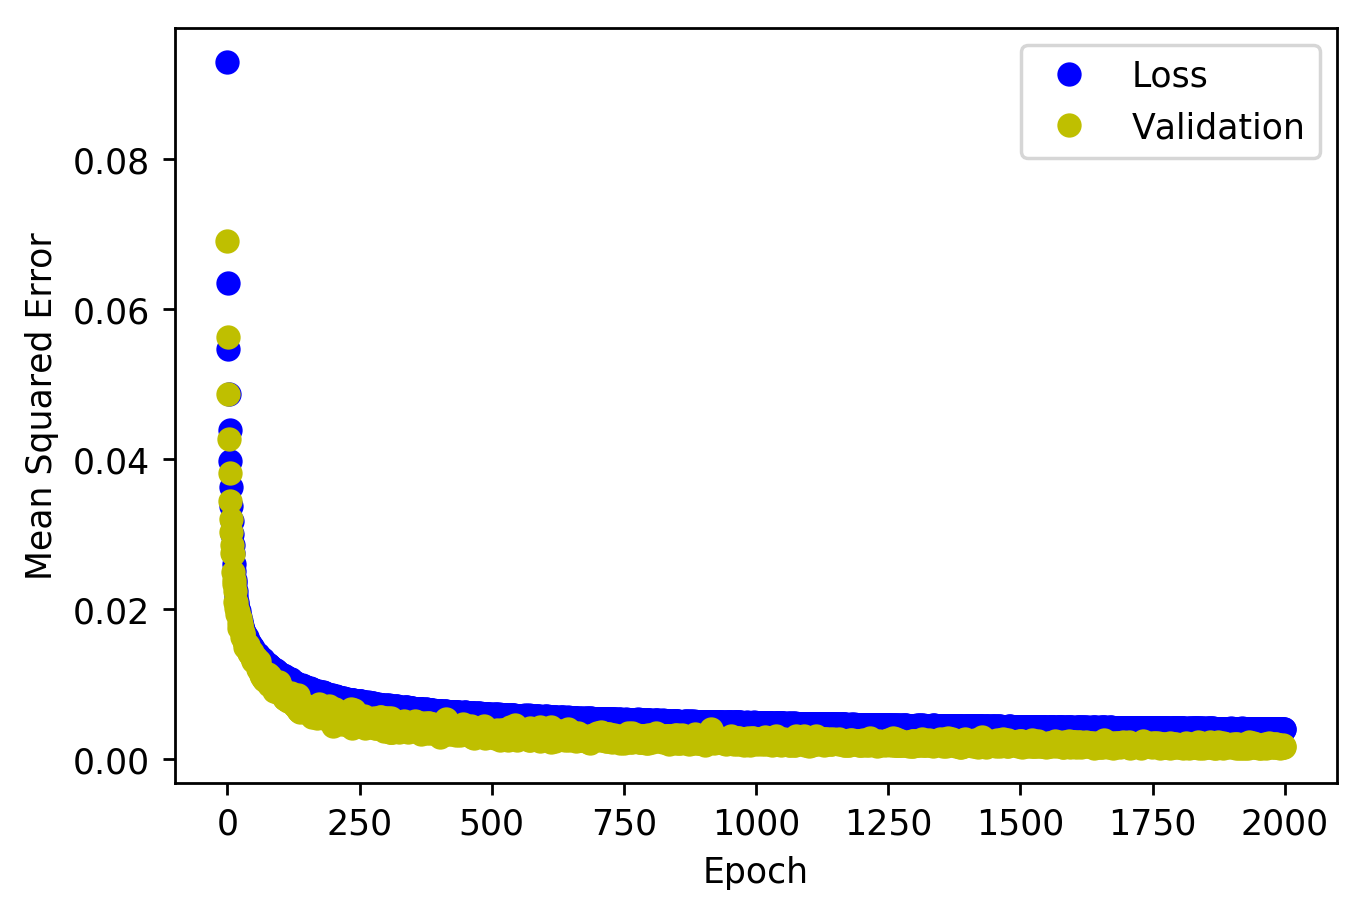

/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


<Figure size 432x288 with 0 Axes>

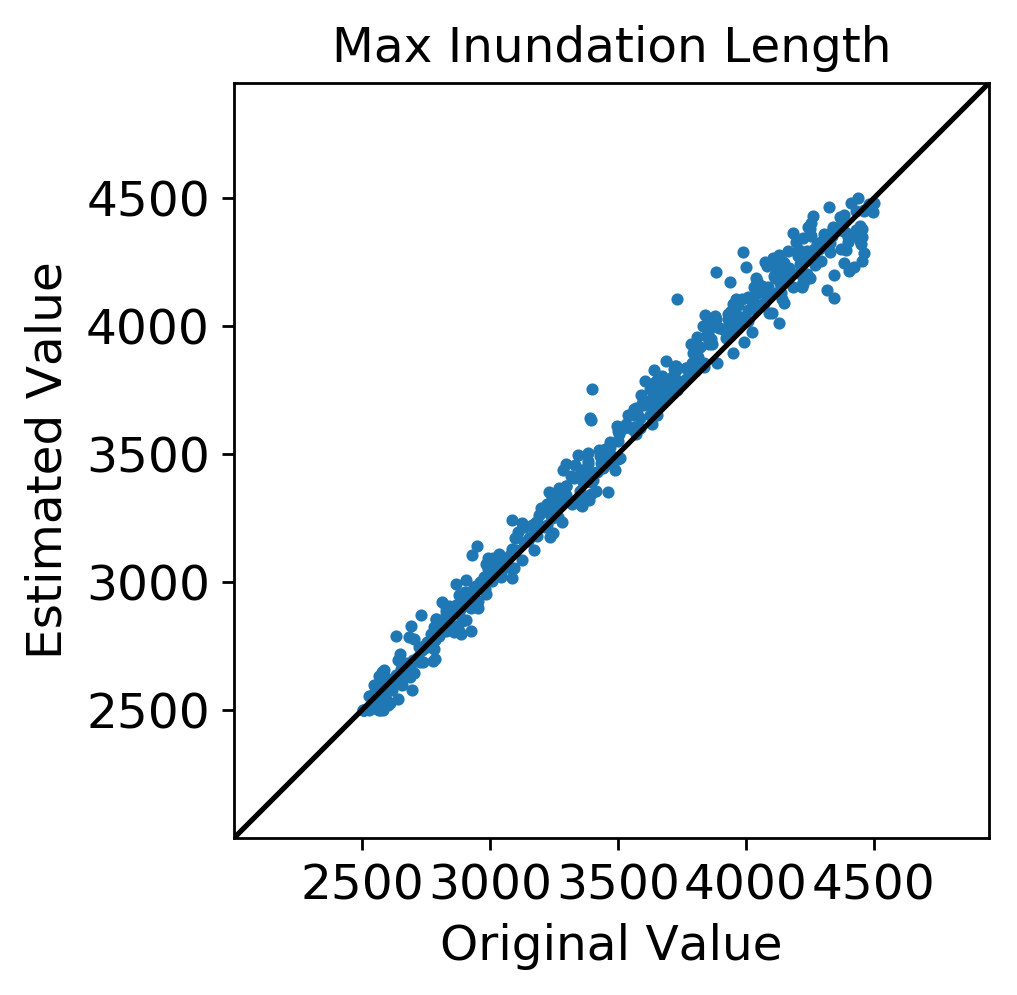

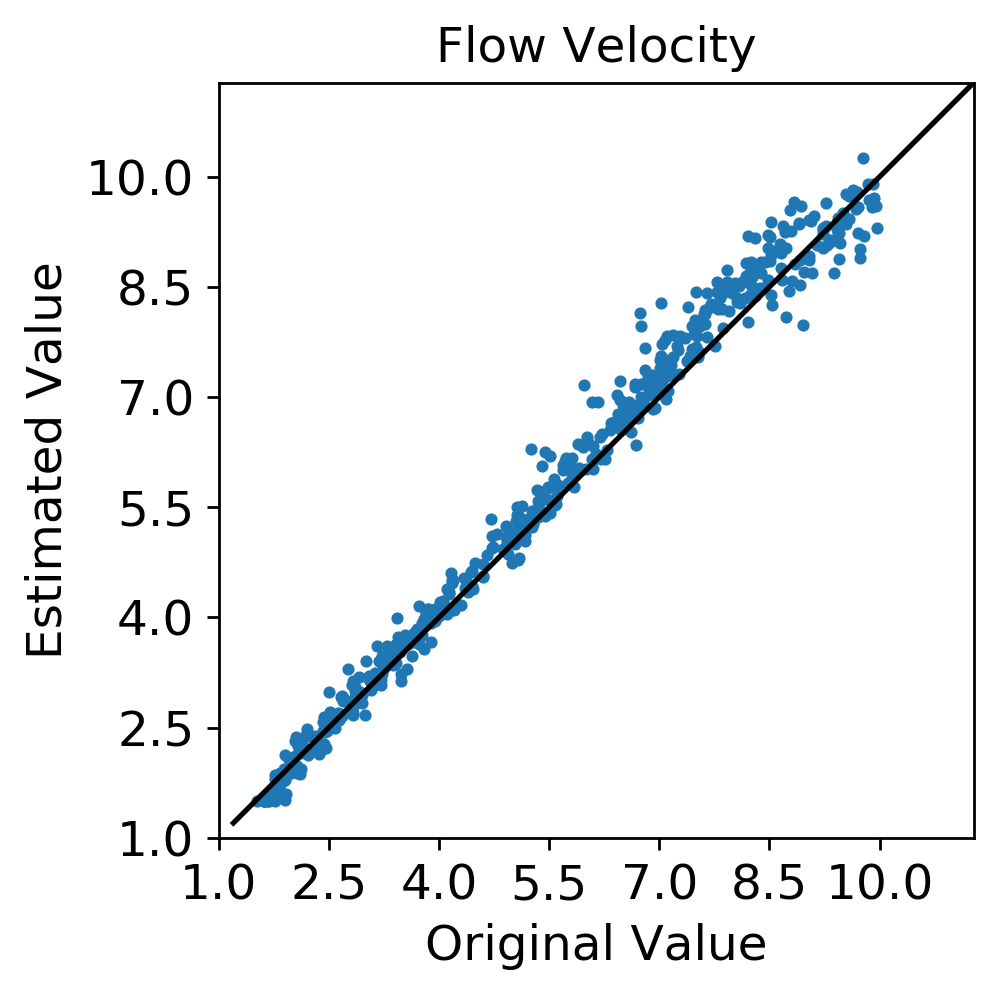

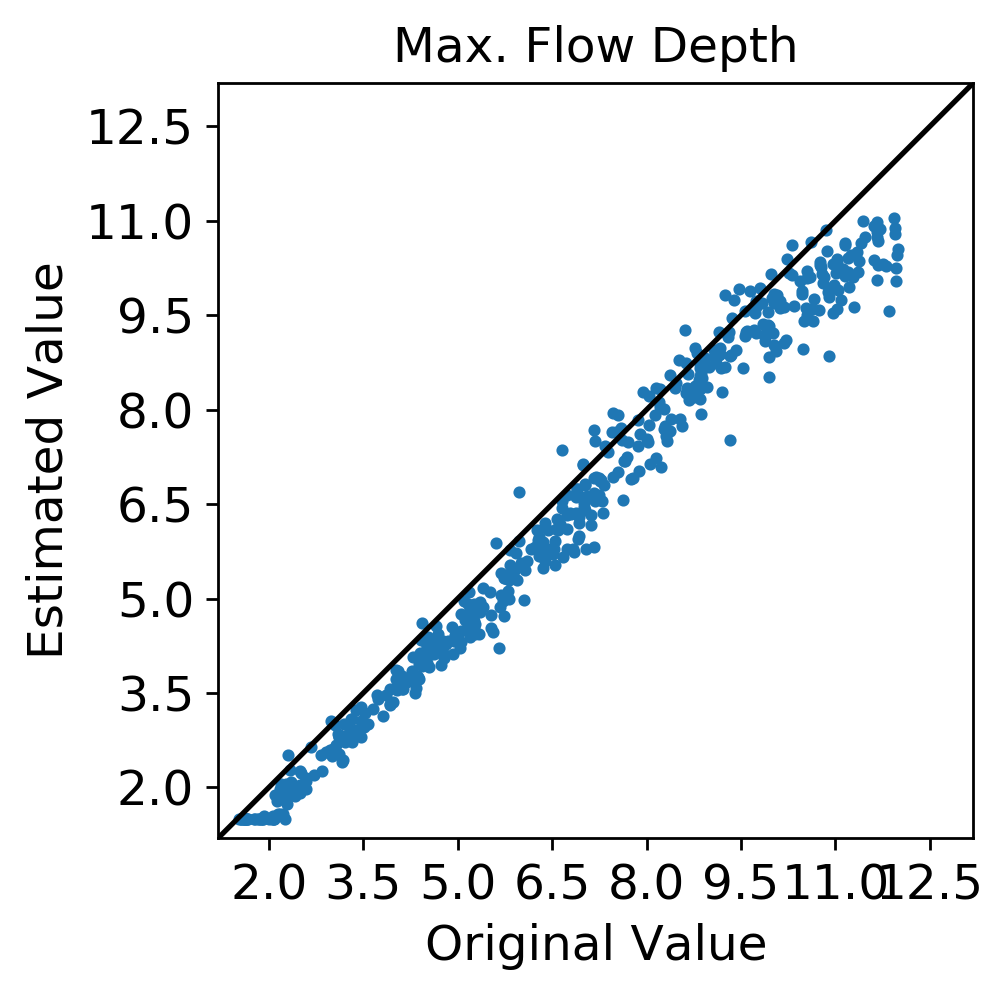

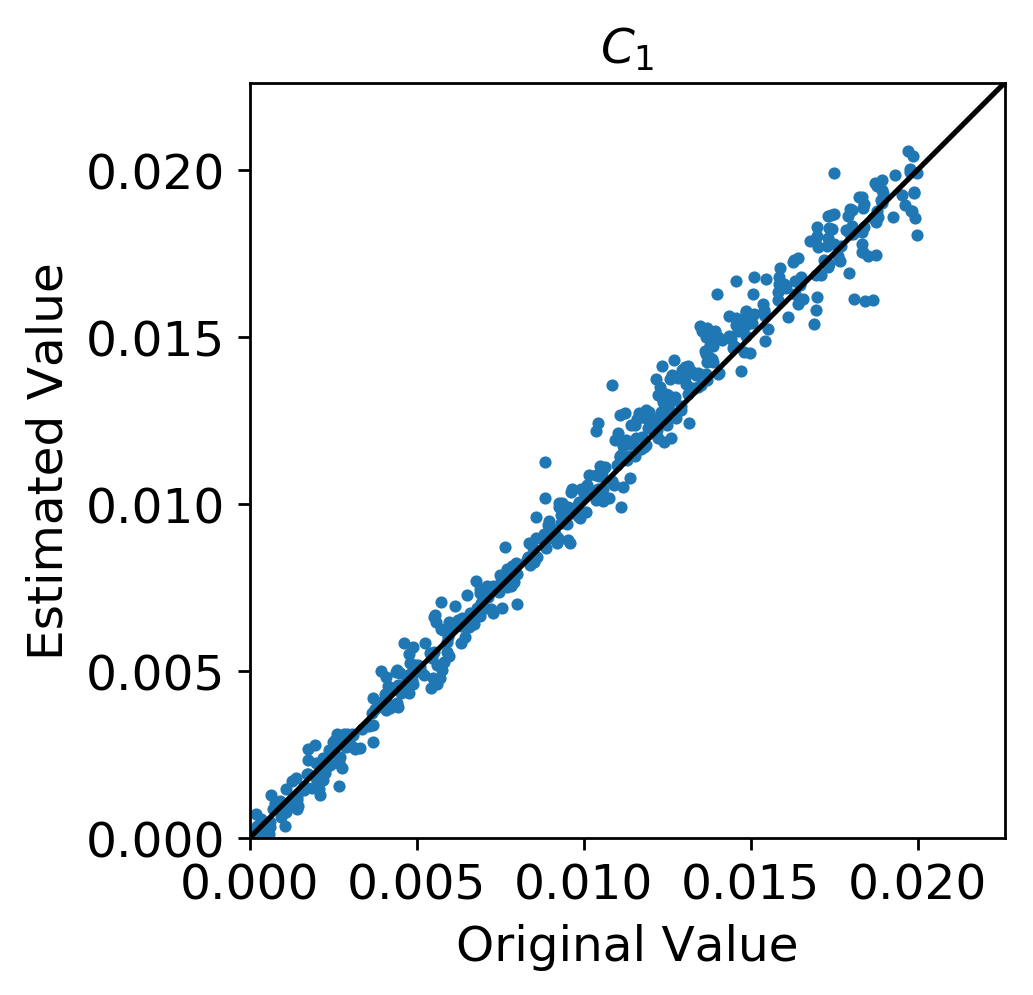

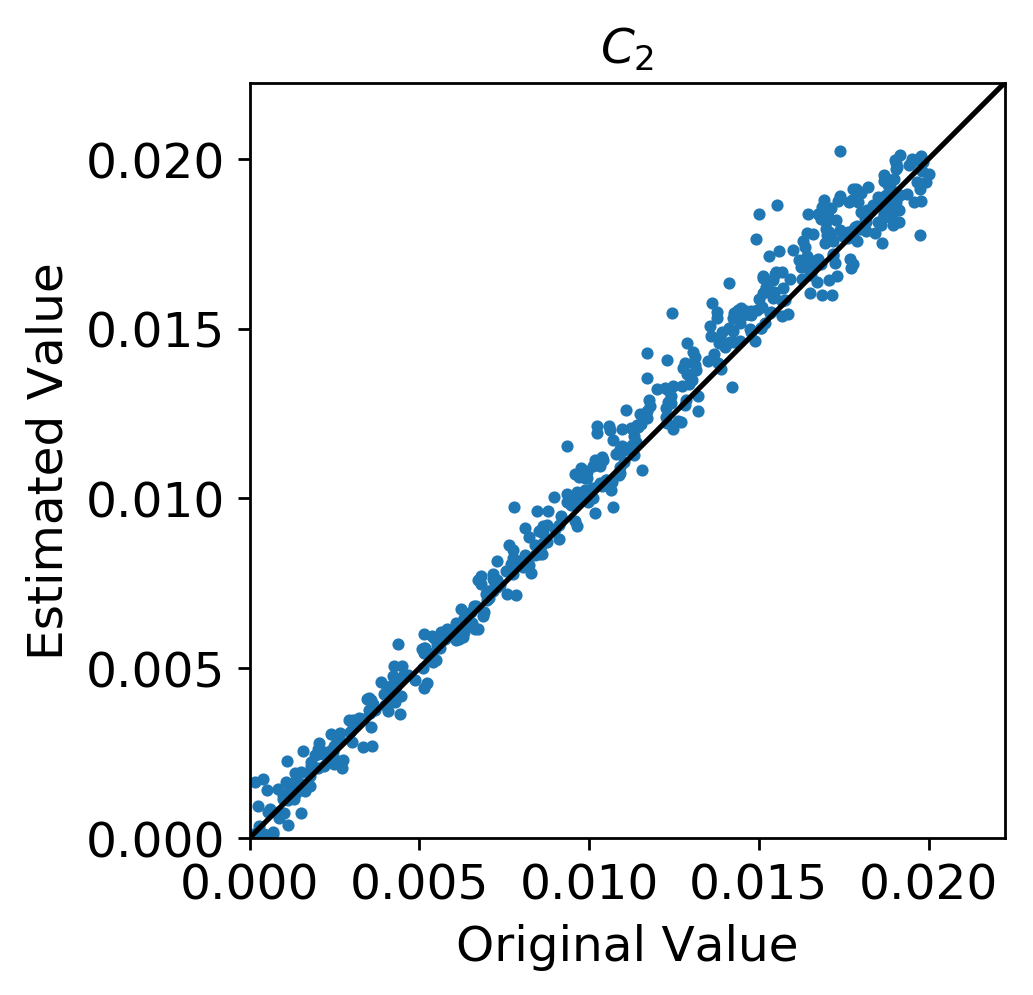

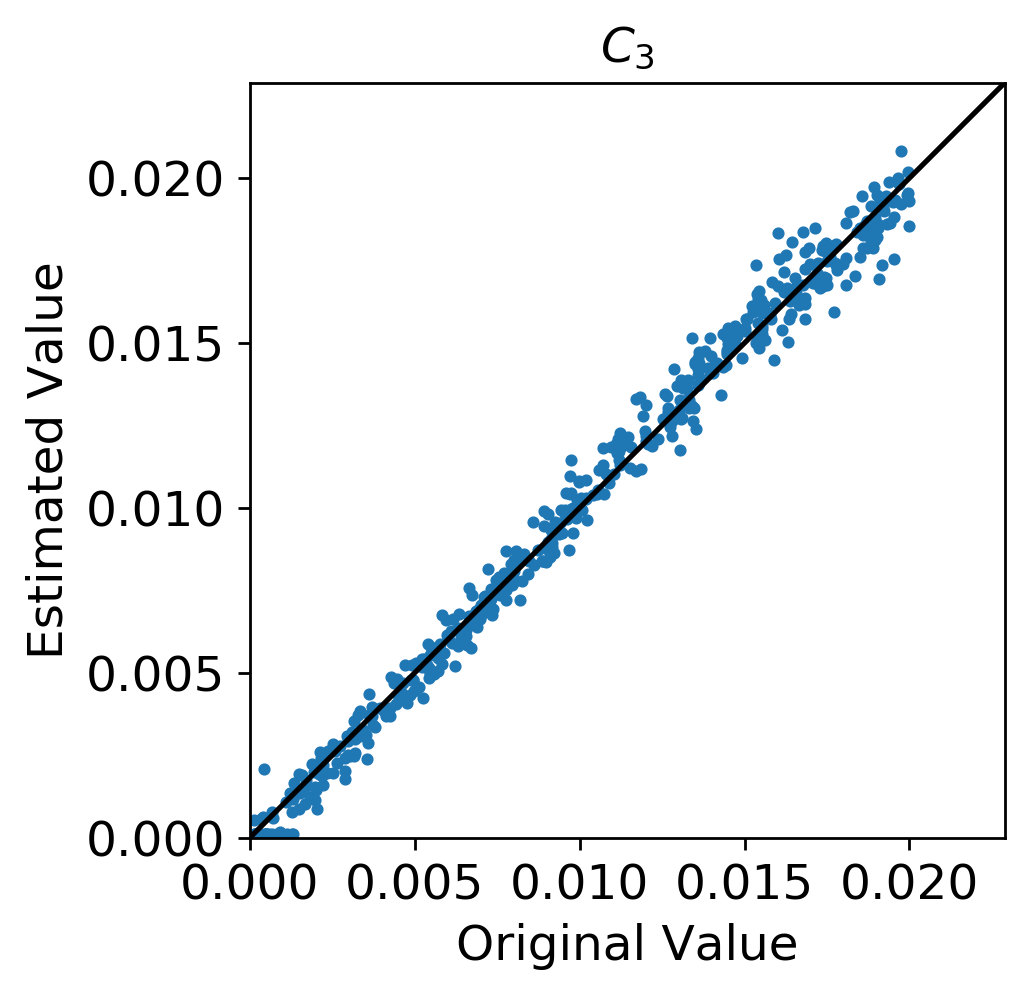

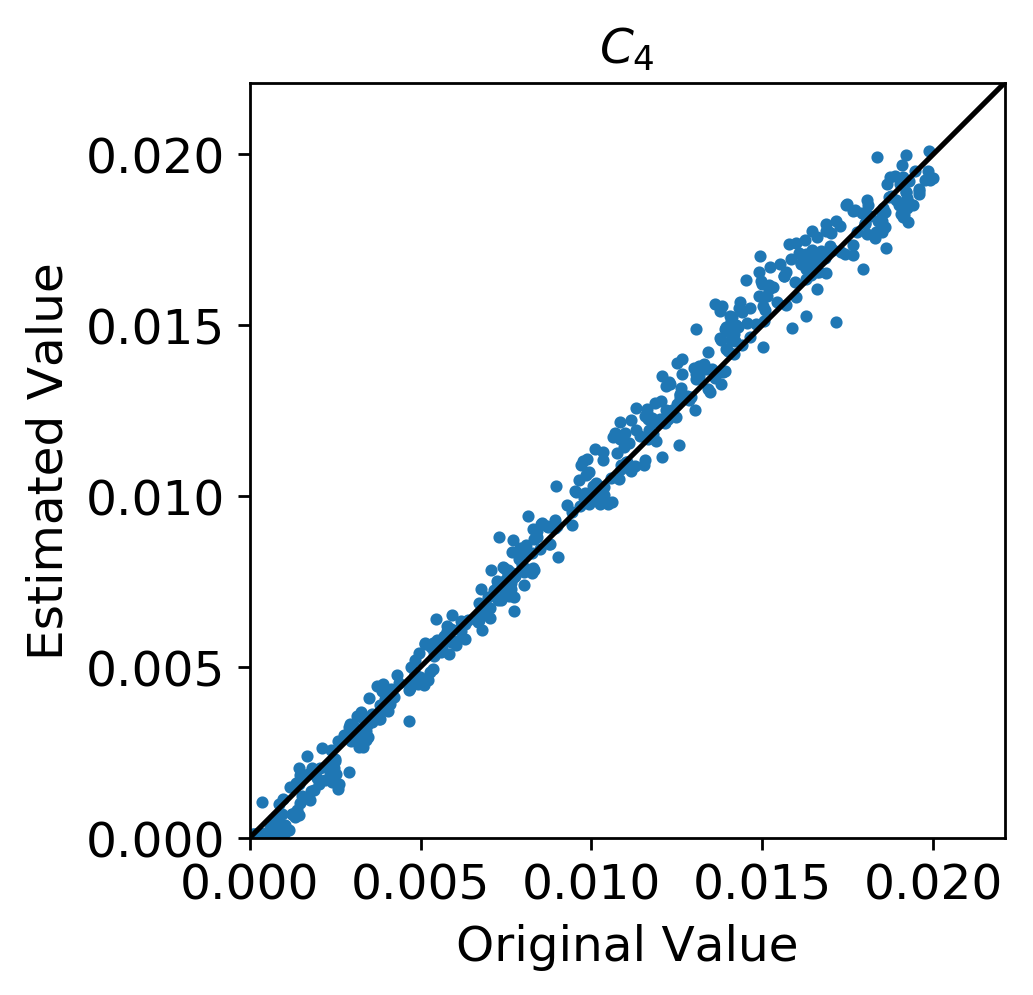

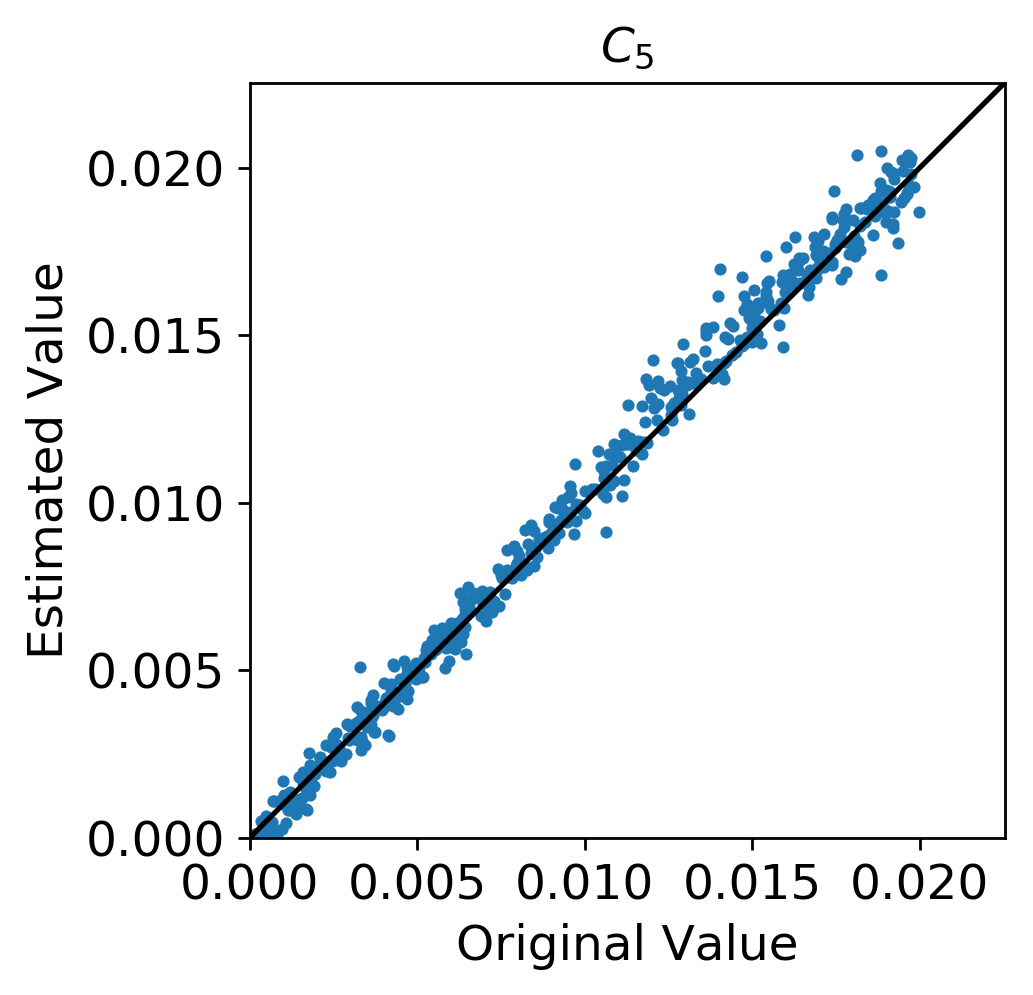

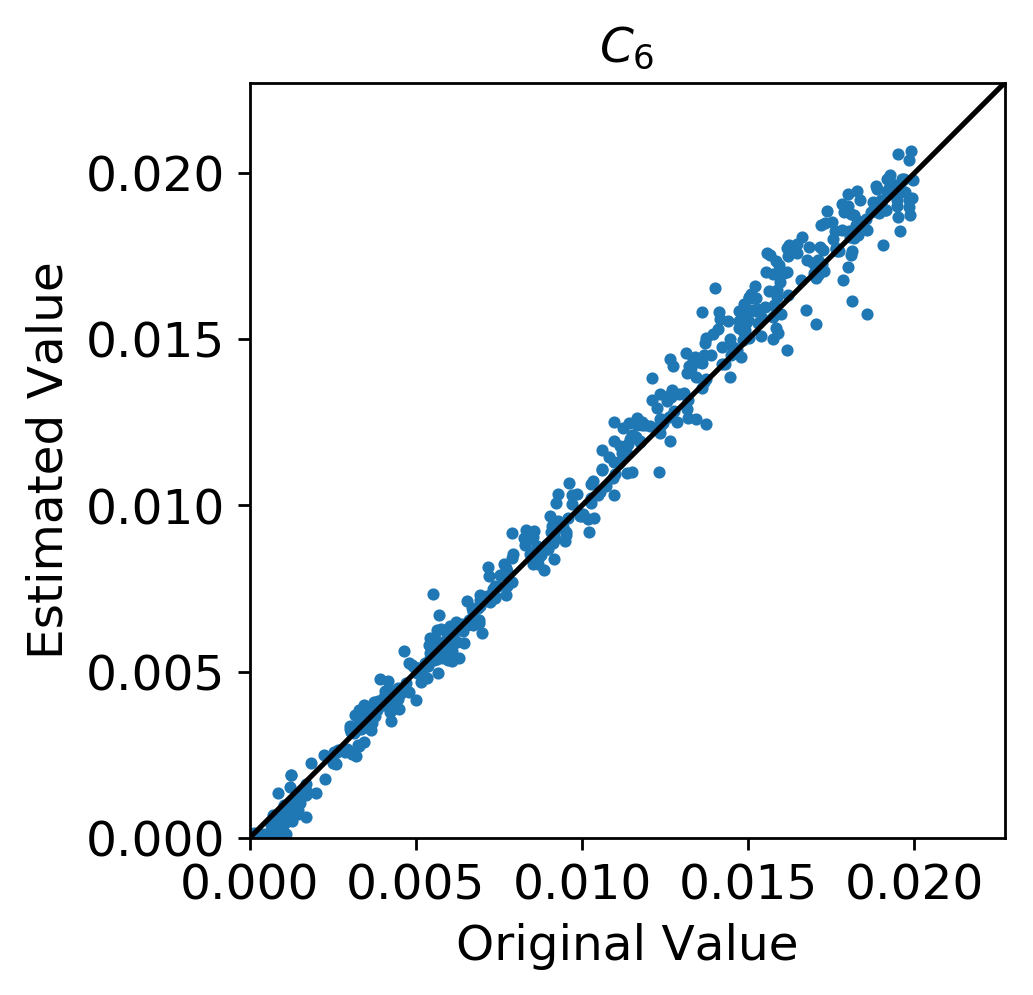

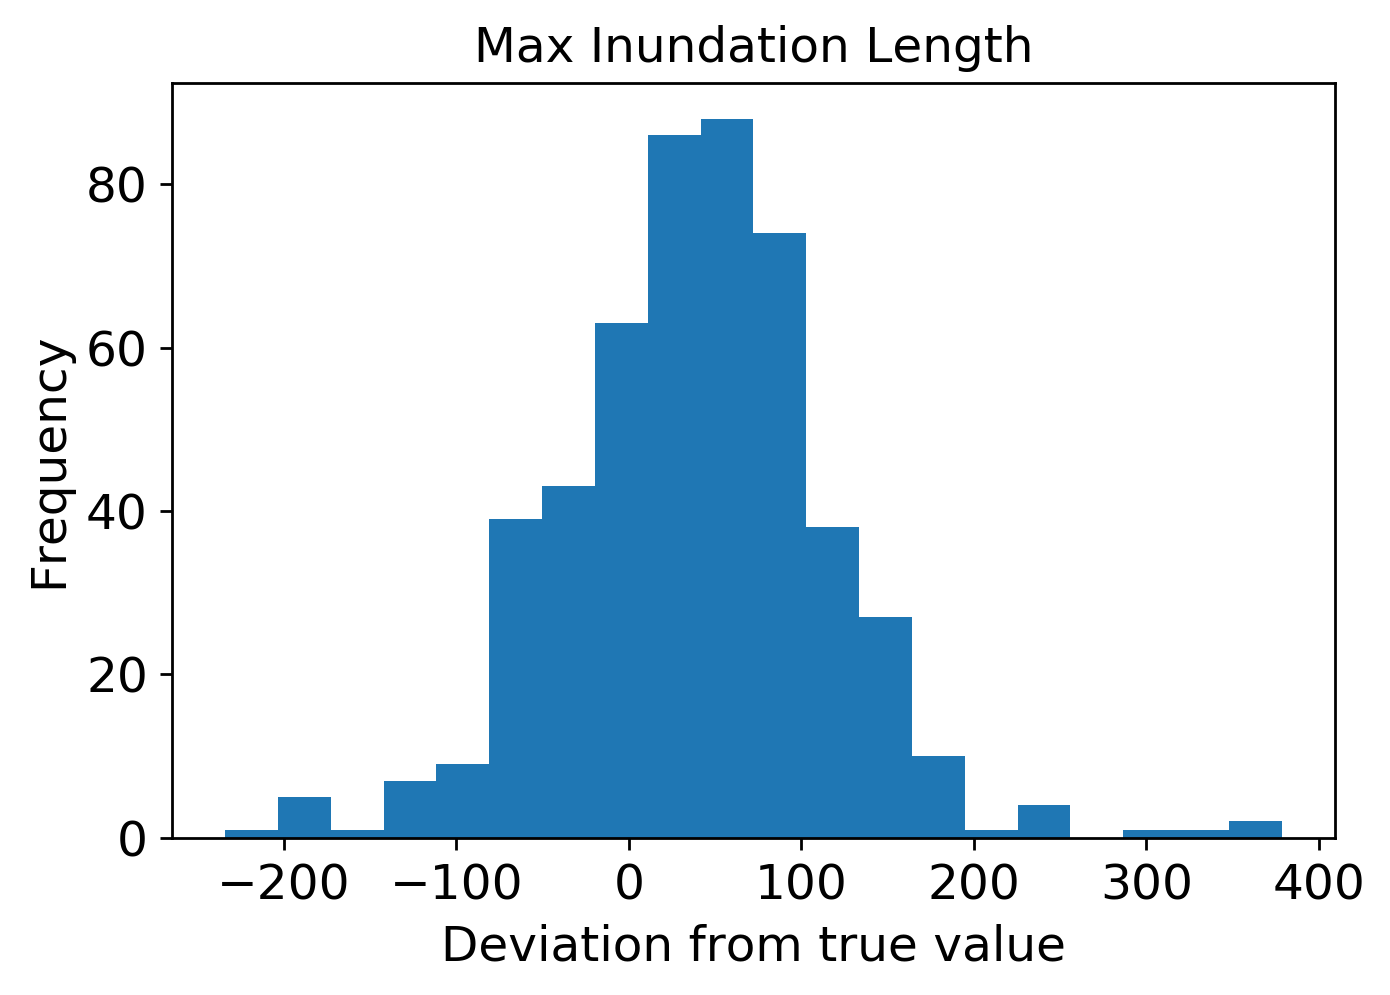

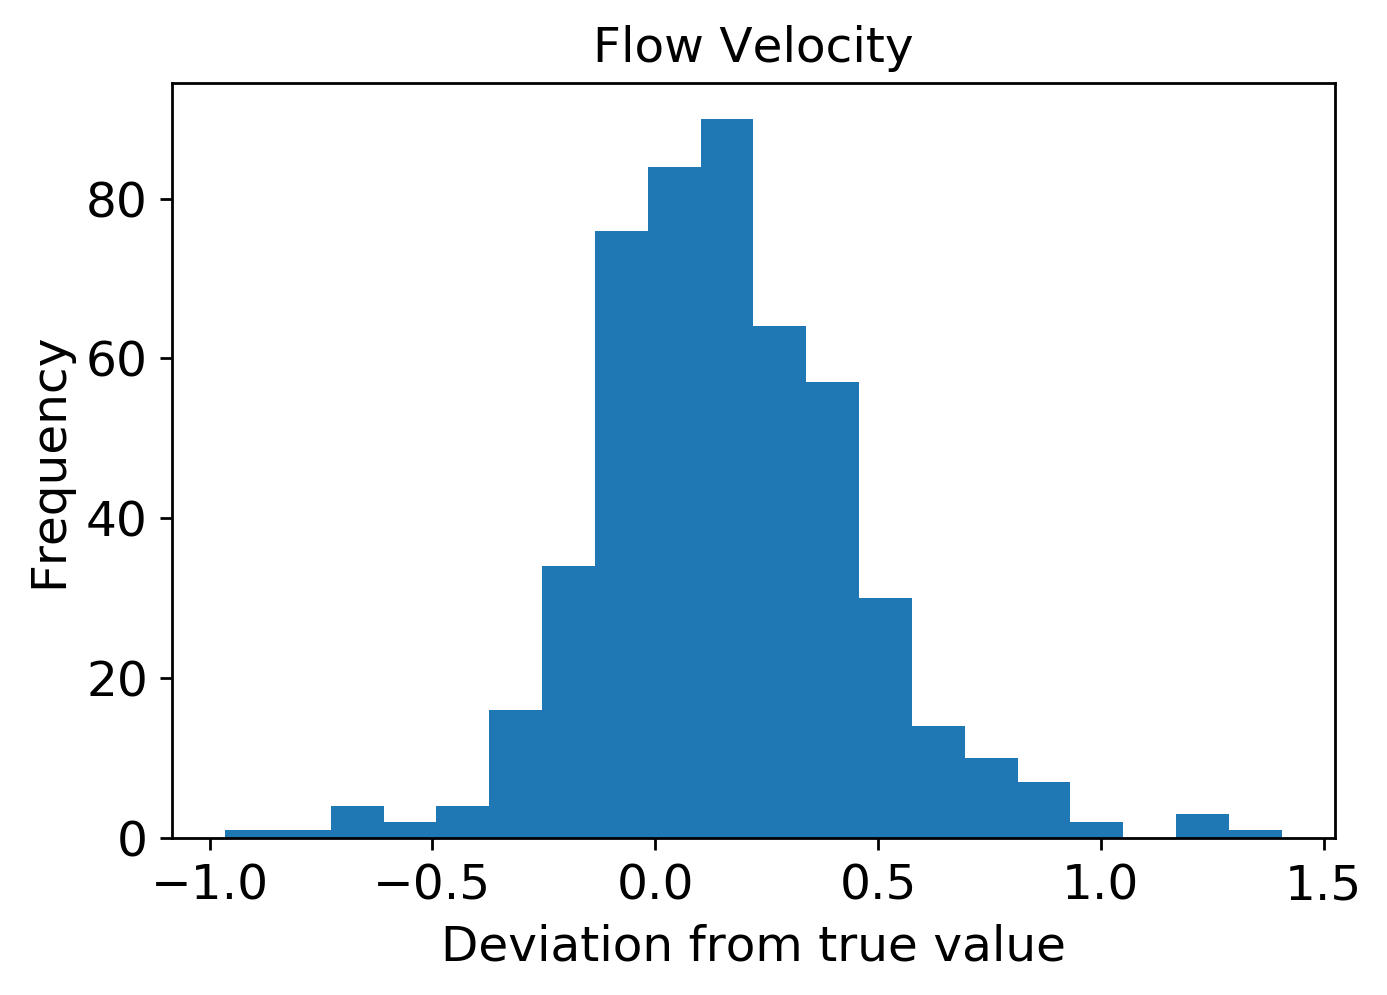

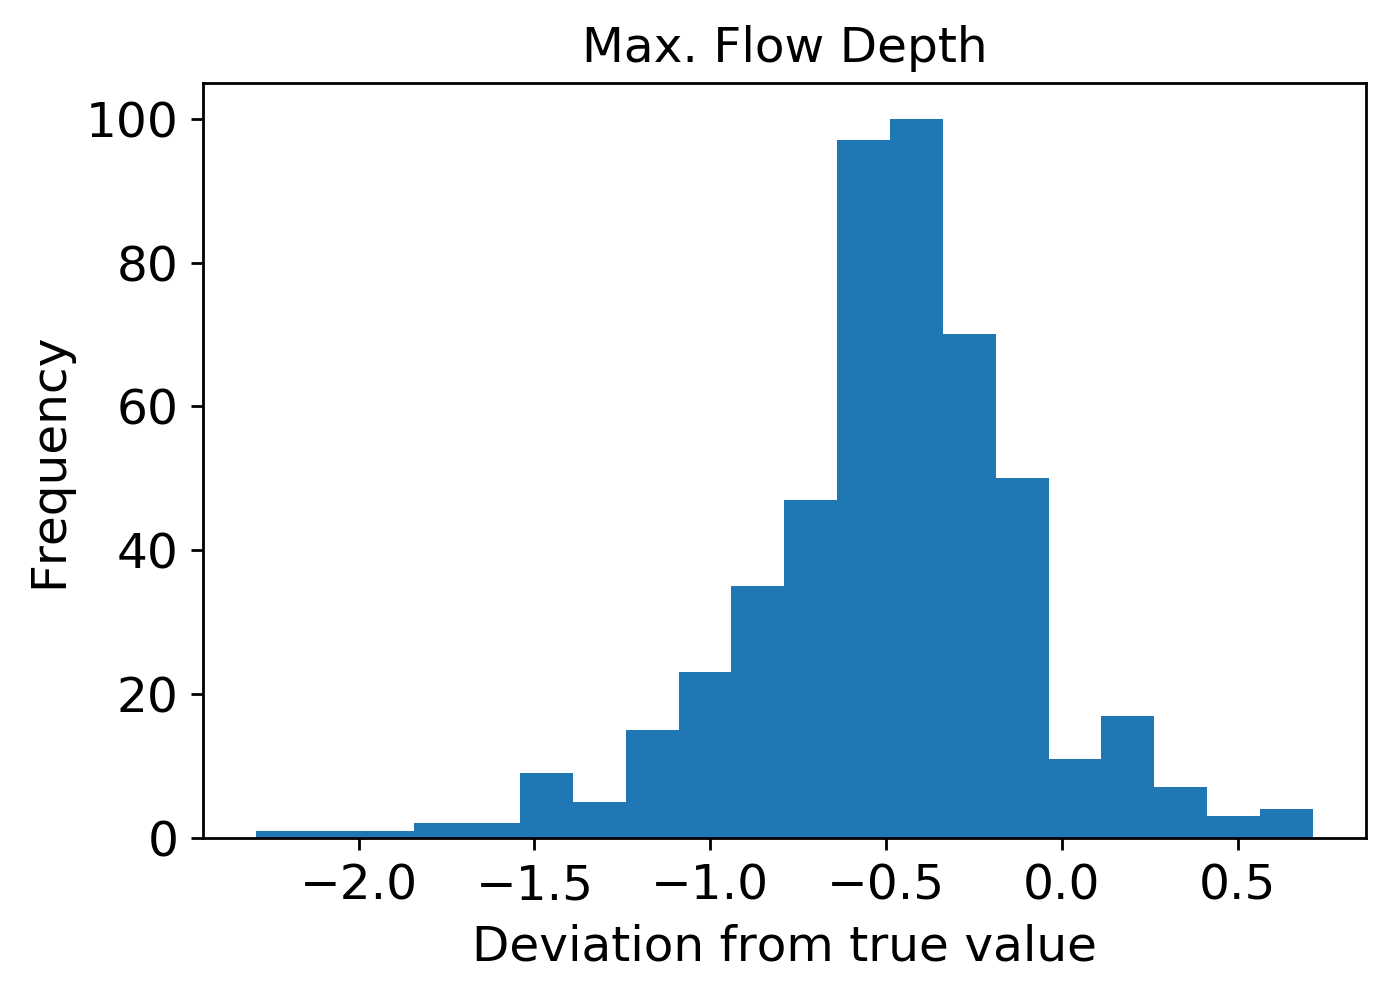

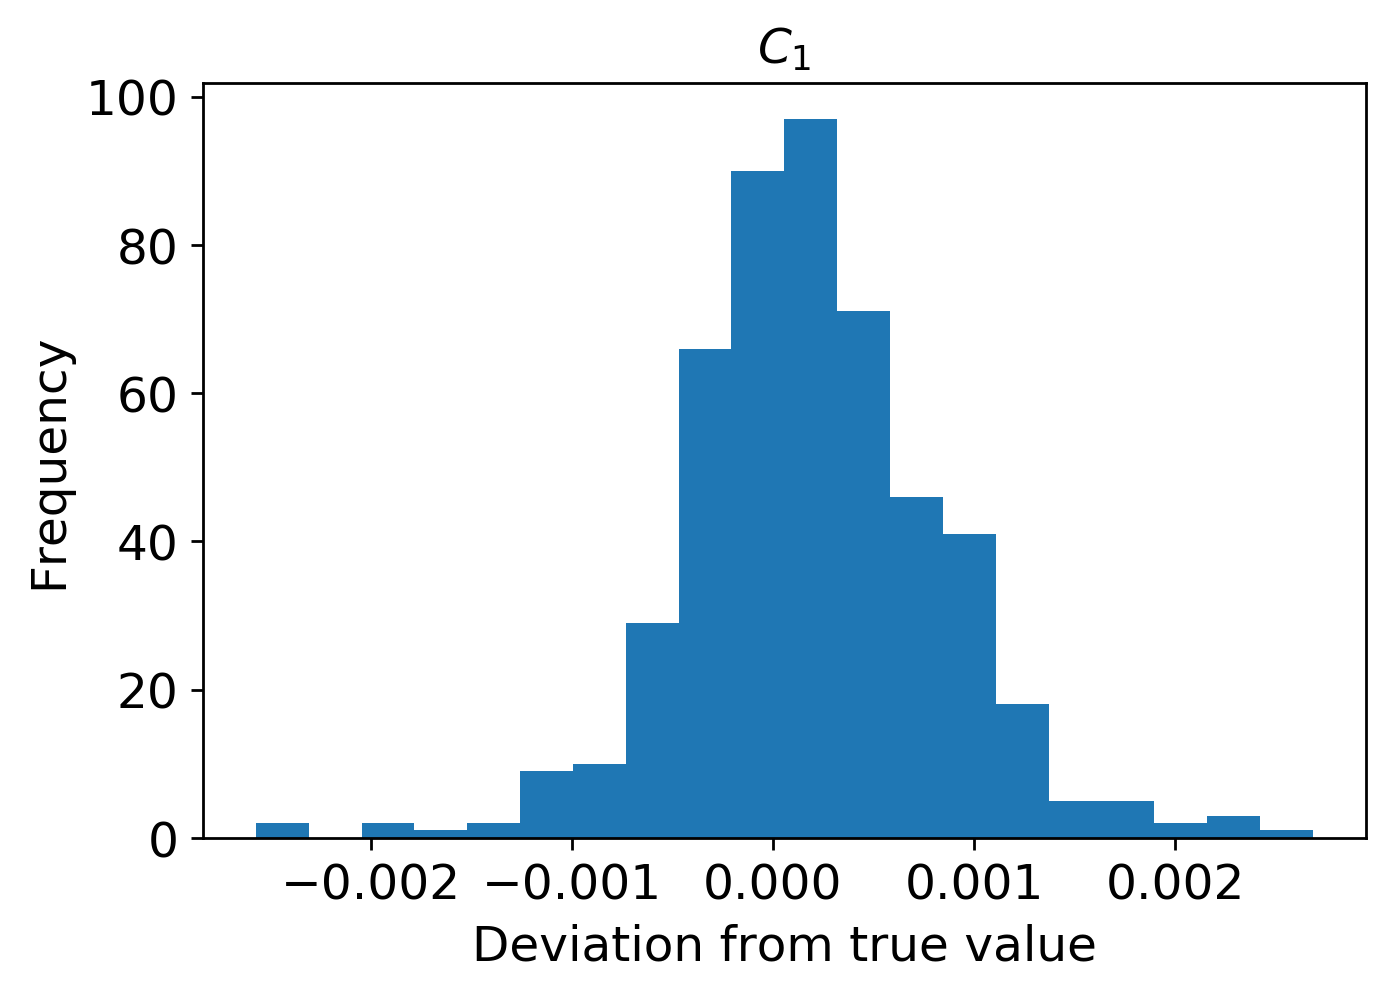

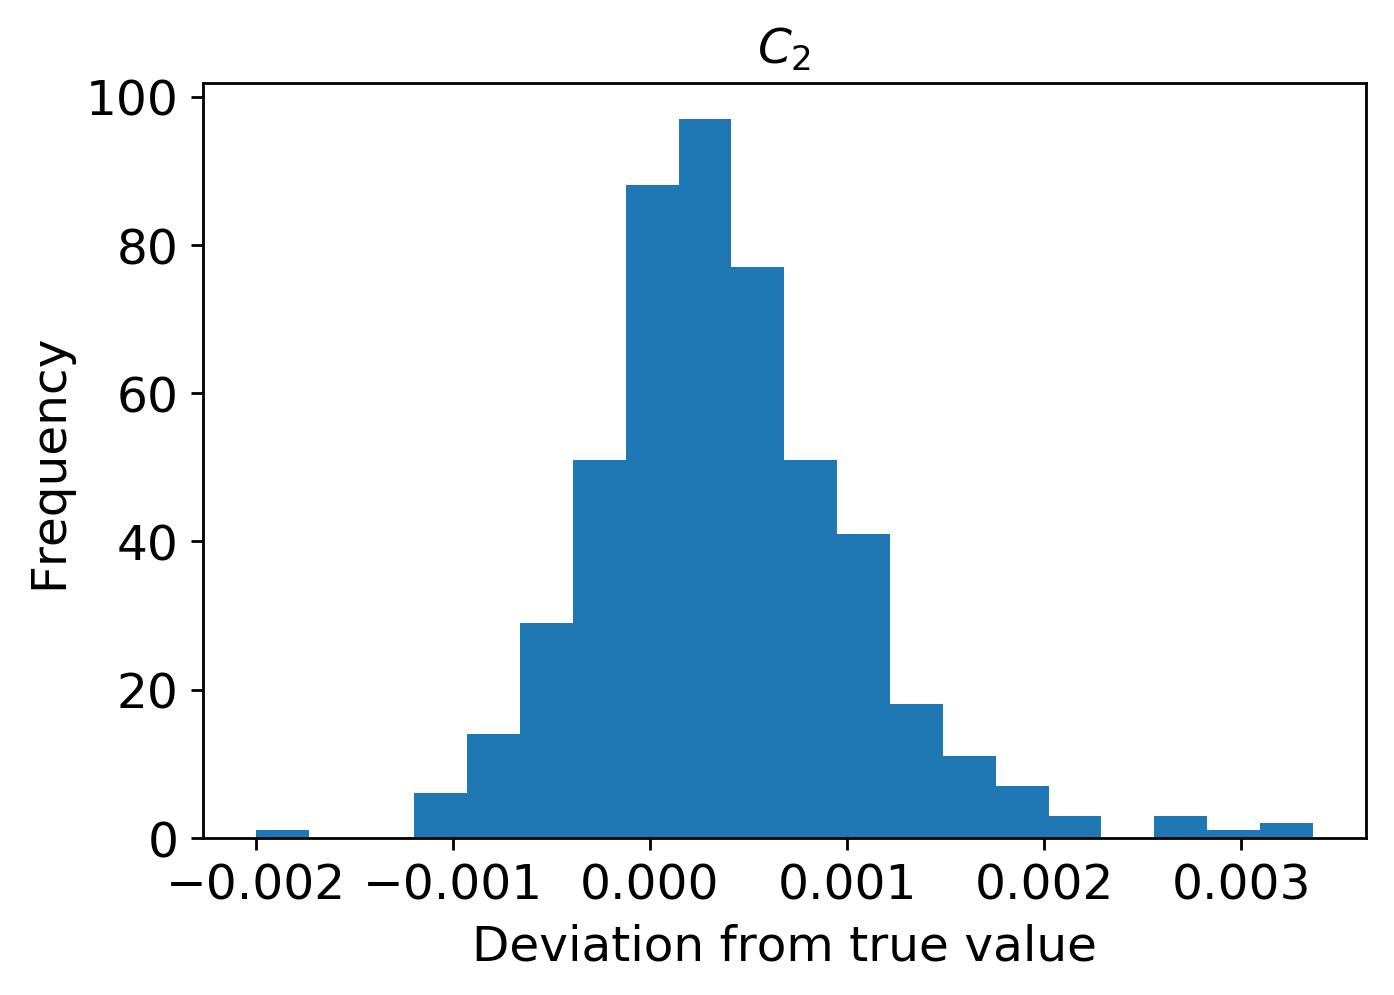

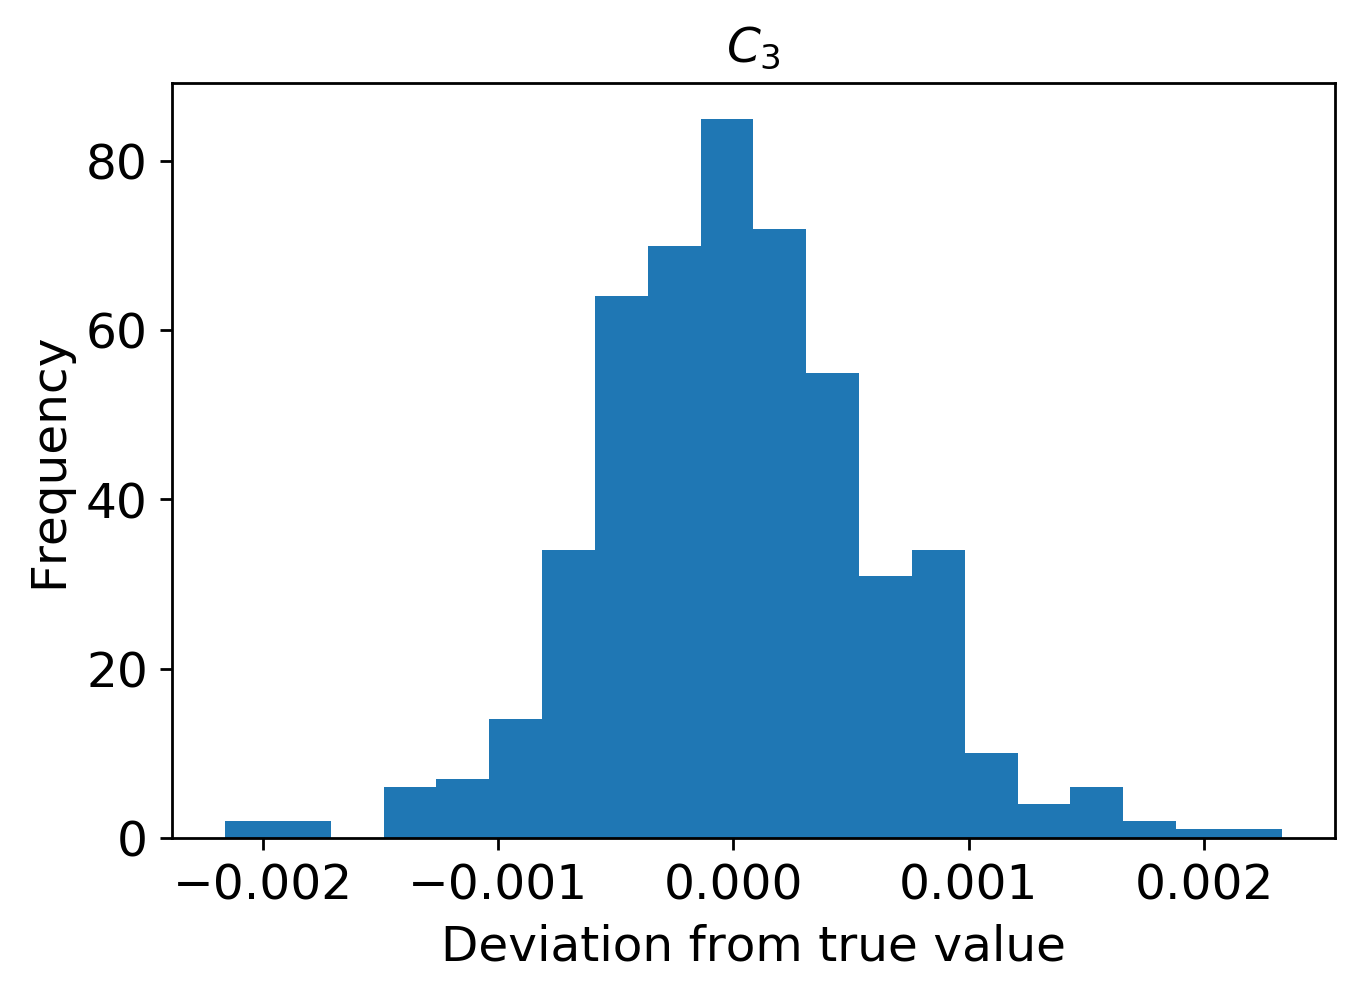

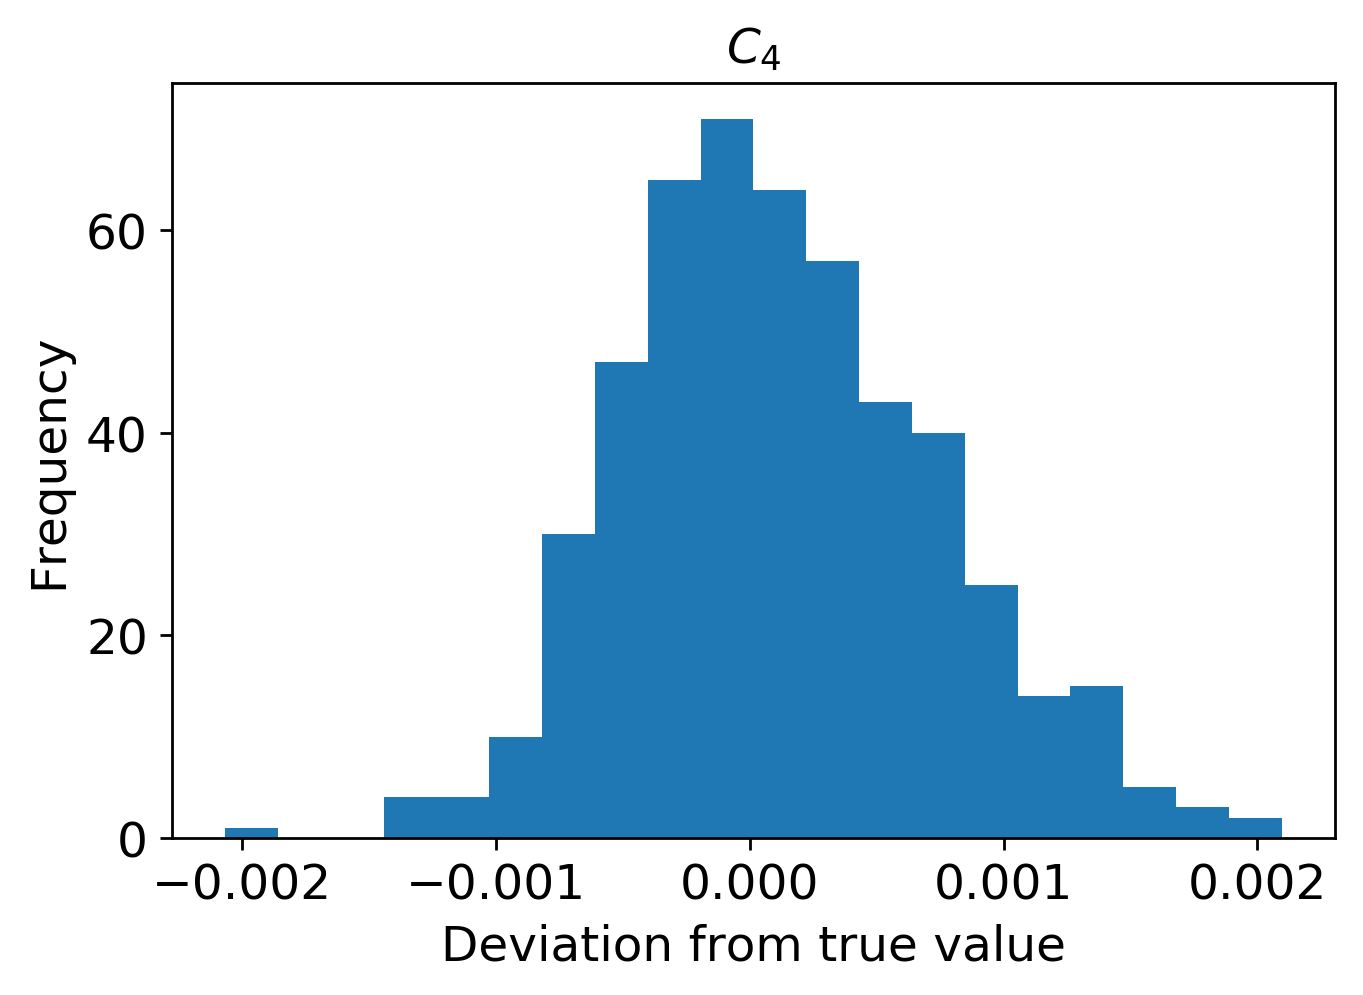

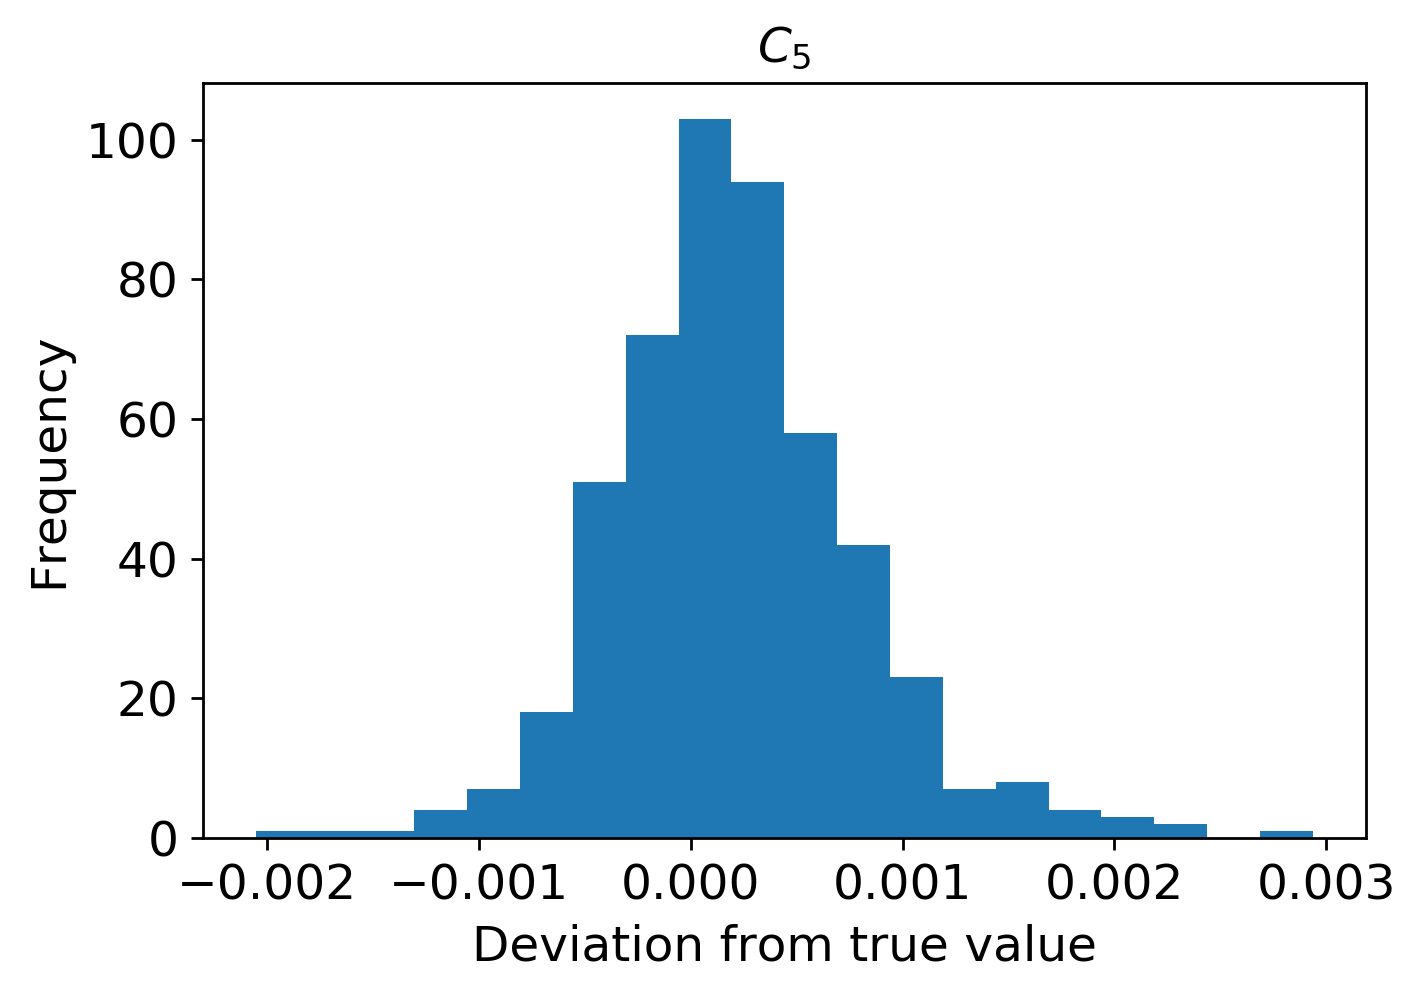

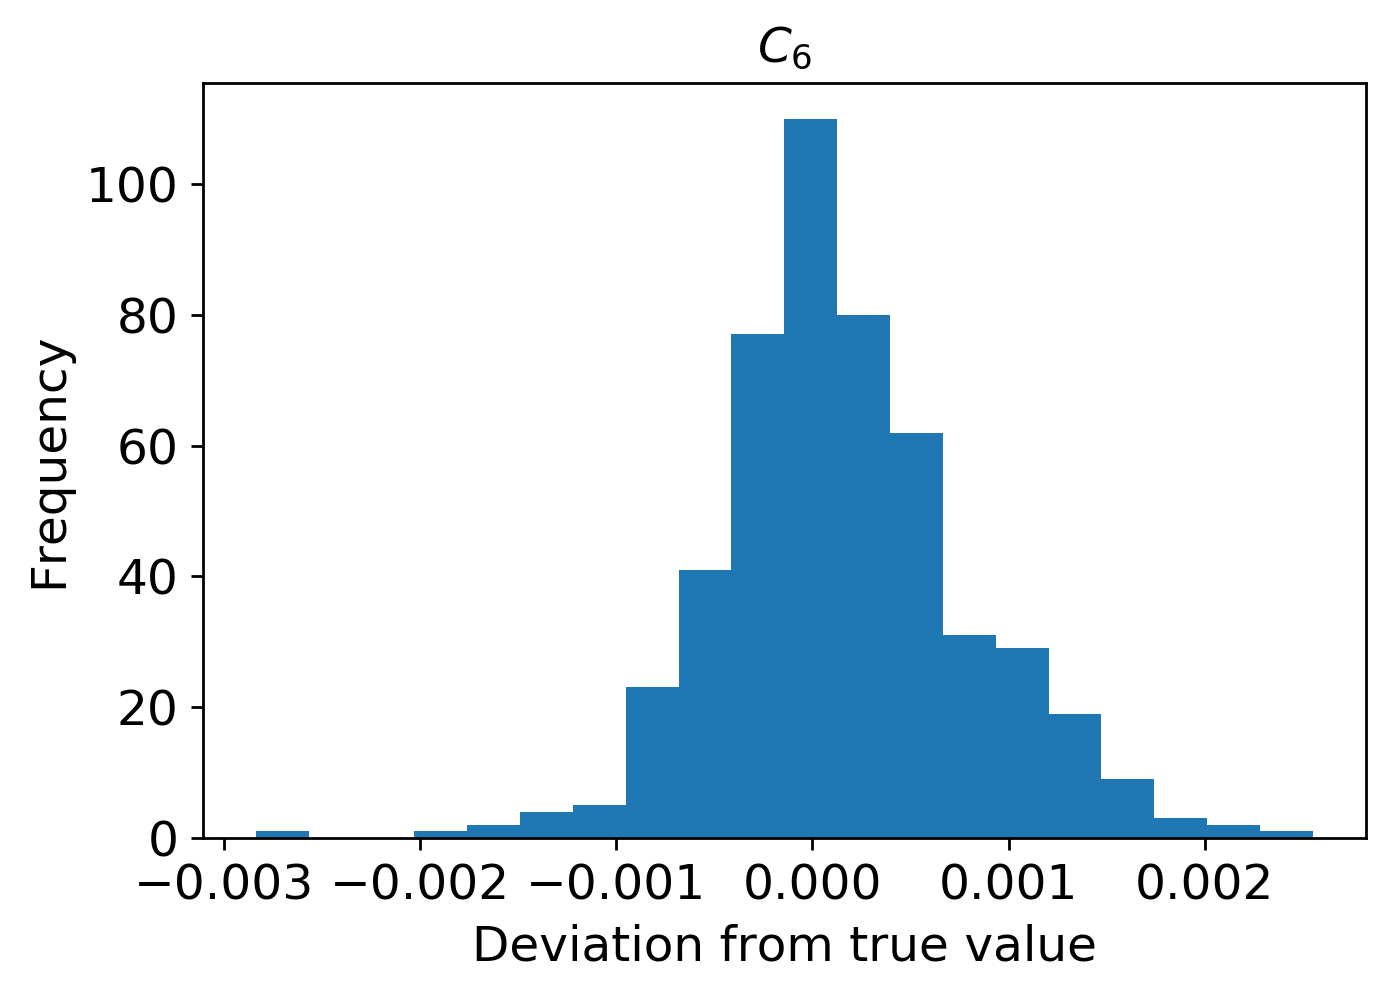

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import ipdb
%matplotlib inline

datadir = '/home/rimali2009/FITTNUSS-forward_training_DNN/data_g6_300grid_H_5000_20_11_roi2000_TC/'
resdir = '/home/rimali2009/FITTNUSS-forward_training_DNN/result_g6_300grid_H_5000_20_11_roi2000_TC/4500/'

test_result = np.loadtxt(resdir + 'test_result.txt',delimiter=',')
icond = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')
print(icond.shape)
loss = np.loadtxt(resdir+'loss.txt',delimiter=',')
epoch = range(0,2000)
vloss = np.loadtxt(resdir+'val_loss.txt',delimiter=',')
resi = test_result - icond

fig = plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
plt.plot(epoch, loss, 'bo',label='Loss')
plt.plot(epoch, vloss, 'yo',label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend(loc="upper right")
plt.savefig(resdir+ 'mse.pdf')
plt.show()

fig2 = plt.figure()
hfont = {'fontname':'Century Gothic'}
textcol = 'k'
titlelabel = ['Max Inundation Length','Flow Velocity', 'Max. Flow Depth', '$C_1$', '$C_2$', '$C_3$', '$C_4$','$C_5$','$C_6$']
xymin=[2500,1.5,1.5,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001]
xymax=[4500,10.0,12.0,0.02,0.02,0.02,0.02,0.02,0.02]
xstep=[500,1.5,1.5,0.005,0.005,0.005,0.005,0.005,0.005]
stepmin=[2500,1.0,2.0,0.000,0.0000,0.0000,0.0000,0.0000,0.0000]
stepmax=[4550,10.5,13.0,0.025,0.025,0.025,0.025,0.025,0.025]

    
for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.plot(icond[:,i],test_result[:,i],"o",markersize = 2.5)
    x=icond[:,i]
    y=test_result[:,i]
    max_value = np.max([x, y])
    min_value = np.min([x, y])
    y_lim = plt.ylim([min_value * 0.8, max_value * 1.1])
    x_lim = plt.xlim([min_value * 0.8, max_value * 1.1])
    plt.plot(x_lim, y_lim, 'k-', color = 'k')
    #plt.plot([xymin[i],xymax[i]],[xymin[i],xymax[i]],"-",color = 'k')
    plt.axes().set_aspect('equal')
    #plt.ylim(xymin[i],xymax[i])
    #plt.xlim(xymin[i],xymax[i])
    plt.xticks(np.arange(stepmin[i],stepmax[i], step=xstep[i]))
    plt.yticks(np.arange(stepmin[i],stepmax[i], step=xstep[i]))
    plt.xlabel('Original Value',color=textcol,size=14,**hfont)
    plt.ylabel('Estimated Value',color=textcol,size=14,**hfont)
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + '.eps')
    plt.savefig(resdir+titlelabel[i] + '.pdf')
    #plt.show()

for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.hist(resi[:,i],bins=20)
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('Deviation from true value',color=textcol,size=14,**hfont)
    plt.ylabel('Frequency',color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.eps')
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.pdf')
    plt.show()

# Determining standard devieation from residual value

(500, 9)
Standard Deviation: 76.95947623084994
Standard Deviation sample: 77.03655133903113
Mean: 38.60343421332958
CV: 1.9955880327463402


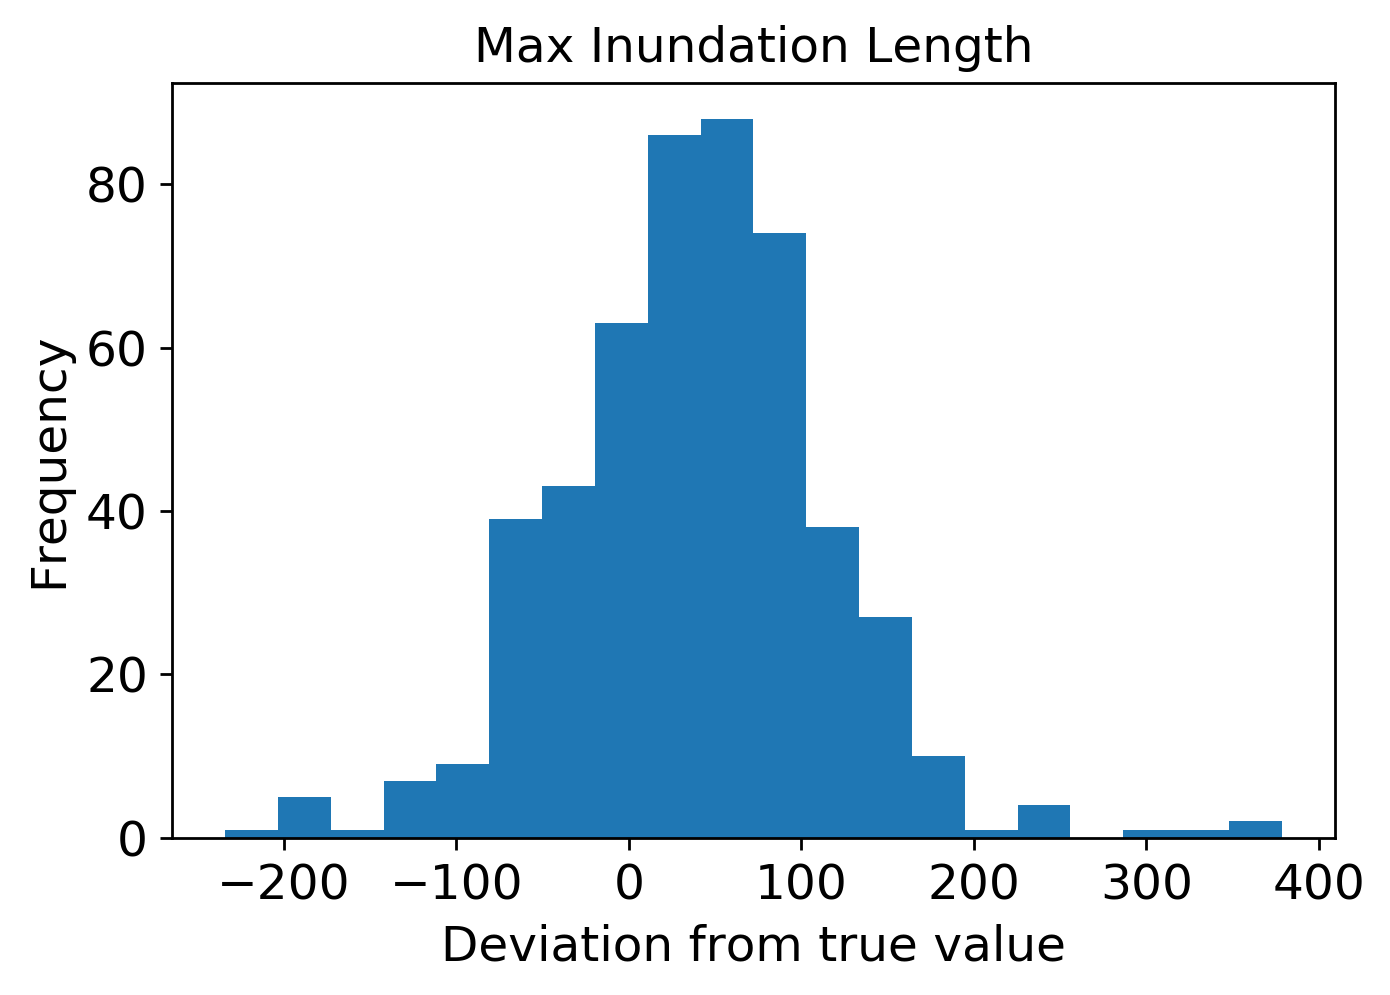

Standard Deviation: 0.3013757505347661
Standard Deviation sample: 0.301677579103687
Mean: 0.16010507422247108
CV: 1.8842474579193937


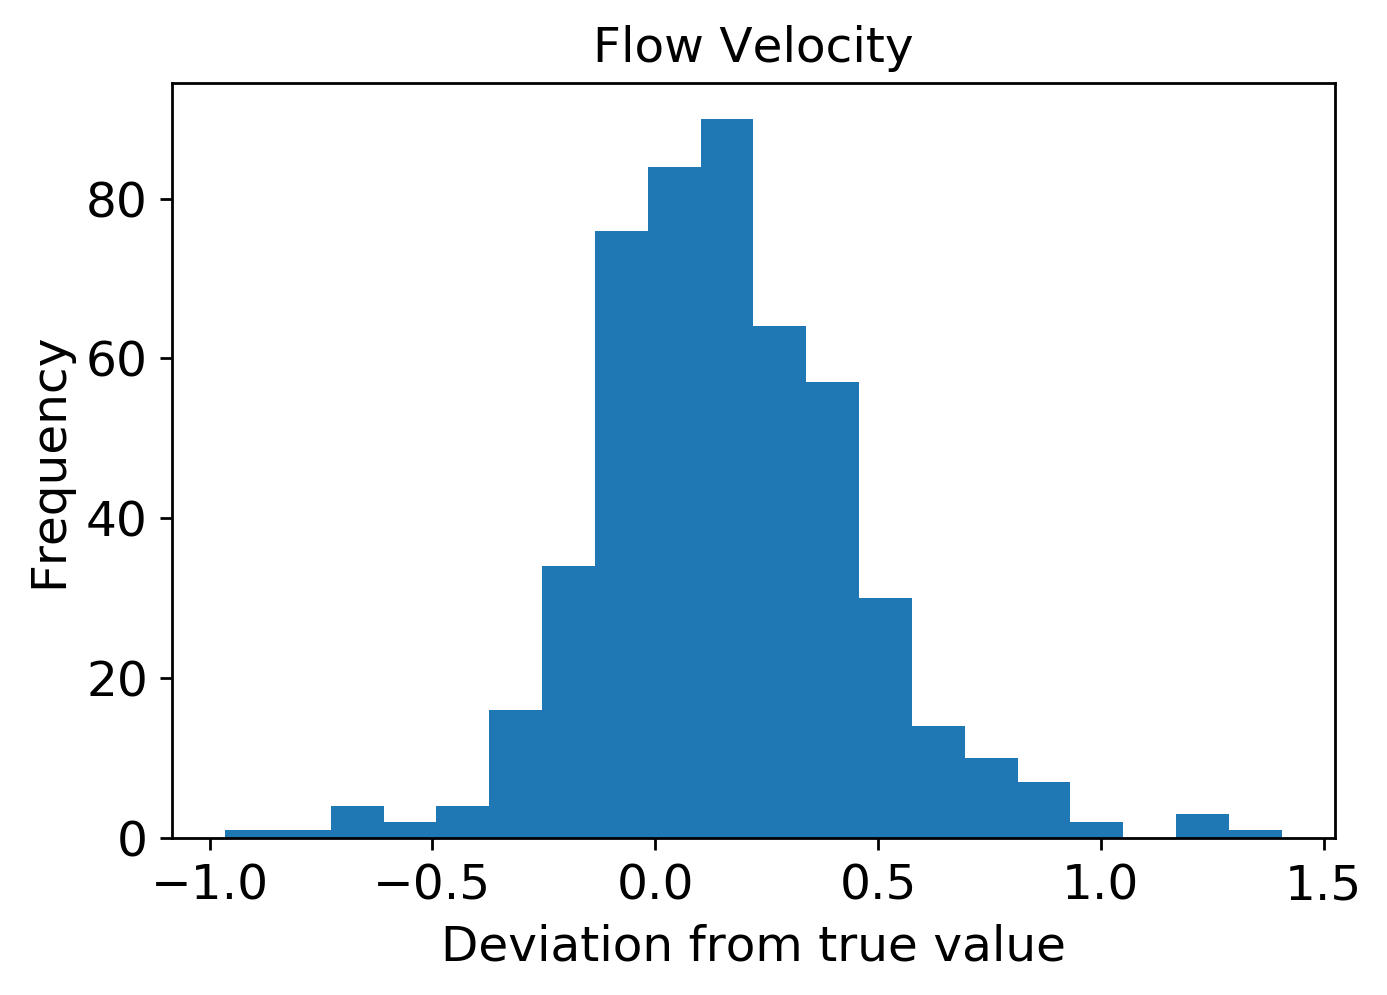

Standard Deviation: 0.4014586874192123
Standard Deviation sample: 0.40186074930006893
Mean: -0.49189616219376814
CV: -0.8169625628056183


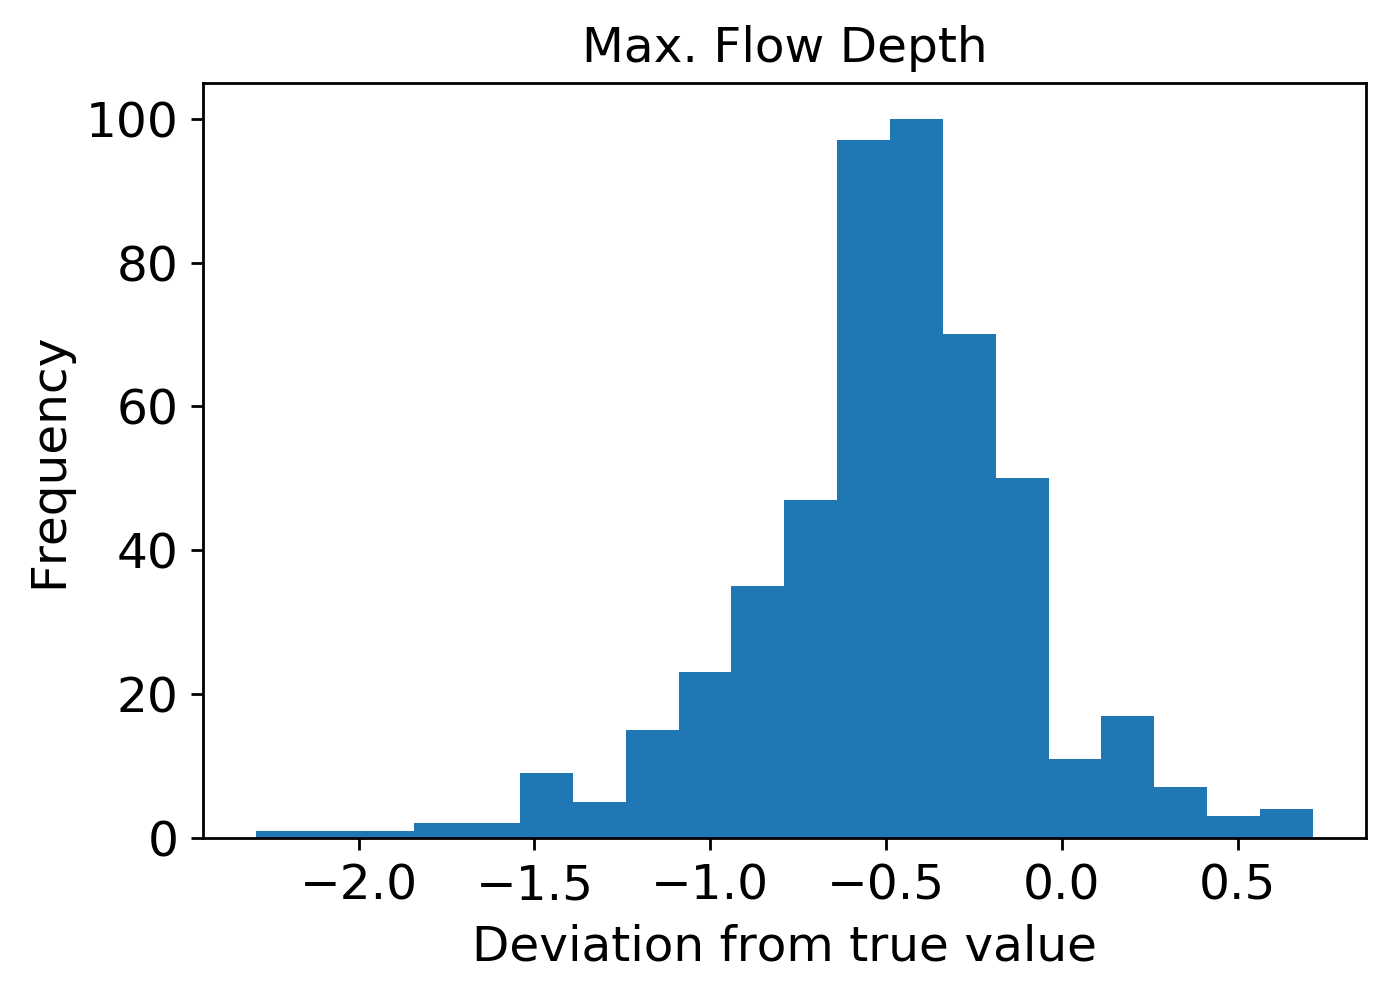

Standard Deviation: 0.0006499290710363927
Standard Deviation sample: 0.0006505799766287069
Mean: 0.00020020630352526495
CV: 3.249547917189367


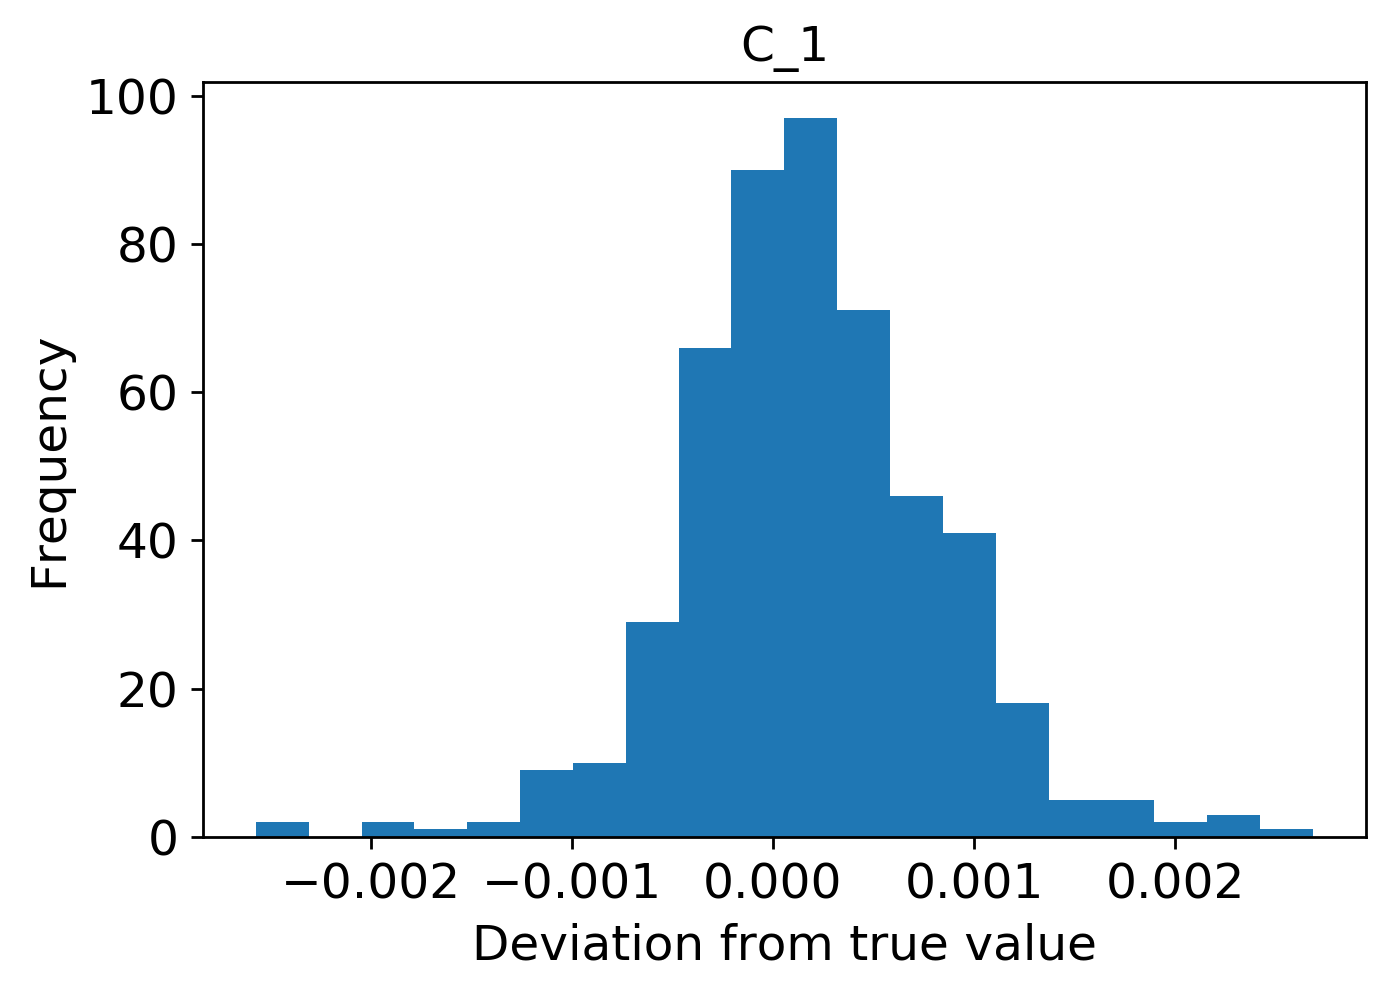

Standard Deviation: 0.0006740532444080269
Standard Deviation sample: 0.0006747283104203889
Mean: 0.00037442798510002714
CV: 1.8020242537163391


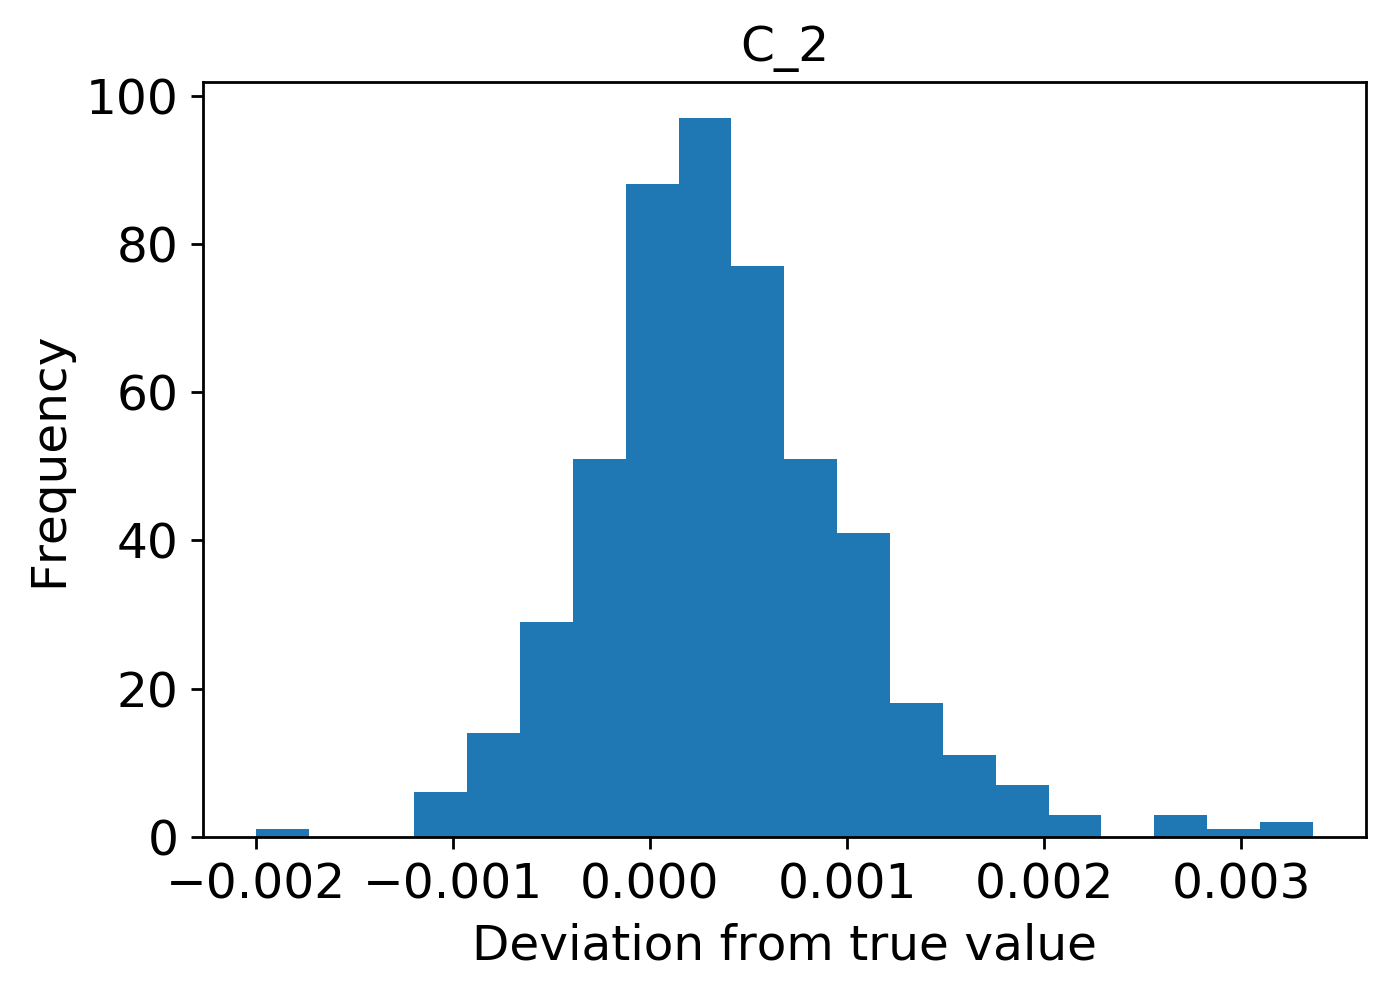

Standard Deviation: 0.0006070547956007552
Standard Deviation sample: 0.000607662762498847
Mean: 1.8341427933293055e-05
CV: 33.13061364190885


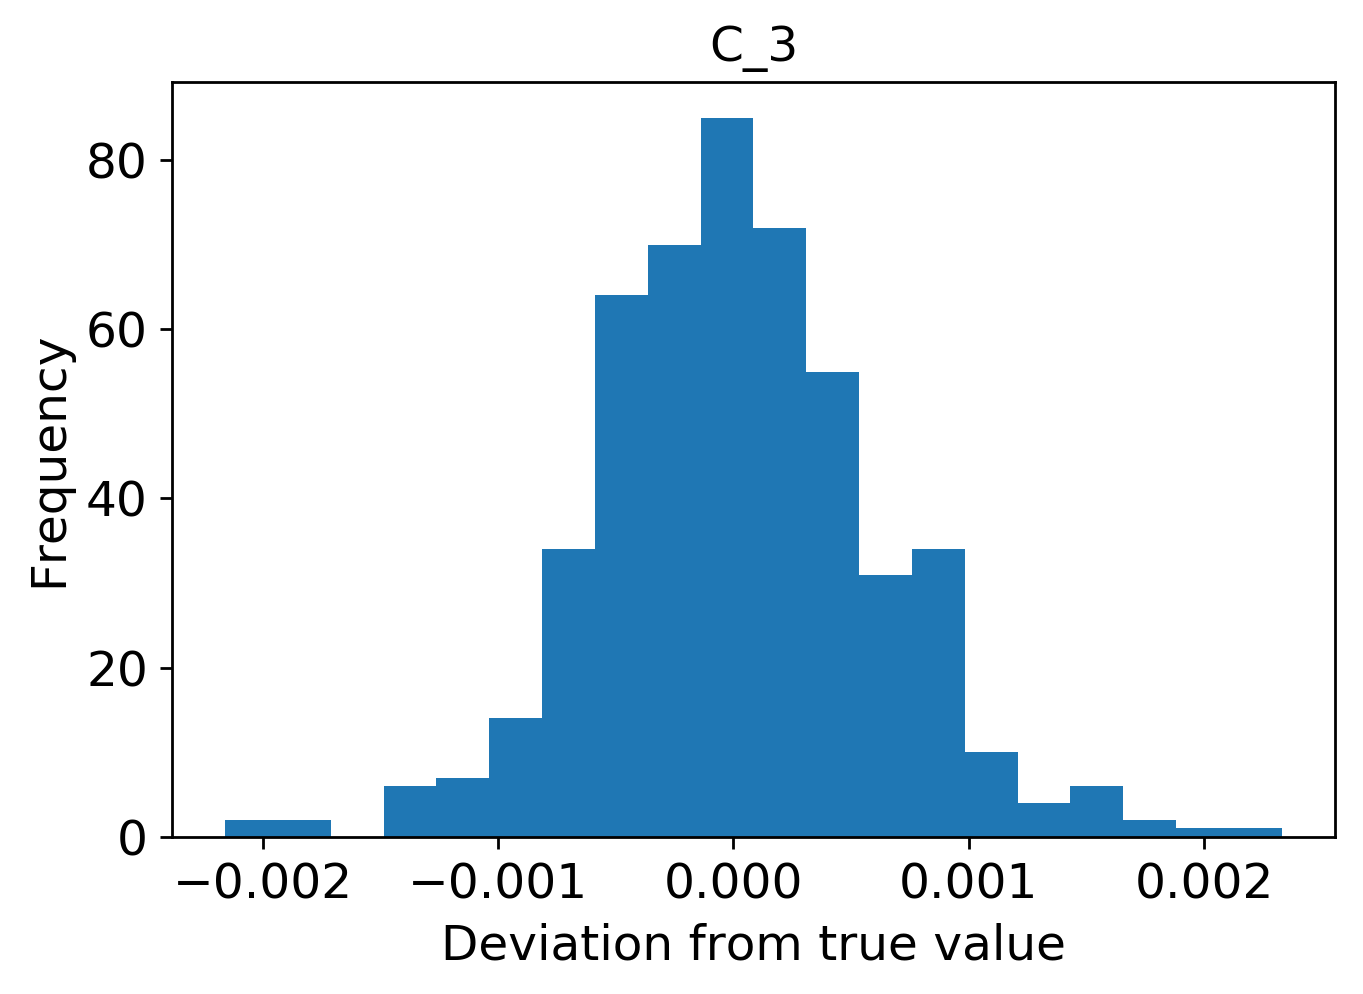

Standard Deviation: 0.0006176462431742816
Standard Deviation sample: 0.0006182648174336433
Mean: 0.00012805020718815213
CV: 4.828300016142796


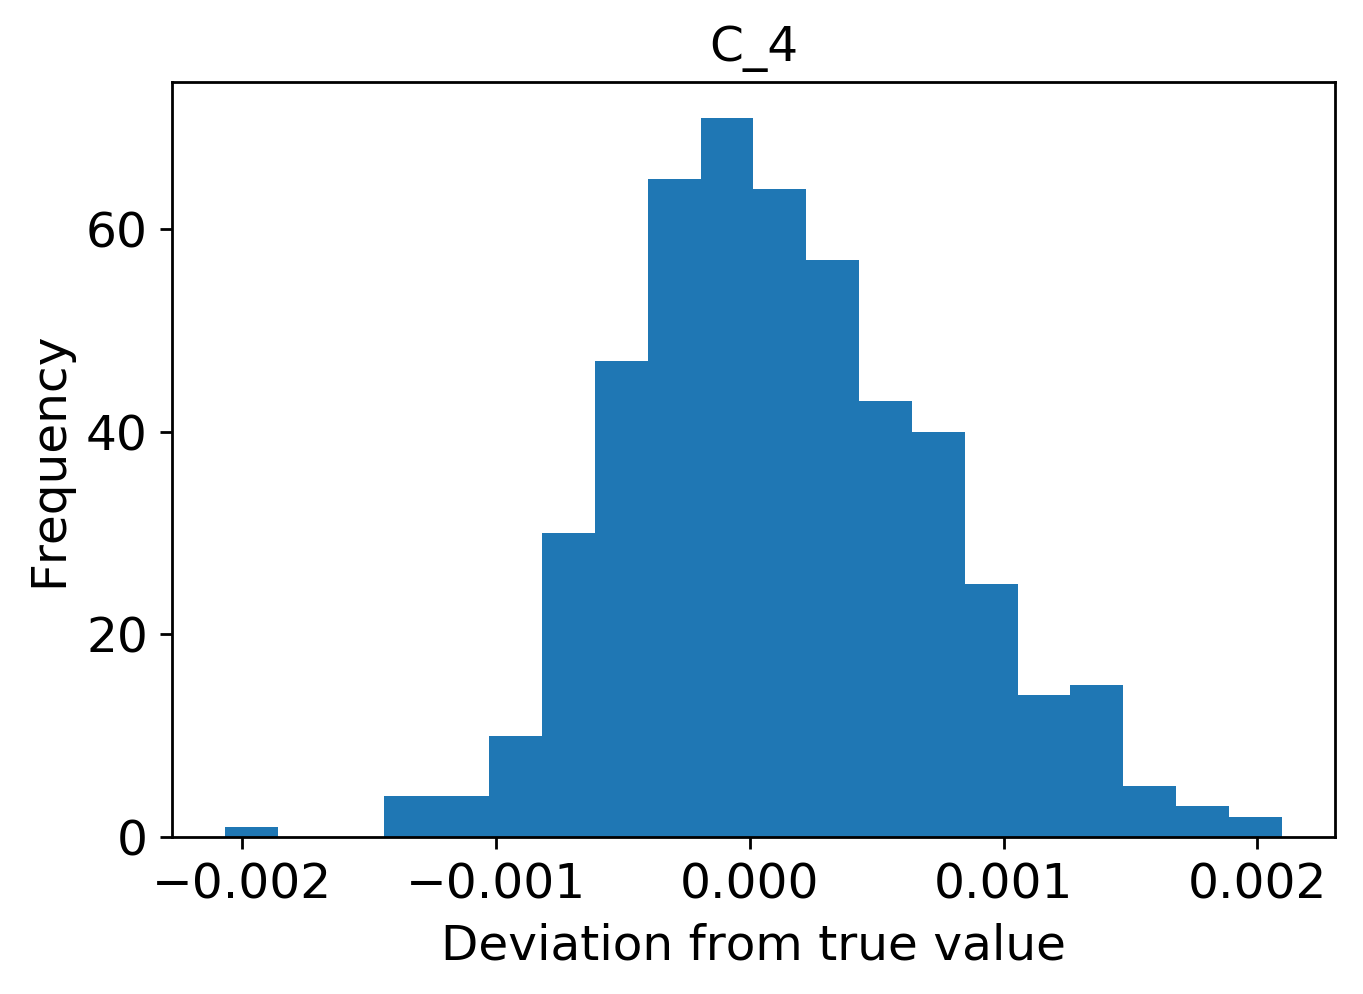

Standard Deviation: 0.0005965859609138759
Standard Deviation sample: 0.0005971834432478108
Mean: 0.0002154988395159406
CV: 2.7711677918508544


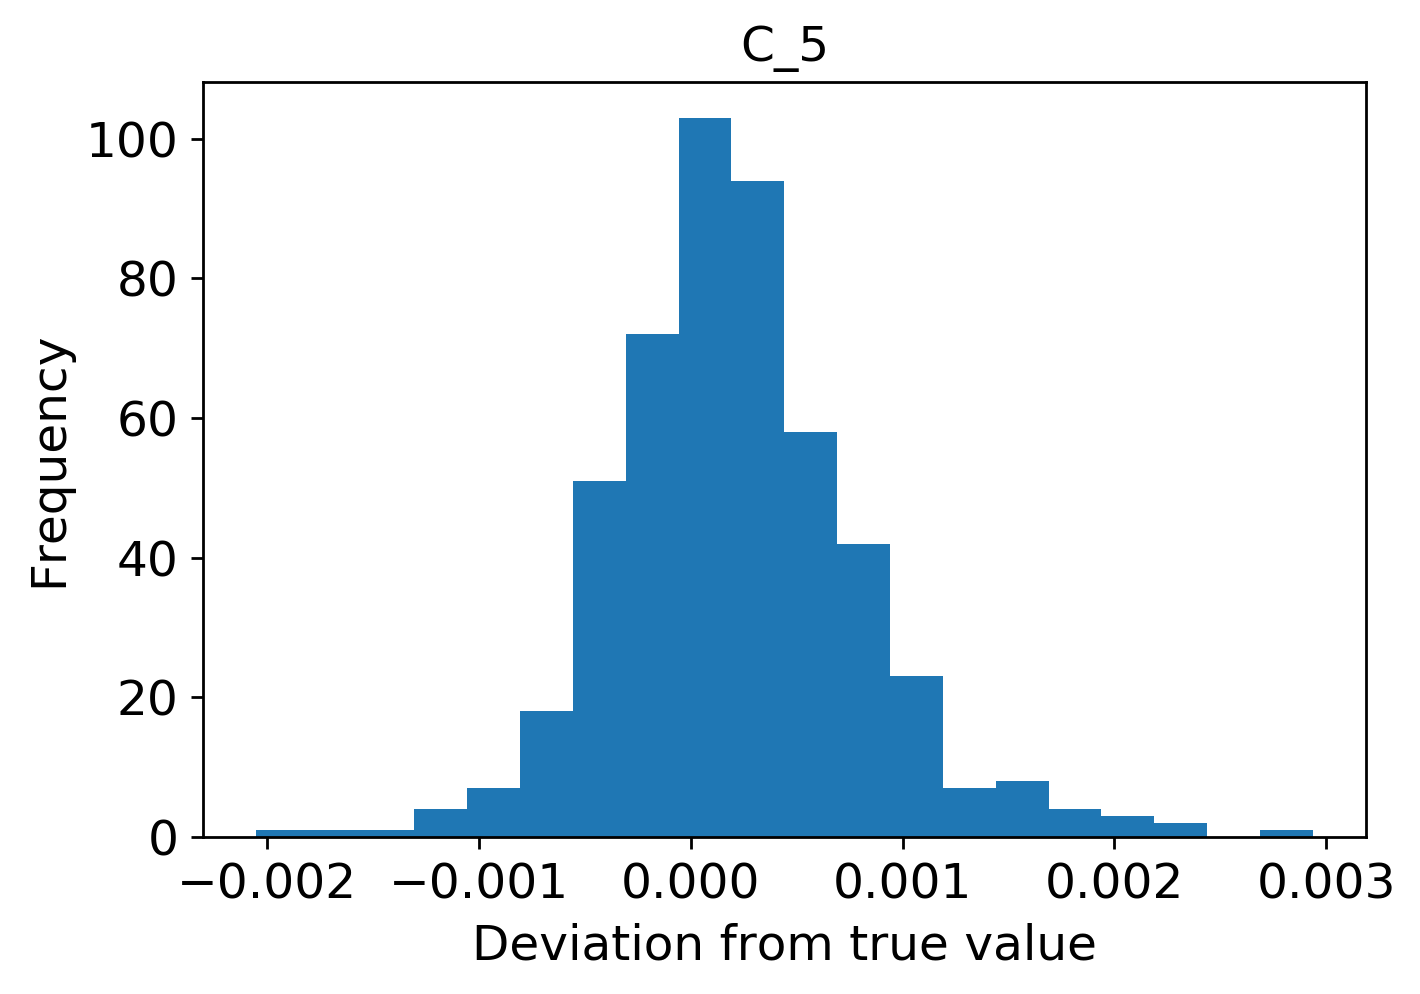

Standard Deviation: 0.0006399886338420712
Standard Deviation sample: 0.0006406295840616406
Mean: 0.00016304924851312598
CV: 3.9290557295029047


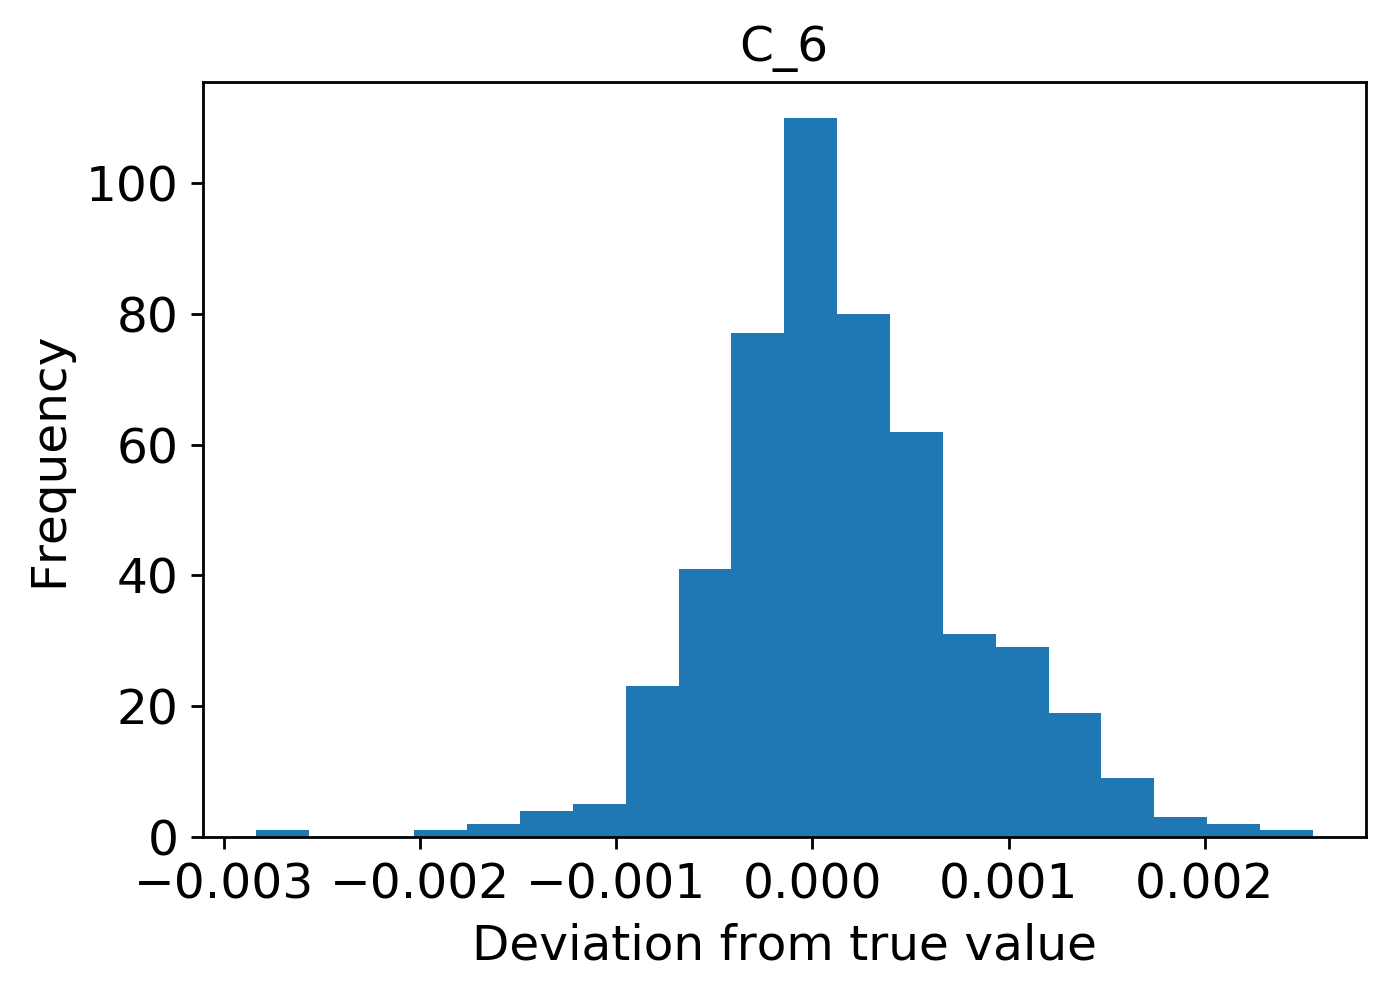

In [37]:
from scipy.stats import variation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

datadir = '/home/rimali2009/FITTNUSS-forward_training_DNN/data_g6_300grid_H_5000_20_11_roi2000_TC/'
resdir = '/home/rimali2009/FITTNUSS-forward_training_DNN/result_g6_300grid_H_5000_20_11_roi2000_TC/4500/'

test_result = np.loadtxt(resdir + 'test_result.txt',delimiter=',')
icond = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')
print(icond.shape)
resi = test_result - icond
titlelabel = ['Max Inundation Length','Flow Velocity', 'Max. Flow Depth', 'C_1', 'C_2', 'C_3', 'C_4','C_5','C_6']

for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.hist(resi[:,i],bins=20)
    print('Standard Deviation:', np.std(resi[:,i]))
    print('Standard Deviation sample:', np.std(resi[:,i],ddof=1))
    print('Mean:', np.mean(resi[:,i]))
    print('CV:', np.std(resi[:,i],ddof=1)/np.mean(resi[:,i]))                           
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('Deviation from true value',color=textcol,size=14,**hfont)
    plt.ylabel('Frequency',color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.eps')
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.pdf')
    plt.show()


# DNN Inverse model final result

       distance        g1        g2        g3        g4        g5        g6
0      0.000000  0.036771  0.167260  0.114845  0.008449  0.002190  0.005161
1    103.794102  0.000000  0.075200  0.153283  0.013753  0.001885  0.000442
2    171.620654  0.002130  0.051171  0.084309  0.006218  0.001867  0.002843
3    397.112167  0.003115  0.016359  0.078858  0.011466  0.000597  0.000054
4    595.912969  0.000732  0.016896  0.028720  0.002661  0.000914  0.000000
5    707.625749  0.000143  0.002228  0.005502  0.000900  0.000187  0.000104
6    796.435078  0.000236  0.004337  0.021204  0.003169  0.000309  0.000080
7    895.065500  0.001688  0.016059  0.081413  0.020284  0.006824  0.004628
8    988.394177  0.004567  0.008166  0.074658  0.016913  0.002424  0.001580
9   1081.819325  0.001567  0.016305  0.060234  0.011086  0.004165  0.001994
10  1195.756993  0.001022  0.002370  0.017565  0.004194  0.000567  0.000142
11  1290.372534  0.000000  0.004121  0.057974  0.014565  0.000426  0.000213
12  1400.896

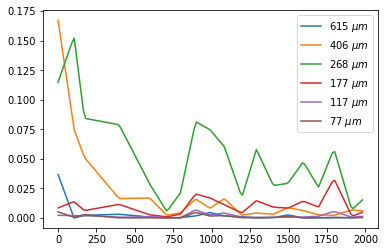

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy import stats
from scipy.interpolate import interp1d 
import pandas as pd
from pykrige import OrdinaryKriging as OK
import ipdb


datadir = '/home/rimali2009/FITTNUSS-forward_training_DNN/data_g6_300grid_H_5000_20_11_roi2000_TC/'
resdir = '/home/rimali2009/FITTNUSS-forward_training_DNN/result_g6_300grid_H_5000_20_11_roi2000_TC/4500/'
#Initial setting
if not "model" in locals(): 
    model = load_model(resdir+'model3.hdf5')
#gclass = 3
#gclass_label = ["500 $\mu$m","125 $\mu$m","63 $\mu$m"]
gclass = 6
gclass_label = ["615 ${\mu}m$","406 ${\mu}m$","268 ${\mu}m$","177 ${\mu}m$", "117 ${\mu}m$","77 ${\mu}m$"]
topodx = 15.0
coord_num = int(model.layers[0].input_shape[1]/gclass)

#Acquires a value for normalizing input data to [0, 1]
min_x, max_x = np.loadtxt(datadir + 'x_minmax.txt',delimiter=',')
y_min = np.loadtxt(datadir + 'icond_min.txt',delimiter=',')
y_max = np.loadtxt(datadir + 'icond_max.txt',delimiter=',')

#Read outcrop data
#dist_max = 22000. #Distance of distal end of learning data
outcrop = pd.read_csv('../FITTNUSS-forward_training_DNN/sendai_increased_class_edit.csv')
#outcrop = pd.read_csv('../DeepLearningTurbidite_Fukuda/GA_naruse_v2.csv')
#outcrop = outcrop.append(pd.DataFrame([[0,'Loc0',0,0,0],[dist_max,'LocE',0,0,0]], columns=outcrop.columns))
outcrop = outcrop.sort_values('distance')
outcrop['distance'] = outcrop['distance'] - 0
#d = pd.DataFrame(np.zeros((1, 7)),columns=['distance', 'g1','g2','g3','g4','g5','g6'])
#print(d)
#v=np.concatenate((outcrop, d))
#print(v)
#outcrop=pd.DataFrame(v,columns=['distance', 'g1','g2','g3','g4','g5','g6'])
#outcrop['distance'].iloc[-1]=4000
#outcrop = outcrop.append(pd.DataFrame([[0,'Loc0',0,0,0,0]], columns=outcrop.columns))
print(outcrop)

#Preparation under interpolation
thick_interp = np.zeros([1,coord_num*gclass])#補間されたサンプル厚さデータ
outcrop_x_id = np.round(outcrop['distance']/topodx).astype(np.int32) #逆解析システムでのサンプリング地点のindex番号
x = np.arange(0,coord_num*topodx,topodx)

#Complement data
for j in range(gclass):
    f = interp1d(outcrop['distance'],outcrop.iloc[:,j+1], kind="linear",bounds_error=False,fill_value='extrapolate')
    #f = interp1d(outcrop['distance'],outcrop.iloc[:,j+2], kind="linear",bounds_error=False,fill_value='extrapolate') 
    #Interpolation function of jth granularity level
    thick_interp[0,coord_num*j:coord_num*(j+1)] = f(x) #Supplemented data

#ipdb.set_trace()
#Kriging Interpolation by
#vparams = np.array([[0.035, 10000., 0.001],[0.006, 10000., 0.002],[0.005, 10000., 0.002],[0.035, 10000., 0.001]])
#for j in range(gclass):
    #okip = OK(outcrop['distance'],np.zeros(outcrop['distance'].shape),outcrop.iloc[:,j+1],variogram_model='linear',)
    #okip.display_variogram_model()
    #ipdata, ipstd = okip.execute('grid',x,np.array([0.]))
    #ipdata = np.squeeze(ipdata)
    #thick_interp[0,coord_num*j:coord_num*(j+1)] = ipdata #Assign complemented d

#Normalize data
thick_interp[thick_interp < 0] = 0
thick_interp_norm =  (thick_interp - min_x) / (max_x - min_x)

#Perform inverse analysis
test_result_outcrop = model.predict(thick_interp_norm)
test_result_outcrop = test_result_outcrop * (y_max - y_min) + y_min
print(test_result_outcrop)
#add=np.array(3000)
#test_result_outcrop_add=np.concatenate((add,test_result_outcrop), axis=None)
#Output results
#print(test_result_outcrop_add)
np.savetxt('outcrop_result_g6_g300_H_5000_20_11_roi2000_TC.txt',test_result_outcrop, delimiter=',')
for i in range(len(gclass_label)):
    plt.plot(x,thick_interp[0,coord_num * i:coord_num * (i+1)],label=gclass_label[i])
plt.legend()
plt.show()



# Thickness

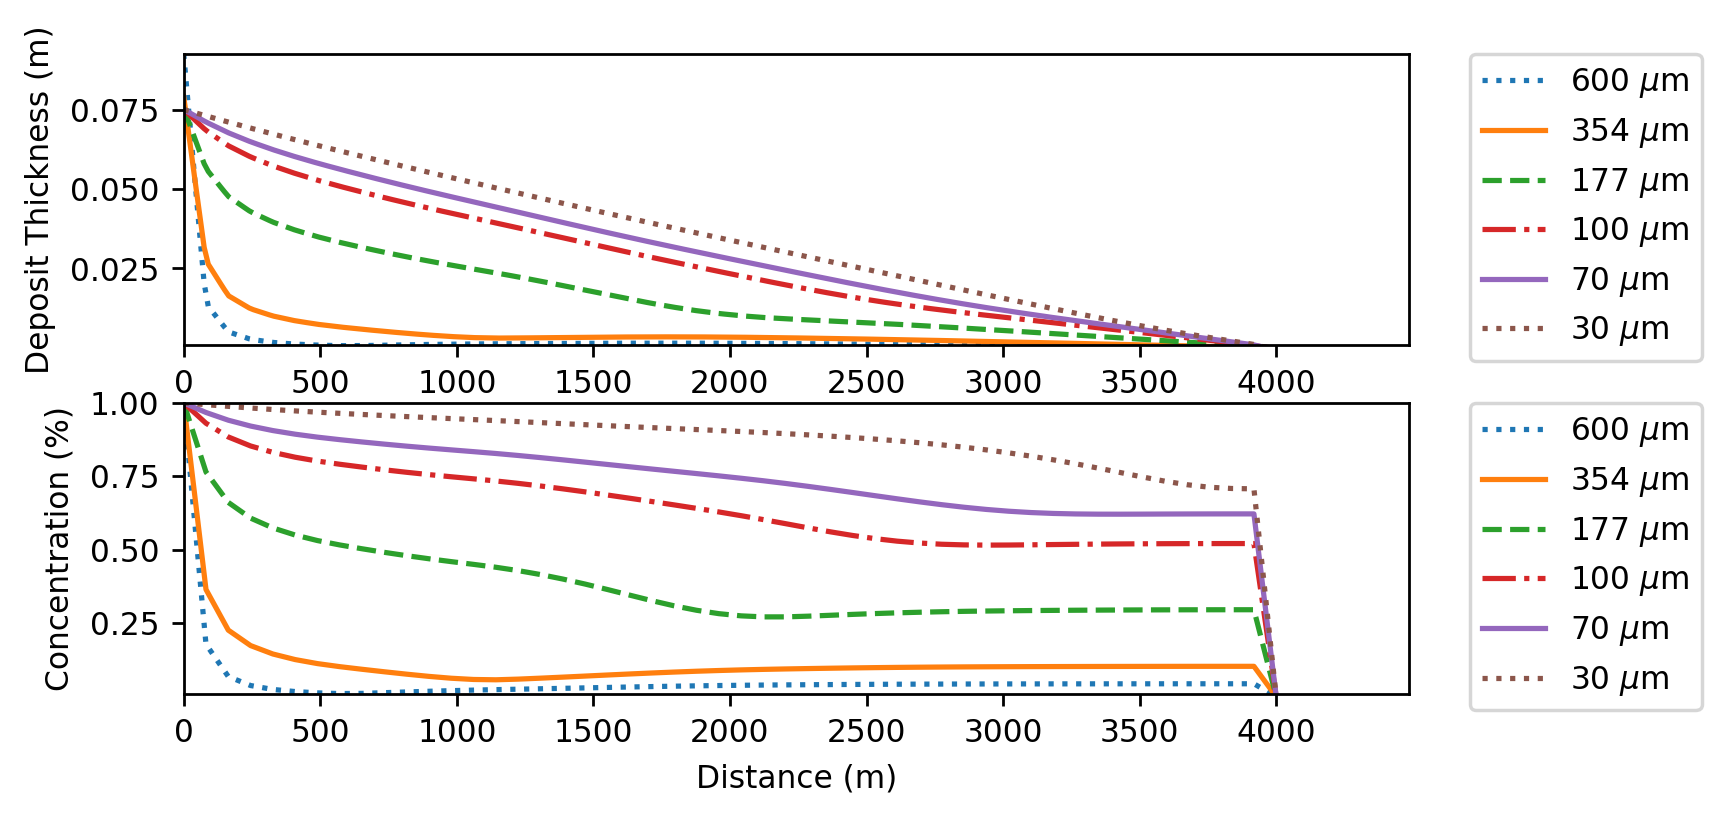

(5000, 9)
(5000, 1800)


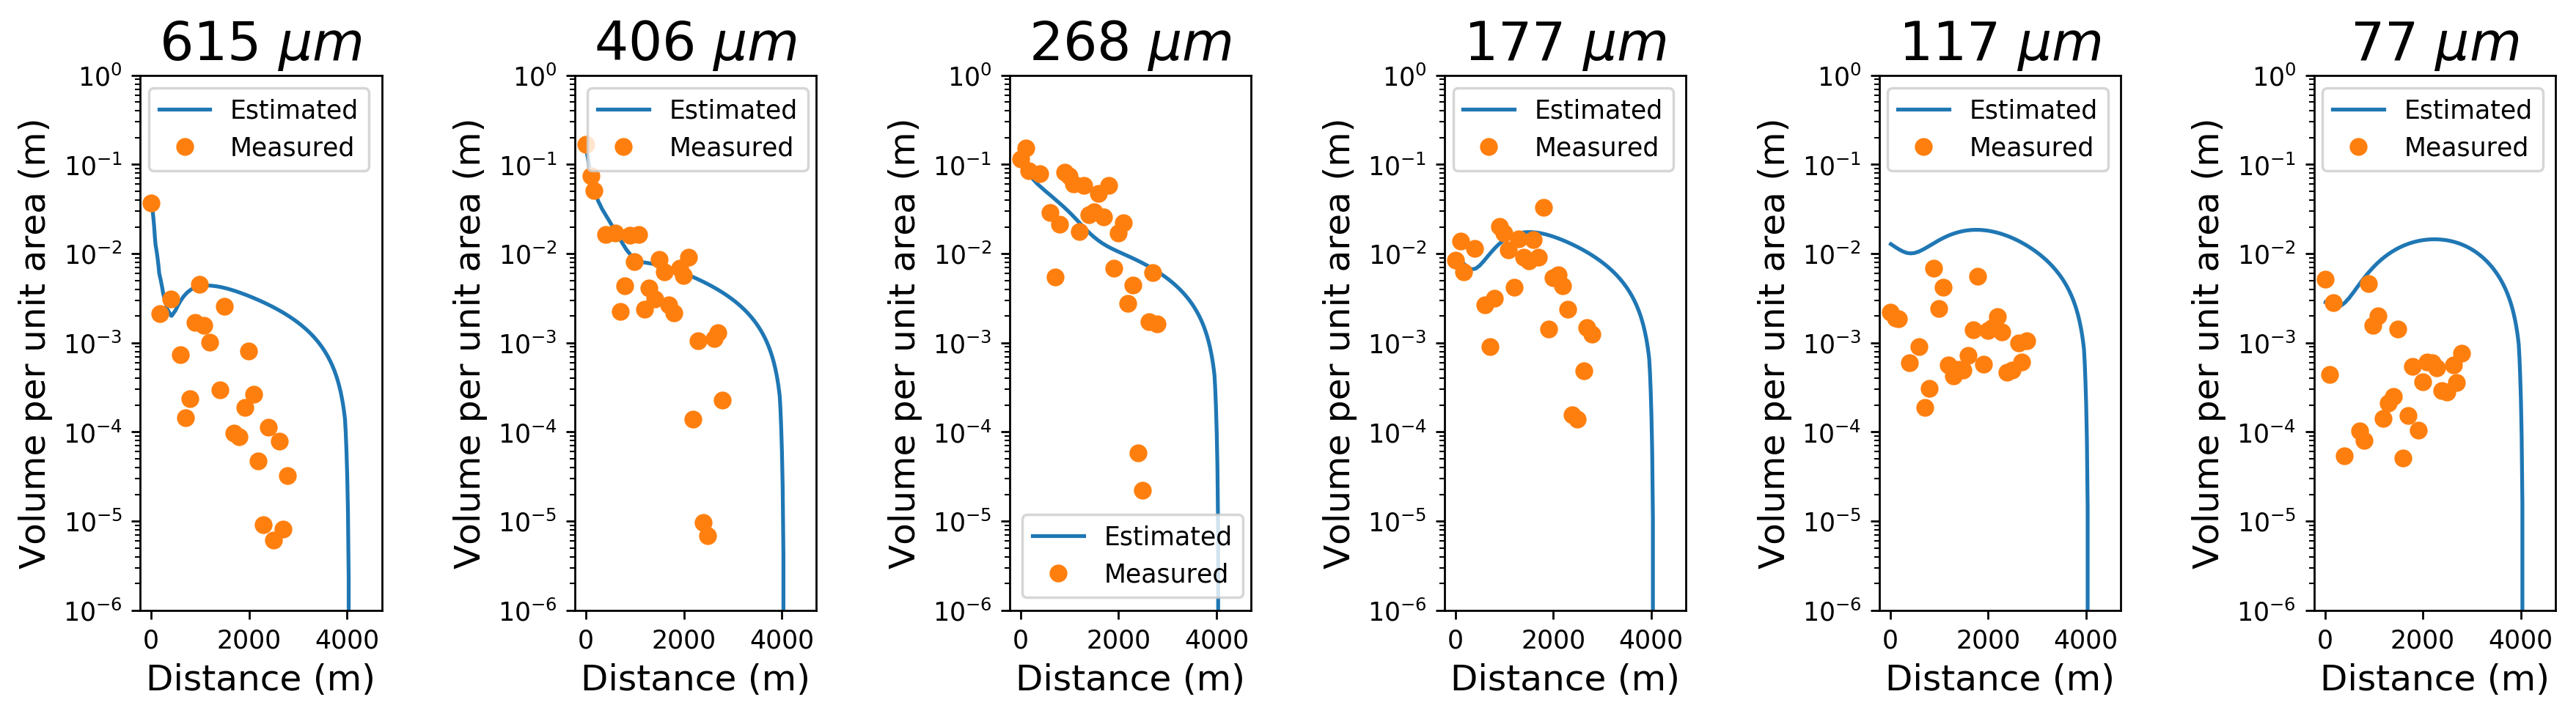

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Forward_model_modified_FITTNUSS_5000_g6_300grid_19_11_case2 as fmodel
import time
import ipdb
%matplotlib inline

#Basic setting

#dist_max = 3000.
gclass = 6
topodx=15.0
gclass_name = ['615microm','406microm','268microm','177microm','117microm','77microm']
#gclass_name = ['500micron', '125micron', '63micron']
gname_tex = ["615 ${\mu}m$","406 ${\mu}m$","268 ${\mu}m$","177 ${\mu}m$", "117 ${\mu}m$","77 ${\mu}m$"]
#gname_tex = ['500 $\mu$m','125 $\mu$m','63 $\mu$m']
#calcdir = 'home/rimali2009/FITTNUSS-forward_training_DNN/'
#calcdir = '/home/naruse/Documents/Documents/MATLAB/TCtrainData_forML/TCModel_for_MLTEST/test_output_otadai07/'

#Load estimate
#H1 = np.loadtxt(calcdir + 'H1.txt',delimiter=',')
#H2 = np.loadtxt(calcdir + 'H2.txt',delimiter=',')
#H3 = np.loadtxt(calcdir + 'H3.txt',delimiter=',')
#H4 = np.loadtxt(calcdir + 'H4.txt',delimiter=',')
#Ht = np.loadtxt(calcdir + 'Ht.txt',delimiter=',')
#U = np.loadtxt(calcdir + 'U.txt',delimiter=',')
#xi = np.loadtxt(calcdir + 'xi.txt',delimiter=',')
#x = np.loadtxt(calcdir + 'x.txt',delimiter=',')
#x_bed = np.loadtxt(calcdir + 'x_init.txt',delimiter=',')
#eta_init = np.loadtxt(calcdir + 'eta_init.txt',delimiter=',')
#Ct = np.loadtxt(calcdir + 'Ct.txt',delimiter=',')
#time = np.loadtxt(calcdir + 'time.txt',delimiter=',')
estimated_icond=np.loadtxt('outcrop_result_g6_g300_H_5000_20_11_roi2000_TC.txt', delimiter=',')
start = time.time()
fmodel.read_setfile("config_g6_300grid_19_11_case2.ini")
(x,C,x_dep,deposit) = fmodel.forward(estimated_icond)
np.savetxt('eta_estimated_thickness_5K_g6_TC4_Rwcnst_H_5000_20_11_roi2000.csv', deposit, delimiter=',')
np.savetxt('eta_estimated_Distance_5K_g6_TC4_Rwcnst_H_5000_20_11_roi2000.csv', x_dep,delimiter=',')
estimated_dep_thickness_5000=np.transpose(np.loadtxt('/home/rimali2009/FITTNUSS-forward_training_DNN/'+'eta_estimated_thickness_5K_g6_TC4_Rwcnst_H_5000_20_11_roi2000.csv', delimiter=','))
estimated_dep_thickness_5000=pd.DataFrame(estimated_dep_thickness_5000,columns=['615microm','406microm','268microm','177microm','117microm','77microm'])
estimated_dep_distance_5000=np.transpose(np.loadtxt('/home/rimali2009/FITTNUSS-forward_training_DNN/'+'eta_estimated_Distance_5K_g6_TC4_Rwcnst_H_5000_20_11_roi2000.csv', delimiter=','))
estimated_dep_distance_5000=pd.DataFrame(estimated_dep_distance_5000,columns=['distance'])
estimated_dep_5000=pd.concat([estimated_dep_distance_5000,estimated_dep_thickness_5000],axis=1)
np.savetxt('estimated_dep_5K_g6_TC4_Rwcnst_H_5000_20_11_roi2000.csv',estimated_dep_5000,delimiter=',')
#data_estim=pd.DataFrame(estimated_dep_5000,columns=['distance','1.5phi','2.5phi','3.5phi','4.5phi'])

#Formatting the loaded data
#estimated_dep_df = pd.DataFrame(estimated_dep,columns=['distance','1.5phi','2.5phi','3.5phi','4.5phi'])
#estimated_dep = pd.DataFrame(np.array([x_bed - dist_offset,H1[-1,:],H2[-1,:],H3[-1,:]]).T,columns=['distance','500micron','125micron','63micron'])
estimated_dep_5000= estimated_dep_5000.query('distance > 0')
#estimated_dep_5000 = estimated_dep_5000.query('distance < {}'.format(dist_max))

#Read original data
outcrop = pd.read_csv('../FITTNUSS-forward_training_DNN/sendai_increased_class.csv')
outcrop= pd.DataFrame(outcrop,columns=['distance','615microm','406microm','268microm','177microm','117microm','77microm'])
#outcrop = pd.read_csv('../DeepLearningTurbidite_Fukuda/GA_naruse_v2.csv')
#outcrop = outcrop.append(pd.DataFrame([[0,'Loc0',0,0,0],[dist_max,'LocE',0,0,0]], columns=outcrop.columns))
#outcrop = outcrop.sort_values('distance')
#outcrop['distance'] = outcrop['distance'] - 1000

#Plot
plt.figure(num=None, figsize=(17, 4), dpi=250, facecolor='w', edgecolor='g')
hfont = {'fontname':'Sans'}
plt.subplots_adjust(bottom=0.15, wspace=0.8)

for i in range(gclass):
    plt.subplot(1,gclass,i+1)
    plt.plot(estimated_dep_5000['distance'],estimated_dep_5000[gclass_name[i]],'-', label='Estimated')
    plt.plot(outcrop['distance'], outcrop[gclass_name[i]],'o', label='Measured')
    plt.yscale('log')
    plt.ylim([0.000001,1])
    plt.title(gname_tex[i], size=21,**hfont)
    plt.xlabel('Distance (m)', size = 14, **hfont)
    plt.ylabel('Volume per unit area (m)', size = 14, **hfont)
    plt.legend(fontsize=10)
    plt.savefig("thickness_distance_curve_5000_g6_300grid_H_5000_20_11_roi2000.png")
    plt.savefig("thickness_distance_curve_5000_g6_300grid_H_5000_20_11_roi2000.eps")
    plt.savefig("thickness_distance_curve_5000_g6_300grid_H_5000_20_11_roi2000.pdf")
plt.show()



# Jackknife and Jackknife Standard error

Using TensorFlow backend.


       distance        g1        g2        g3        g4        g5        g6
0      0.000000  0.036771  0.167260  0.114845  0.008449  0.002190  0.005161
1    103.794102  0.000000  0.075200  0.153283  0.013753  0.001885  0.000442
2    171.620654  0.002130  0.051171  0.084309  0.006218  0.001867  0.002843
3    397.112167  0.003115  0.016359  0.078858  0.011466  0.000597  0.000054
4    595.912969  0.000732  0.016896  0.028720  0.002661  0.000914  0.000000
5    707.625749  0.000143  0.002228  0.005502  0.000900  0.000187  0.000104
6    796.435078  0.000236  0.004337  0.021204  0.003169  0.000309  0.000080
7    895.065500  0.001688  0.016059  0.081413  0.020284  0.006824  0.004628
8    988.394177  0.004567  0.008166  0.074658  0.016913  0.002424  0.001580
9   1081.819325  0.001567  0.016305  0.060234  0.011086  0.004165  0.001994
10  1195.756993  0.001022  0.002370  0.017565  0.004194  0.000567  0.000142
11  1290.372534  0.000000  0.004121  0.057974  0.014565  0.000426  0.000213
12  1400.896

(1, 9)
[[3.82399569e+03 5.26405067e+00 4.34849055e+00 5.53334306e-03
  2.14810503e-02 1.87598513e-02 9.62696270e-04 1.61178622e-03
  1.00773694e-04]]
       distance        g1        g2        g3        g4        g5        g6
0      0.000000  0.036771  0.167260  0.114845  0.008449  0.002190  0.005161
1    103.794102  0.000000  0.075200  0.153283  0.013753  0.001885  0.000442
2    171.620654  0.002130  0.051171  0.084309  0.006218  0.001867  0.002843
3    397.112167  0.003115  0.016359  0.078858  0.011466  0.000597  0.000054
4    595.912969  0.000732  0.016896  0.028720  0.002661  0.000914  0.000000
5    707.625749  0.000143  0.002228  0.005502  0.000900  0.000187  0.000104
6    796.435078  0.000236  0.004337  0.021204  0.003169  0.000309  0.000080
7    988.394177  0.004567  0.008166  0.074658  0.016913  0.002424  0.001580
8   1081.819325  0.001567  0.016305  0.060234  0.011086  0.004165  0.001994
9   1195.756993  0.001022  0.002370  0.017565  0.004194  0.000567  0.000142
10  1290.37253

/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


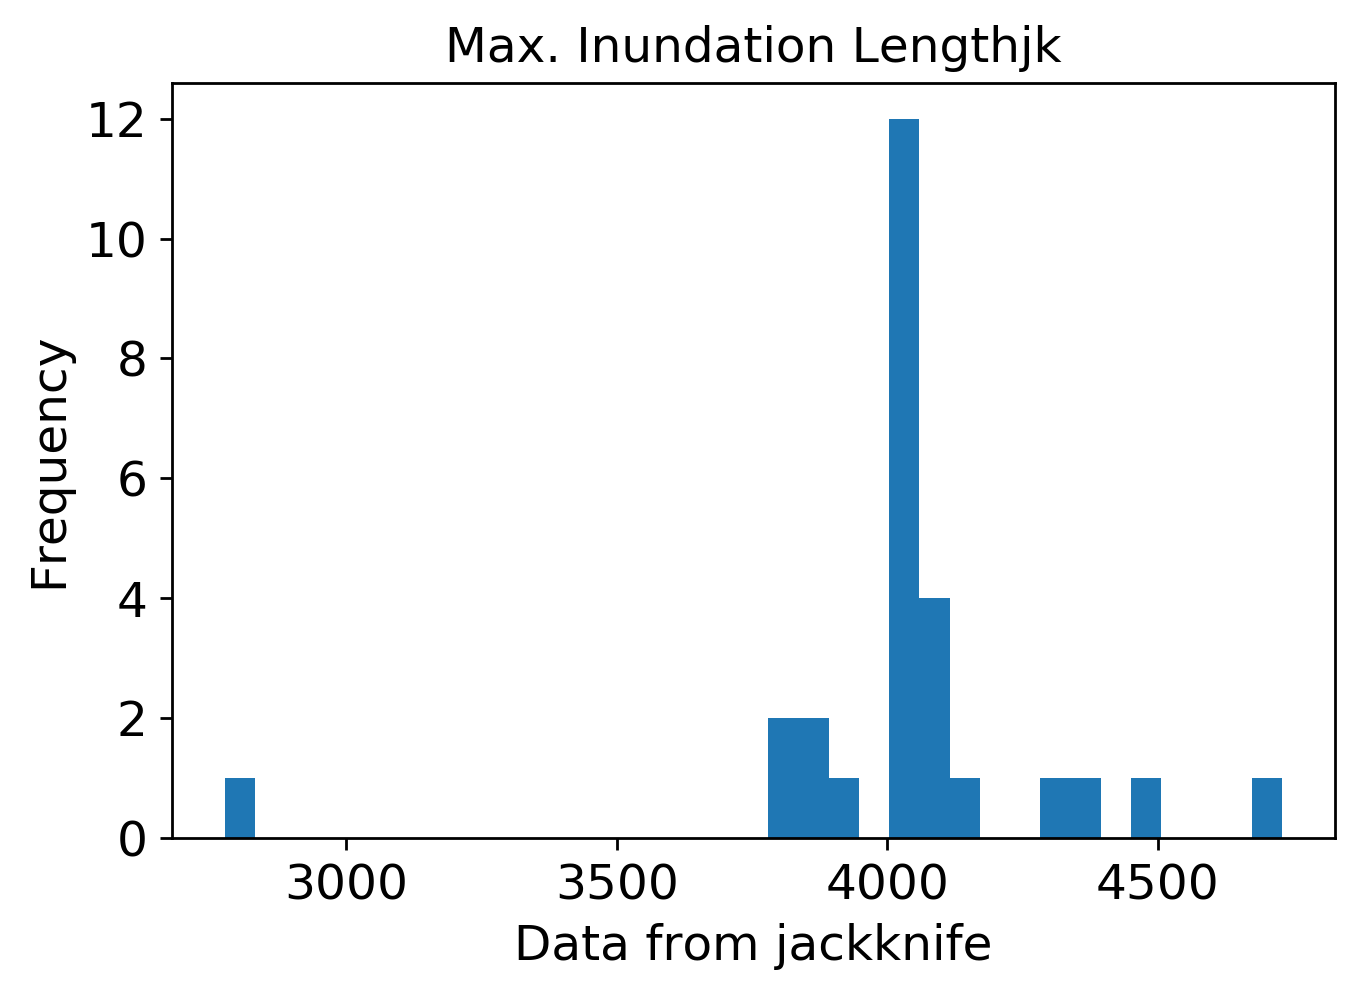

mean: 5.395284469698576
jk_e: 0.07143688264121595
CI 0.14001628997678325


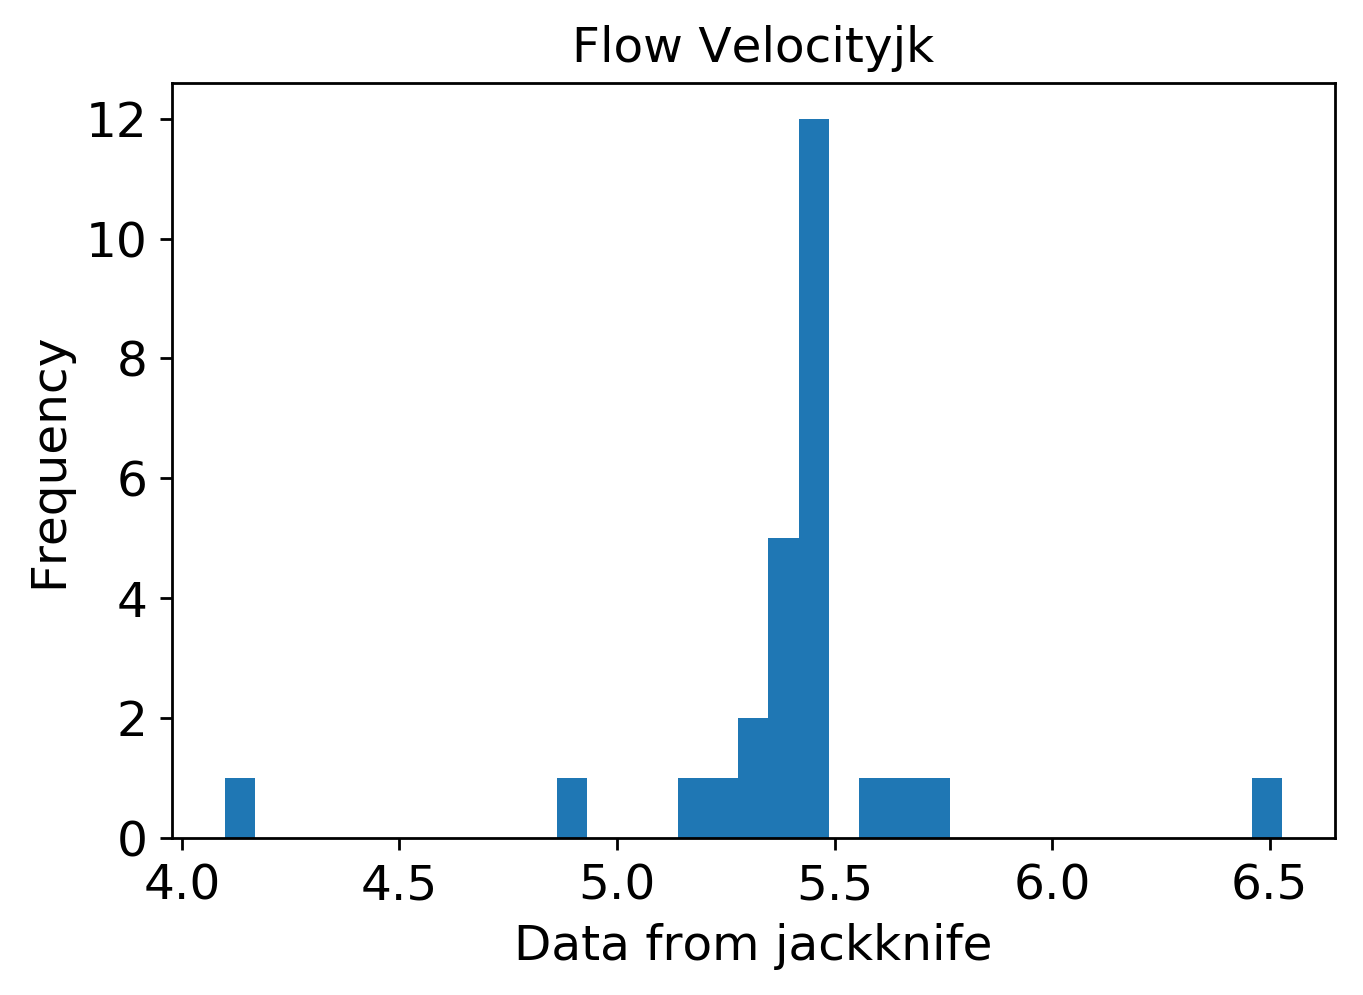

mean: 4.20869746578995
jk_e: 0.07786210130781157
CI 0.15260971856331068


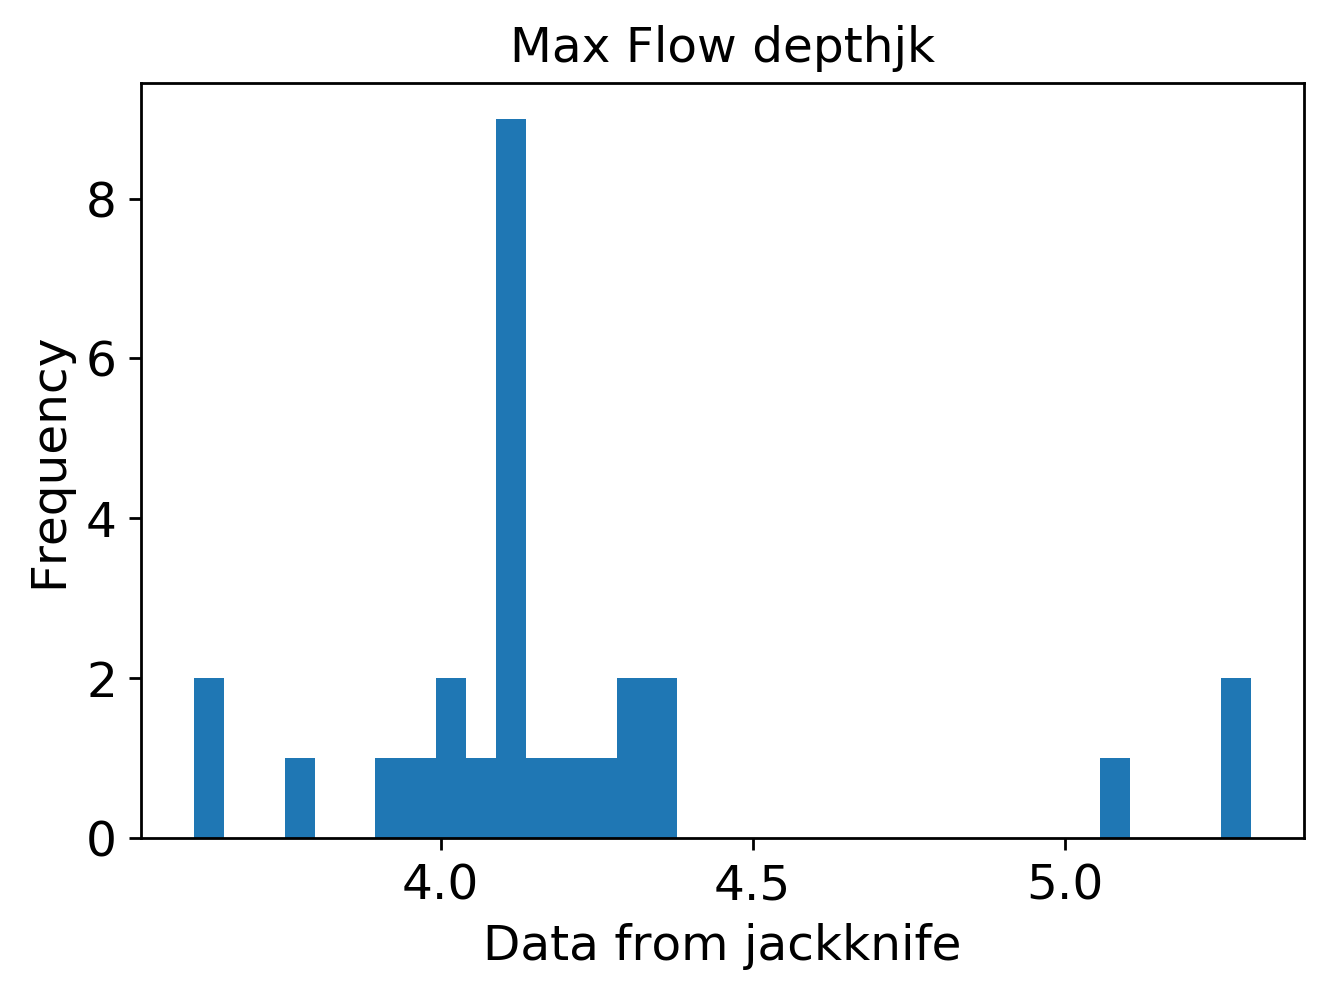

mean: 0.0054591630546772995
jk_e: 0.00017835630098215121
CI 0.0003495783499250164


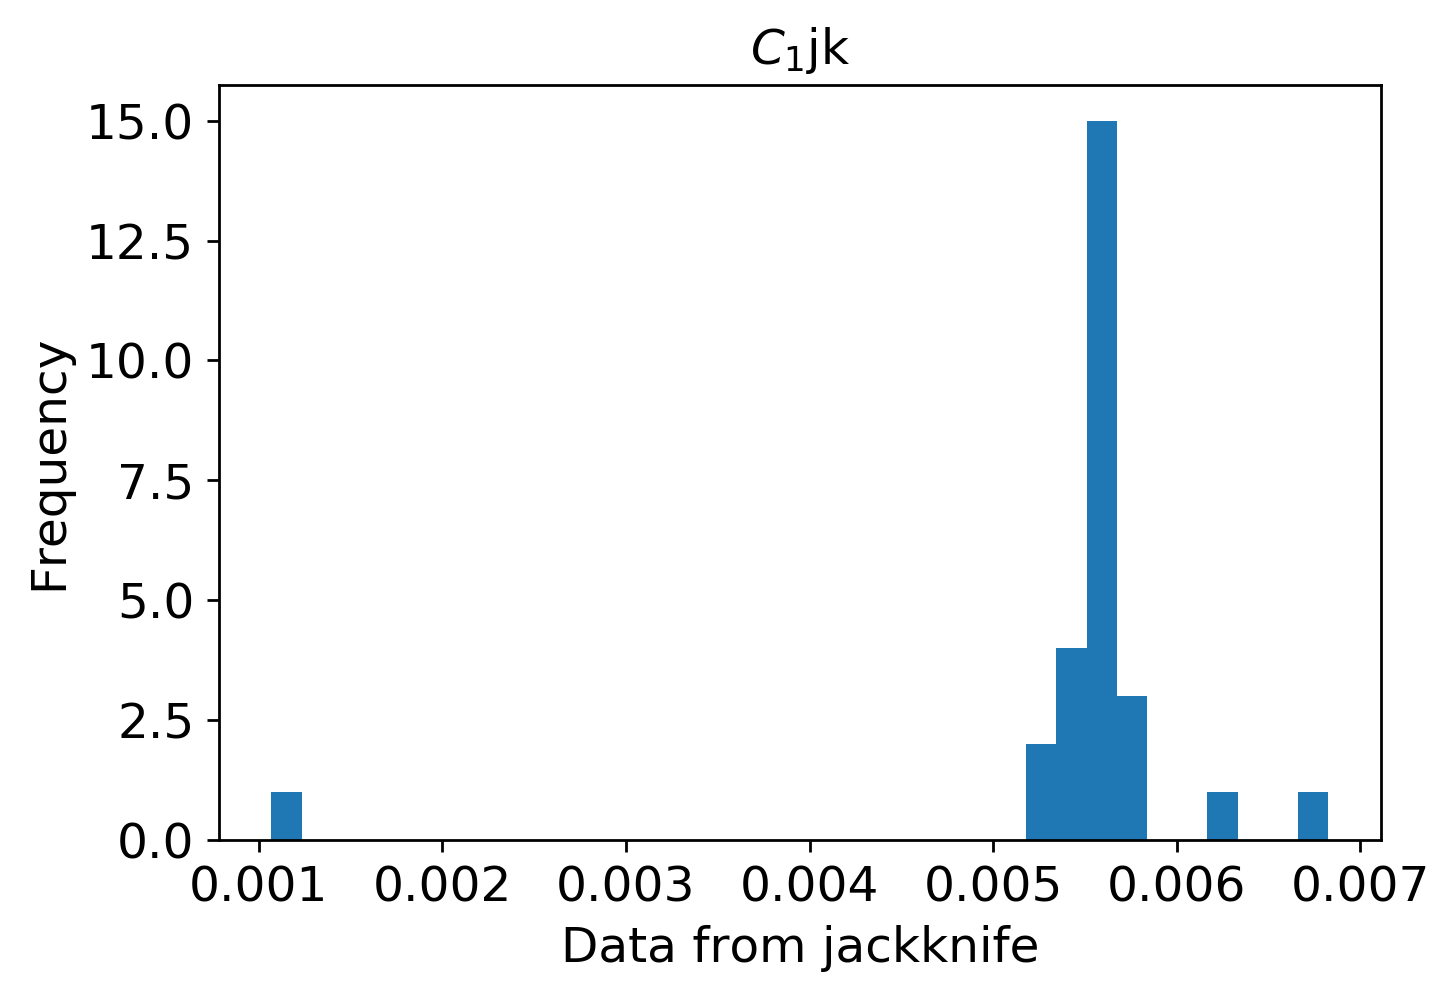

mean: 0.02163167444969545
jk_e: 0.0002450912917456105
CI 0.0004803789318213965


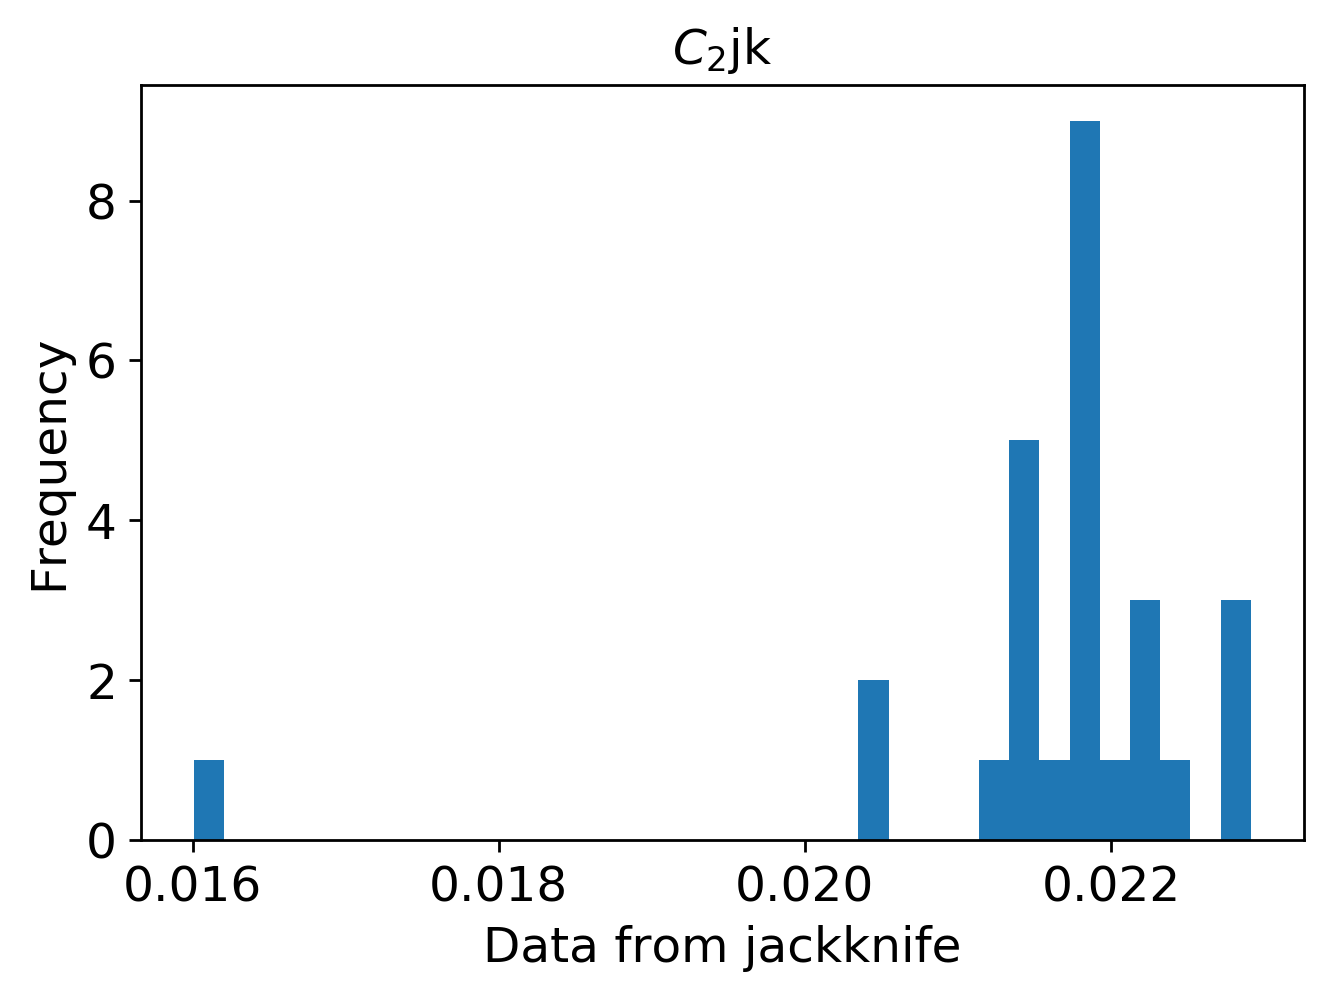

mean: 0.01993444773807034
jk_e: 0.0002980135517682979
CI 0.0005841065614658639


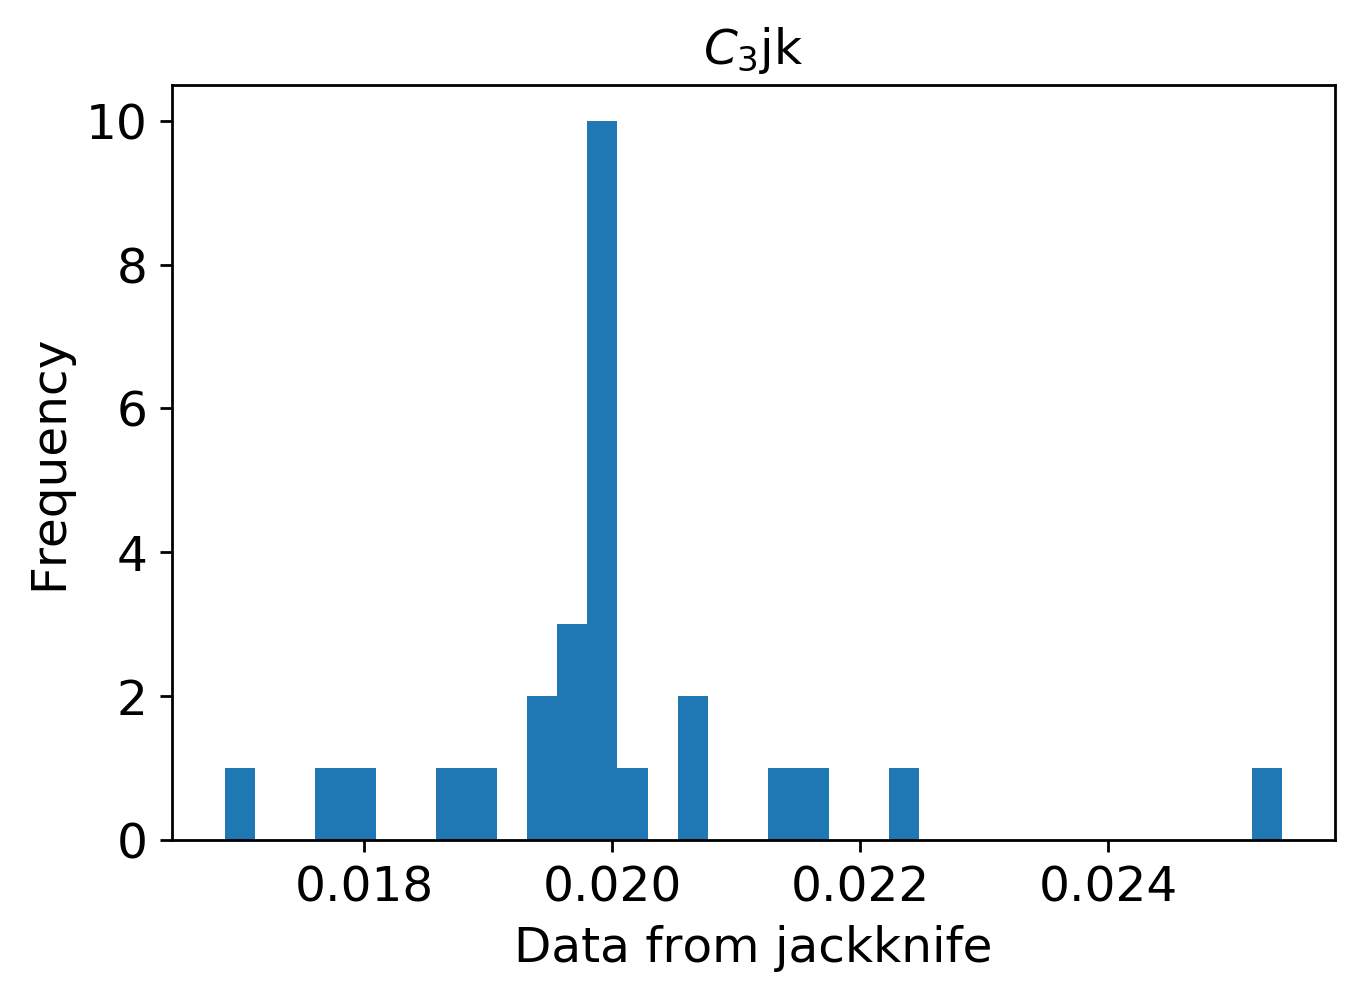

mean: 0.001541017831320409
jk_e: 9.481107584130348e-05
CI 0.00018582970864895482


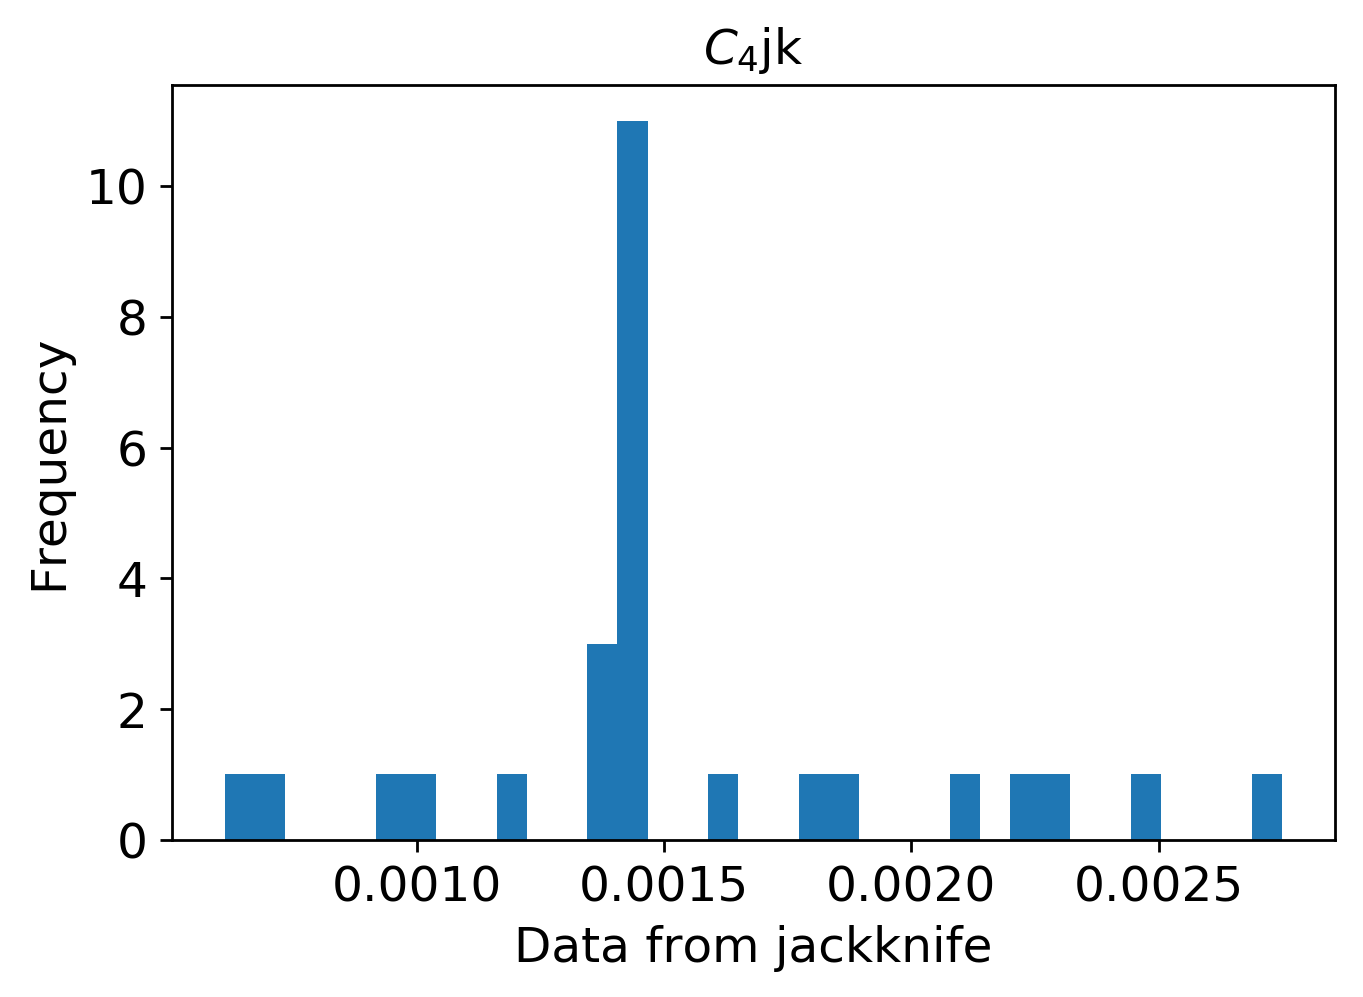

mean: 0.0018359567008321158
jk_e: 6.594907819616897e-05
CI 0.00012926019326449118


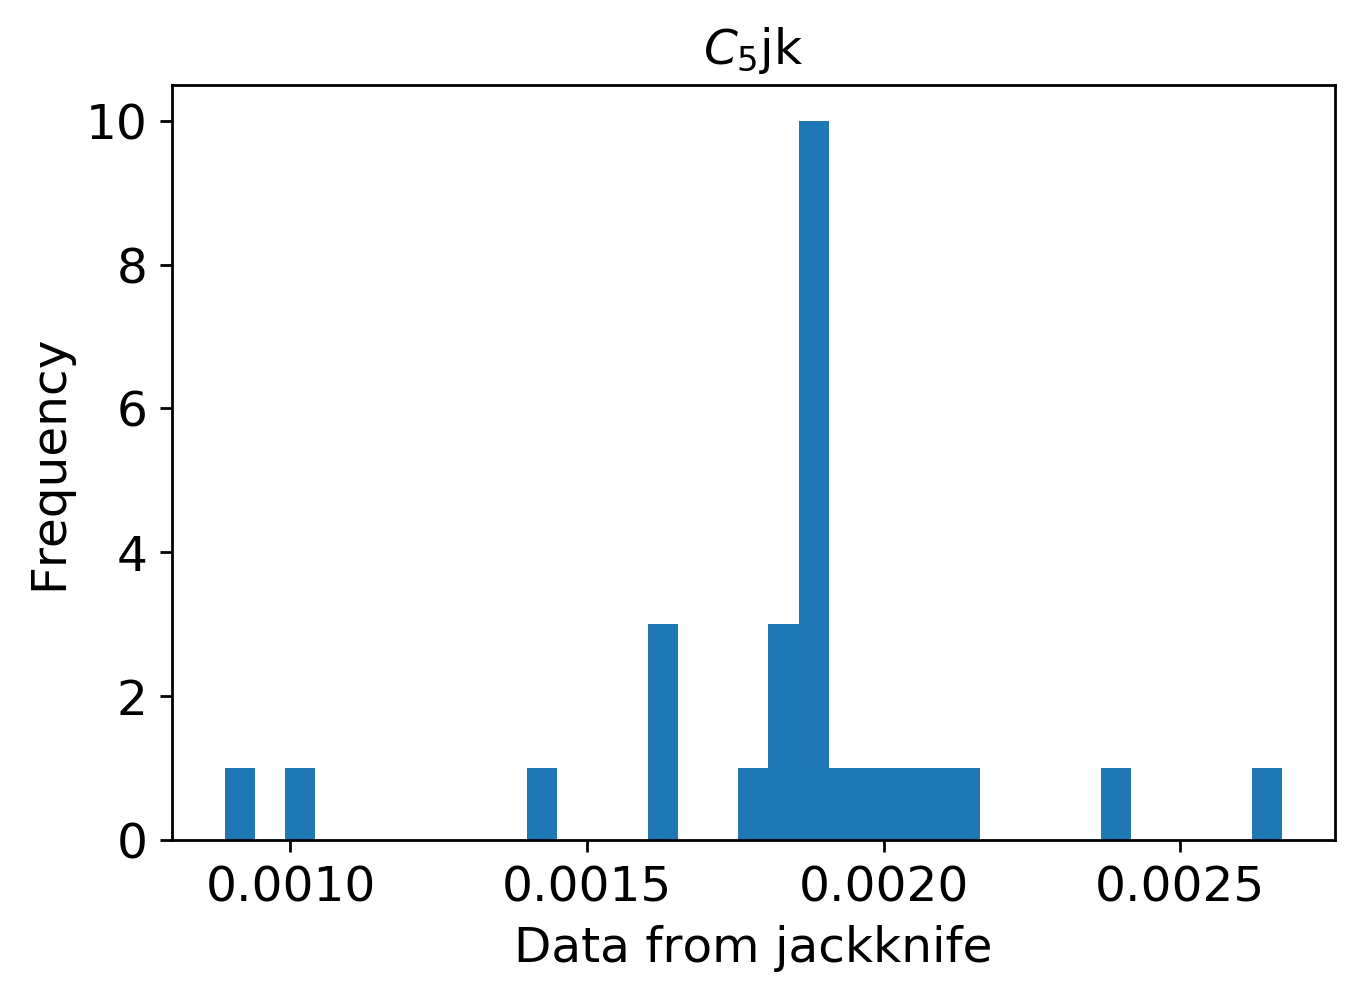

mean: 0.0004872169823548636
jk_e: 5.7456060702446006e-05
CI 0.00011261387897679417


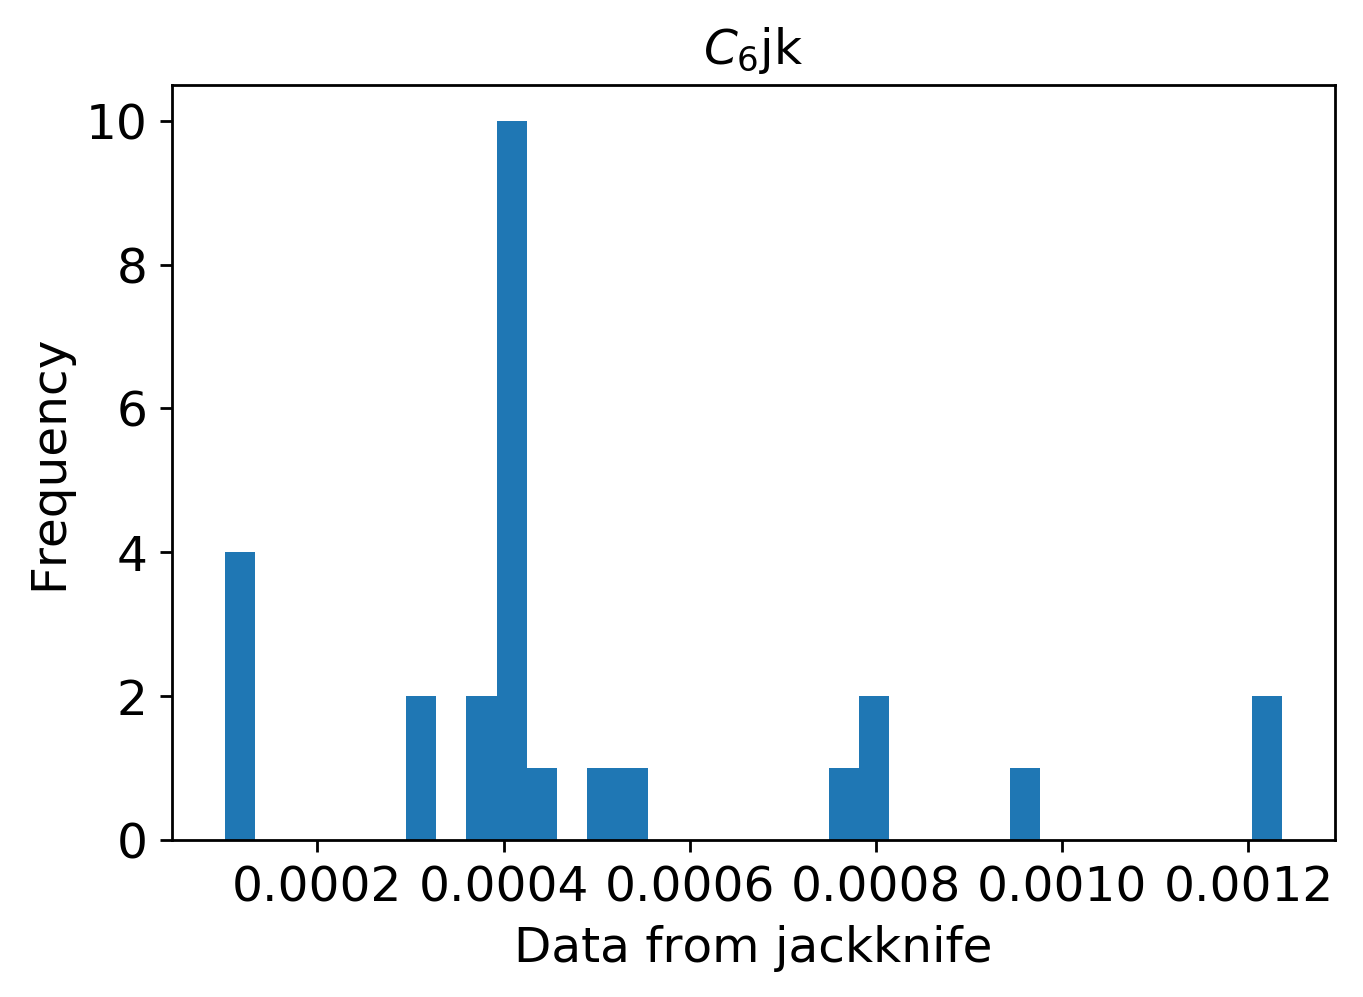

In [1]:
# Jackknife Method
import csv
import numpy as np
import pandas as pd
import math
from keras.models import load_model
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

datadir = '/home/rimali2009/FITTNUSS-forward_training_DNN/data_g6_300grid_H_5000_20_11_roi2000_TC/'
resdir = '/home/rimali2009/FITTNUSS-forward_training_DNN/result_g6_300grid_H_5000_20_11_roi2000_TC/4500/'
# Initial setting
if not "model" in locals():
    model = load_model(resdir+'model3.hdf5')
gclass = 6
gclass_label = ["615 ${\mu}m$", "406 ${\mu}m$", "268 ${\mu}m$",
                "177 ${\mu}m$", "117 ${\mu}m$", "77 ${\mu}m$"]
topodx = 15.0
coord_num = int(model.layers[0].input_shape[1]/gclass)
min_x, max_x = np.loadtxt(datadir + 'x_minmax.txt', delimiter=',')
y_min = np.loadtxt(datadir + 'icond_min.txt', delimiter=',')
y_max = np.loadtxt(datadir + 'icond_max.txt', delimiter=',')


a = pd.read_csv(
    '../FITTNUSS-forward_training_DNN/sendai_increased_class_edit.csv', delimiter=',')
print(a)
y = pd.DataFrame()
output = []

with open('output_final_20_11_roi2000_TC_1.csv', 'w') as outfile:

    # x=[]
    for index in range(len(a)):
        df = y.append(pd.read_csv(
            '../FITTNUSS-forward_training_DNN/sendai_increased_class_edit.csv', skiprows=[index+1]))
        print(df)
        df = df.sort_values('distance')
        thick_interp = np.zeros([1, coord_num*gclass])
        x = np.arange(0, coord_num*topodx, topodx)
        for j in range(gclass):
            # Interpolation function of jth granularity level
            f = interp1d(df['distance'], df.iloc[:, j+1],
                         kind="linear", bounds_error=False,fill_value='extrapolate')
            thick_interp[0, coord_num*j:coord_num*(j+1)] = f(x)
        thick_interp[thick_interp < 0] = 0
        thick_interp_norm = (thick_interp - min_x) / (max_x - min_x)
        test_result_outcrop = model.predict(thick_interp_norm)
        test_result_outcrop = test_result_outcrop * (y_max - y_min) + y_min
        print(test_result_outcrop.shape)
        print(test_result_outcrop)
    # output.append(test_result_outcrop)
        np.savetxt(outfile,test_result_outcrop, delimiter=',')
        # outfile.write('# New iteration\n')
hfont = {'fontname': 'Century Gothic'}
textcol = 'k'
resi = np.loadtxt('output_final_20_11_roi2000_TC_1.csv', delimiter=',')
titlelabel = ['Max. Inundation Lengthjk','Flow Velocityjk', 'Max Flow depthjk',
              '$C_1$jk', '$C_2$jk', '$C_3$jk', '$C_4$jk', '$C_5$jk', '$C_6$jk']
jk_er=[]
with open('jk_e_2000_1.txt','wb') as ftext:
    for i in range(len(titlelabel)):
        plt.figure(num=None, dpi=250, facecolor='w', edgecolor='k')
        plt.hist(resi[:, i], bins=35)
        mean = sum(resi[:,i]) / len(resi[:,i])
        print("mean:",mean)
        var_jk  = sum(pow(x-mean,2) for x in resi[:,i]) / ((len(resi[:,i])-1)*(len(resi[:,i])))
        jk_e= math.sqrt(var_jk)
        #ci_u=mean+(1.96*jk_e)
        #ci_l=mean-(1.96*jk_e)
        CI=(1.96*jk_e)
        print("jk_e:",jk_e)
        #print("CI_u", ci_u)
        #print("CI_l",ci_l)
        print("CI",CI)
        e=np.append(jk_e,jk_er)
        np.savetxt(ftext,e,delimiter=',')
        plt.title(titlelabel[i], color=textcol, size=14, **hfont)
        plt.xlabel('Data from jackknife', color=textcol, size=14, **hfont)
        plt.ylabel('Frequency', color=textcol, size=14, **hfont)
        plt.tick_params(labelsize=14, colors=textcol)
        plt.savefig(resdir+titlelabel[i] + 'jkhist' + '.eps')
        plt.savefig(resdir+titlelabel[i] + 'jkhist' + '.pdf')
        plt.show()



# ROI 1500


In [8]:
import numpy as np
import os
#import ipdb

def connect_dataset(file_list, icond_file_list, outputdir,
                    topodx=15, roi=2500, offset=5000,gclass_num=6,test_data_num=500):
    """
    複数のデータセットを連結する
    """
    #ipdb.set_trace()
    
    #Reading and combining files Decide start and end points of the learning area and convert them to grid numbers
    H = np.loadtxt(file_list[0], delimiter = ',')
    icond = np.loadtxt(icond_file_list[0], delimiter = ',')
    
    #Reading and combining files
    if len(file_list) > 1:
        for i in range(1, len(file_list)):
            H_temp = np.loadtxt(file_list[i], delimiter = ',')
            icond_temp = np.loadtxt(icond_file_list[i], delimiter = ',')
            H = np.concatenate((H,H_temp),axis=0)
            icond = np.concatenate((icond,icond_temp),axis = 0)
    
    roi_grids = int(roi / topodx)
    num_grids = int(H.shape[1] / gclass_num)
    H_subset = np.zeros([H.shape[0], roi_grids * gclass_num])
    for i in range(gclass_num):
        H_subset[:, i*roi_grids:(i+1)*roi_grids] = H[:, i*num_grids:(i*num_grids+roi_grids)]
    
    #Obtain the maximum and minimum values of data
    max_x = np.max(H_subset)
    min_x = np.min(H_subset)
    icond_max = np.max(icond, axis=0)
    icond_min = np.min(icond, axis=0)
    
    #Split the data into tests and training
    H_train = H_subset[0:-test_data_num,:]
    H_test = H_subset[H_subset.shape[0] - test_data_num:,:]
    icond_train = icond[0:-test_data_num,:]
    icond_test = icond[H.shape[0] - test_data_num:,:]
    
    #Save the data
    if not os.path.exists(outputdir):
        os.mkdir(outputdir)
    np.savetxt(outputdir + '/x_train.txt',H_train,delimiter = ',')
    np.savetxt(outputdir + '/x_test.txt',H_test,delimiter = ',')
    np.savetxt(outputdir + '/icond_train.txt',icond_train,delimiter = ',')
    np.savetxt(outputdir + '/icond_test.txt',icond_test,delimiter = ',')
    np.savetxt(outputdir + '/icond_min.txt',icond_min,delimiter = ',')
    np.savetxt(outputdir + '/icond_max.txt',icond_max,delimiter = ',')
    np.savetxt(outputdir + '/x_minmax.txt',[min_x, max_x],delimiter = ',')
    
    
if __name__=="__main__":
    original_data_dir = "/home/rimali2009/FITTNUSS-forward_training_DNN"
    parent_dir = "/home/rimali2009/FITTNUSS-forward_training_DNN"
    if not os.path.exists(parent_dir):
        os.mkdir(parent_dir)
    outputdir = parent_dir + "/data_g6_300grid_H_5000_20_11_roi1500"
    file_list = ['/home/rimali2009/FITTNUSS-forward_training_DNN/eta_5000_g6_300grid_19_11.csv']
    initial_conditions = ['/home/rimali2009/FITTNUSS-forward_training_DNN/start_param_random_5000_g6_300grid_19_11.csv']
connect_dataset(file_list, initial_conditions, outputdir, test_data_num=500, gclass_num=6, topodx=15., roi=1500)
        
        
    

Train on 3600 samples, validate on 900 samples
Epoch 1/2000
3600/3600 [==============================] - 2s 514us/step - loss: 0.0965 - mean_squared_error: 0.0965 - val_loss: 0.0704 - val_mean_squared_error: 0.0704
Epoch 2/2000
3600/3600 [==============================] - 1s 369us/step - loss: 0.0643 - mean_squared_error: 0.0643 - val_loss: 0.0559 - val_mean_squared_error: 0.0559
Epoch 3/2000
3600/3600 [==============================] - 1s 376us/step - loss: 0.0553 - mean_squared_error: 0.0553 - val_loss: 0.0488 - val_mean_squared_error: 0.0488
Epoch 4/2000
3600/3600 [==============================] - 1s 399us/step - loss: 0.0492 - mean_squared_error: 0.0492 - val_loss: 0.0432 - val_mean_squared_error: 0.0432
Epoch 5/2000
3600/3600 [==============================] - 1s 363us/step - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0389 - val_mean_squared_error: 0.0389
Epoch 6/2000
3600/3600 [==============================] - 1s 365us/step - loss: 0.0402 - mean_squared_error: 0.04

3600/3600 [==============================] - 1s 360us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 98/2000
3600/3600 [==============================] - 1s 350us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 99/2000
3600/3600 [==============================] - 1s 355us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 100/2000
3600/3600 [==============================] - 1s 361us/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 101/2000
3600/3600 [==============================] - 1s 373us/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 102/2000
3600/3600 [==============================] - 1s 362us/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0101 - val_mean_squared_error: 0.01

3600/3600 [==============================] - 1s 346us/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 194/2000
3600/3600 [==============================] - 1s 353us/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 195/2000
3600/3600 [==============================] - 1s 399us/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 196/2000
3600/3600 [==============================] - 1s 342us/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 197/2000
3600/3600 [==============================] - 1s 373us/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 198/2000
3600/3600 [==============================] - 1s 362us/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0070 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 350us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 290/2000
3600/3600 [==============================] - 1s 372us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 291/2000
3600/3600 [==============================] - 1s 363us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 292/2000
3600/3600 [==============================] - 1s 340us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 293/2000
3600/3600 [==============================] - 1s 367us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 294/2000
3600/3600 [==============================] - 1s 359us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0054 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 357us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 386/2000
3600/3600 [==============================] - 1s 367us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 387/2000
3600/3600 [==============================] - 1s 351us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 388/2000
3600/3600 [==============================] - 1s 358us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 389/2000
3600/3600 [==============================] - 1s 352us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 390/2000
3600/3600 [==============================] - 1s 338us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0044 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 360us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 482/2000
3600/3600 [==============================] - 1s 356us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 483/2000
3600/3600 [==============================] - 1s 362us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 484/2000
3600/3600 [==============================] - 1s 378us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 485/2000
3600/3600 [==============================] - 1s 351us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 486/2000
3600/3600 [==============================] - 1s 376us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0040 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 382us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 578/2000
3600/3600 [==============================] - 1s 357us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 579/2000
3600/3600 [==============================] - 1s 373us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 580/2000
3600/3600 [==============================] - 1s 358us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 581/2000
3600/3600 [==============================] - 1s 352us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 582/2000
3600/3600 [==============================] - 1s 355us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0035 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 353us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 674/2000
3600/3600 [==============================] - 1s 349us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 675/2000
3600/3600 [==============================] - 1s 369us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 676/2000
3600/3600 [==============================] - 1s 358us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 677/2000
3600/3600 [==============================] - 1s 377us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 678/2000
3600/3600 [==============================] - 1s 348us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0035 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 349us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 770/2000
3600/3600 [==============================] - 1s 353us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 771/2000
3600/3600 [==============================] - 1s 344us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 772/2000
3600/3600 [==============================] - 1s 355us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 773/2000
3600/3600 [==============================] - 1s 360us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 774/2000
3600/3600 [==============================] - 1s 359us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0037 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 360us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 866/2000
3600/3600 [==============================] - 1s 352us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 867/2000
3600/3600 [==============================] - 1s 353us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 868/2000
3600/3600 [==============================] - 1s 360us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 869/2000
3600/3600 [==============================] - 1s 345us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 870/2000
3600/3600 [==============================] - 1s 356us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0031 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 367us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 962/2000
3600/3600 [==============================] - 1s 370us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 963/2000
3600/3600 [==============================] - 1s 343us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 964/2000
3600/3600 [==============================] - 1s 365us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 965/2000
3600/3600 [==============================] - 1s 344us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 966/2000
3600/3600 [==============================] - 1s 344us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0031 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 359us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 1058/2000
3600/3600 [==============================] - 1s 395us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1059/2000
3600/3600 [==============================] - 1s 361us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1060/2000
3600/3600 [==============================] - 1s 367us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1061/2000
3600/3600 [==============================] - 1s 355us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1062/2000
3600/3600 [==============================] - 1s 336us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0028 - val_mean_squared_erro

3600/3600 [==============================] - 1s 392us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1106/2000
3600/3600 [==============================] - 1s 369us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1107/2000
3600/3600 [==============================] - 1s 349us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1108/2000
3600/3600 [==============================] - 1s 375us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 1109/2000
3600/3600 [==============================] - 1s 366us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1110/2000
3600/3600 [==============================] - 1s 366us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0024 - val_mean_squared_erro

3600/3600 [==============================] - 1s 350us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1154/2000
3600/3600 [==============================] - 1s 345us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 1155/2000
3600/3600 [==============================] - 1s 341us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 1156/2000
3600/3600 [==============================] - 1s 363us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1157/2000
3600/3600 [==============================] - 1s 343us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1158/2000
3600/3600 [==============================] - 1s 360us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0025 - val_mean_squared_erro

3600/3600 [==============================] - 1s 354us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1202/2000
3600/3600 [==============================] - 1s 353us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1203/2000
3600/3600 [==============================] - 1s 355us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 1204/2000
3600/3600 [==============================] - 1s 345us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1205/2000
3600/3600 [==============================] - 1s 348us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1206/2000
3600/3600 [==============================] - 1s 376us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0030 - val_mean_squared_erro

3600/3600 [==============================] - 1s 369us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1250/2000
3600/3600 [==============================] - 1s 358us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1251/2000
3600/3600 [==============================] - 1s 352us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 1252/2000
3600/3600 [==============================] - 1s 361us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1253/2000
3600/3600 [==============================] - 1s 339us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1254/2000
3600/3600 [==============================] - 1s 350us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0026 - val_mean_squared_erro

3600/3600 [==============================] - 1s 357us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1298/2000
3600/3600 [==============================] - 1s 358us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1299/2000
3600/3600 [==============================] - 1s 368us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1300/2000
3600/3600 [==============================] - 1s 386us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1301/2000
3600/3600 [==============================] - 1s 348us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1302/2000
3600/3600 [==============================] - 1s 350us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0025 - val_mean_squared_erro

3600/3600 [==============================] - 1s 357us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1346/2000
3600/3600 [==============================] - 1s 348us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1347/2000
3600/3600 [==============================] - 1s 352us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1348/2000
3600/3600 [==============================] - 1s 346us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1349/2000
3600/3600 [==============================] - 1s 367us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1350/2000
3600/3600 [==============================] - 1s 347us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0030 - val_mean_squared_erro

3600/3600 [==============================] - 1s 345us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 1394/2000
3600/3600 [==============================] - 1s 370us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1395/2000
3600/3600 [==============================] - 1s 367us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1396/2000
3600/3600 [==============================] - 1s 361us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1397/2000
3600/3600 [==============================] - 1s 368us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1398/2000
3600/3600 [==============================] - 1s 341us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0026 - val_mean_squared_erro

3600/3600 [==============================] - 1s 353us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1442/2000
3600/3600 [==============================] - 1s 369us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1443/2000
3600/3600 [==============================] - 1s 375us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1444/2000
3600/3600 [==============================] - 1s 361us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1445/2000
3600/3600 [==============================] - 1s 347us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 1446/2000
3600/3600 [==============================] - 1s 349us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0027 - val_mean_squared_erro

3600/3600 [==============================] - 1s 350us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1490/2000
3600/3600 [==============================] - 1s 350us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1491/2000
3600/3600 [==============================] - 1s 368us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1492/2000
3600/3600 [==============================] - 1s 359us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1493/2000
3600/3600 [==============================] - 1s 349us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1494/2000
3600/3600 [==============================] - 1s 372us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0024 - val_mean_squared_erro

3600/3600 [==============================] - 1s 365us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1538/2000
3600/3600 [==============================] - 1s 381us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1539/2000
3600/3600 [==============================] - 1s 378us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1540/2000
3600/3600 [==============================] - 1s 362us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1541/2000
3600/3600 [==============================] - 1s 365us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1542/2000
3600/3600 [==============================] - 1s 344us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0026 - val_mean_squared_erro

3600/3600 [==============================] - 1s 364us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1586/2000
3600/3600 [==============================] - 1s 337us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1587/2000
3600/3600 [==============================] - 1s 364us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1588/2000
3600/3600 [==============================] - 1s 356us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1589/2000
3600/3600 [==============================] - 1s 356us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1590/2000
3600/3600 [==============================] - 1s 342us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0028 - val_mean_squared_erro

3600/3600 [==============================] - 1s 356us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1634/2000
3600/3600 [==============================] - 1s 340us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1635/2000
3600/3600 [==============================] - 1s 375us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1636/2000
3600/3600 [==============================] - 1s 390us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1637/2000
3600/3600 [==============================] - 1s 355us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1638/2000
3600/3600 [==============================] - 1s 377us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0022 - val_mean_squared_erro

3600/3600 [==============================] - 1s 369us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1682/2000
3600/3600 [==============================] - 1s 353us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1683/2000
3600/3600 [==============================] - 1s 349us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 1684/2000
3600/3600 [==============================] - 1s 349us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1685/2000
3600/3600 [==============================] - 1s 362us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1686/2000
3600/3600 [==============================] - 1s 344us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0023 - val_mean_squared_erro

3600/3600 [==============================] - 1s 355us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1730/2000
3600/3600 [==============================] - 1s 365us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1731/2000
3600/3600 [==============================] - 1s 365us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1732/2000
3600/3600 [==============================] - 1s 360us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1733/2000
3600/3600 [==============================] - 1s 361us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1734/2000
3600/3600 [==============================] - 1s 337us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0023 - val_mean_squared_erro

3600/3600 [==============================] - 1s 360us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1778/2000
3600/3600 [==============================] - 1s 339us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1779/2000
3600/3600 [==============================] - 1s 363us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1780/2000
3600/3600 [==============================] - 1s 350us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1781/2000
3600/3600 [==============================] - 1s 356us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1782/2000
3600/3600 [==============================] - 1s 355us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0019 - val_mean_squared_erro

3600/3600 [==============================] - 1s 361us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1826/2000
3600/3600 [==============================] - 1s 340us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1827/2000
3600/3600 [==============================] - 1s 363us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1828/2000
3600/3600 [==============================] - 1s 382us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1829/2000
3600/3600 [==============================] - 1s 365us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1830/2000
3600/3600 [==============================] - 1s 364us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0028 - val_mean_squared_erro

3600/3600 [==============================] - 1s 348us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1874/2000
3600/3600 [==============================] - 1s 360us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1875/2000
3600/3600 [==============================] - 1s 411us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1876/2000
3600/3600 [==============================] - 1s 341us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1877/2000
3600/3600 [==============================] - 1s 353us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1878/2000
3600/3600 [==============================] - 1s 342us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0021 - val_mean_squared_erro

3600/3600 [==============================] - 1s 341us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 1922/2000
3600/3600 [==============================] - 1s 351us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1923/2000
3600/3600 [==============================] - 1s 387us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1924/2000
3600/3600 [==============================] - 1s 354us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1925/2000
3600/3600 [==============================] - 1s 378us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1926/2000
3600/3600 [==============================] - 1s 359us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0028 - val_mean_squared_erro

3600/3600 [==============================] - 1s 342us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1970/2000
3600/3600 [==============================] - 1s 352us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1971/2000
3600/3600 [==============================] - 1s 351us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1972/2000
3600/3600 [==============================] - 1s 360us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1973/2000
3600/3600 [==============================] - 1s 358us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1974/2000
3600/3600 [==============================] - 1s 351us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0022 - val_mean_squared_erro

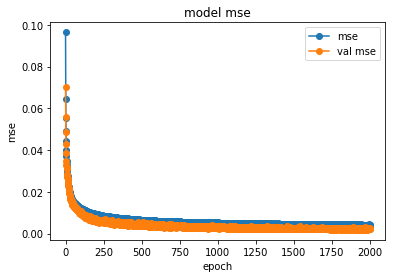

save the model


In [9]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar  7 15:43:18 2017

@author: hanar
"""
import time
import numpy as np
import os
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.models import load_model
#from keras.utils.visualize_util import plot
import matplotlib.pyplot as plt
import keras.callbacks
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf

#Global variables for normalizing parameters
max_x = 1.0
min_x = 0.0
max_y = 1.0
min_y = 0.0


def deep_learning_tsunami(resdir, X_train_raw, y_train_raw, X_test_raw, y_test_raw,
                            _lr=0.02, _decay=0,
                            _validation_split=0.2, _batch_size=32,
                            _momentum=0.9, _nesterov=True,
                            num_layers=4, dropout=0.5,
                            node_num = 2500,
                            _epochs=2000):
    """
    Creating the inversion model of turbidity currents by deep learning
    """
    #Normalizing dataset
    X_train = get_normalized_data(X_train_raw, min_x, max_x)
    X_test = get_normalized_data(X_test_raw, min_x, max_x)
    y_train = get_normalized_data(y_train_raw, min_y, max_y)
    y_test = get_normalized_data(y_test_raw, min_y, max_y)
    
    #Generation of neural network model
    model = Sequential()
    model.add(Dense(node_num, input_dim=X_train.shape[1], activation='relu', kernel_initializer ='glorot_uniform'))#1st layer
    model.add(Dropout(dropout))
    for i in range(num_layers - 2):
        model.add(Dense(node_num, activation='relu', kernel_initializer ='glorot_uniform'))#2nd layer
        model.add(Dropout(dropout))
    model.add(Dense(y_train.shape[1], activation = 'relu', kernel_initializer ='glorot_uniform')) #last layer
    
    #Compiling the model
    model.compile(loss="mean_squared_error", 
              optimizer=SGD(lr=_lr, decay=_decay, momentum=_momentum, nesterov=_nesterov),
              #optimizer=Adadelta(),
              metrics=["mean_squared_error"])    
    
    #Perform learning
    t = time.time()
    check = ModelCheckpoint("model3.hdf5")
    #es_cb = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    #tb_cb = TensorBoard(log_dir=resdir, histogram_freq=2, write_graph=True, write_images=True)
    history = model.fit(X_train, y_train, epochs=_epochs, 
                    validation_split=_validation_split, batch_size=_batch_size,
                    callbacks=[check])
    
    #Evaluate learning result
    loss_and_metrics = model.evaluate(X_test,y_test)
    print("\nloss:{} mse:{}".format(loss_and_metrics[0],loss_and_metrics[1]))
    
    print("Elapsed time: {:.1f} sec.".format(time.time()-t))
    
    #Visualize learning result   
    #plot(model, to_file="model.png", show_shapes=True, show_layer_names=True)

    # model The state of change when letting you learnplot
    plot_history(history)
    
    return model, history

def apply_model(model, X, min_x, max_x, min_y, max_y):
    """
    Apply model
    Maximum and minimum values ​​of X and Y are required to normalize
    """
    X_norm =  (X - min_x) / (max_x - min_x)
    Y_norm = model.predict(X_norm)
    Y = Y_norm*(max_y - min_y)+min_y
    return Y

def plot_history(history):
    # Plot accuracy history
    plt.plot(history.history['mean_squared_error'],"o-",label="mse")
    plt.plot(history.history['val_mean_squared_error'],"o-",label="val mse")
    plt.title('model mse')
    plt.xlabel('epoch')
    plt.ylabel('mse')
    plt.legend(loc="upper right")
    plt.show()

#    # 損失の履歴をプロット
#    plt.plot(history.history['loss'],"o-",label="loss",)
#    plt.plot(history.history['val_loss'],"o-",label="val_loss")
#    plt.title('model loss')
#    plt.xlabel('epoch')
#    plt.ylabel('loss')
#    plt.legend(loc='upper right')
#    plt.show()

def test_model(model, x_test):
    #Test the results
    
    x_test_norm = get_normalized_data(x_test, min_x, max_x)
    test_result_norm = model.predict(x_test_norm)
    test_result = get_raw_data(test_result_norm, min_y, max_y)
    
    return test_result


def save_result(savedir, model, history, test_result):
    
    
    np.savetxt(savedir + 'test_result.txt',test_result,delimiter=',')
    np.savetxt(savedir+'loss.txt',history.history.get('loss'),delimiter=',')
    np.savetxt(savedir+'val_loss.txt',history.history.get('val_loss'),delimiter=',')
    
    #Serialize model and save
    print('save the model')
    model.save(savedir + 'model3.hdf5')

def load_data(datadir):
    """
    This function load training and test data sets, and returns variables
    """
    global min_x, max_x, min_y, max_y
    
    x_train = np.loadtxt(datadir + 'x_train.txt',delimiter=',')
    x_test = np.loadtxt(datadir + 'x_test.txt',delimiter=',')
    y_train = np.loadtxt(datadir + 'icond_train.txt',delimiter=',')
    y_test = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')
    min_y = np.loadtxt(datadir + 'icond_min.txt',delimiter=',')
    max_y = np.loadtxt(datadir + 'icond_max.txt',delimiter=',')
    [min_x, max_x] = np.loadtxt(datadir + 'x_minmax.txt',delimiter=',')
    
    return x_train, y_train, x_test, y_test

def set_minmax_data(_min_x, _max_x, _min_y, _max_y):
    global min_x, max_x, min_y, max_y
    
    min_x, max_x, min_y, max_y = _min_x, _max_x, _min_y, _max_y
    return
    


def get_normalized_data(x, min_val, max_val):
    """
    Normalizing the training and test dataset
    """
    x_norm = (x - min_val) / (max_val - min_val)
    
    return x_norm

def get_raw_data(x_norm, min_val, max_val):
    """
    Get raw data from the normalized dataset
    """
    x = x_norm * (max_val - min_val) + min_val
    
    return x

if __name__ == "__main__":
    
    #Reading data  
    datadir = '/home/rimali2009/FITTNUSS-forward_training_DNN/data_g6_300grid_H_5000_20_11_roi1500/'
    resdir = '/home/rimali2009/FITTNUSS-forward_training_DNN/result_g6_300grid_H_5000_20_11_roi1500/'
    if not os.path.exists(resdir):
        os.mkdir(resdir)
    
    x_train, y_train, x_test, y_test = load_data(datadir)
    
     
    #Execution of learning
    testcases = [4500]
    for i in range(len(testcases)):
        resdir_case = resdir + '{}/'.format(testcases[i])        
        if not os.path.exists(resdir_case):
            os.mkdir(resdir_case)
        x_train_sub = x_train[0:testcases[i],:]
        y_train_sub = y_train[0:testcases[i],:]
        model, history = deep_learning_tsunami(resdir_case, x_train_sub, y_train_sub, x_test, y_test, num_layers=5)
        #Verify and save results
        result = test_model(model, x_test)
        save_result(resdir_case,model,history,result)




(500, 9)


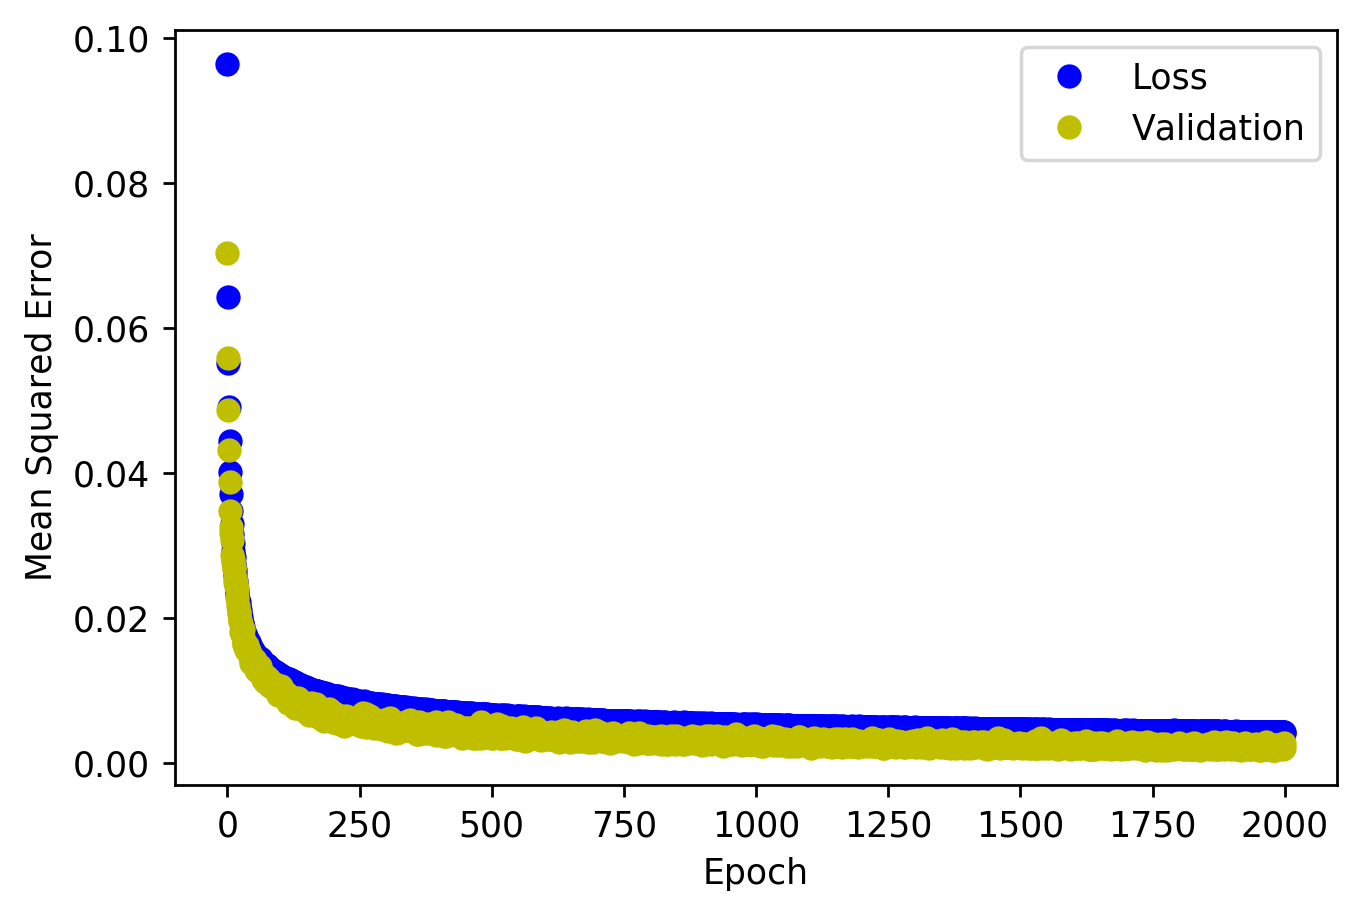

/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 432x288 with 0 Axes>

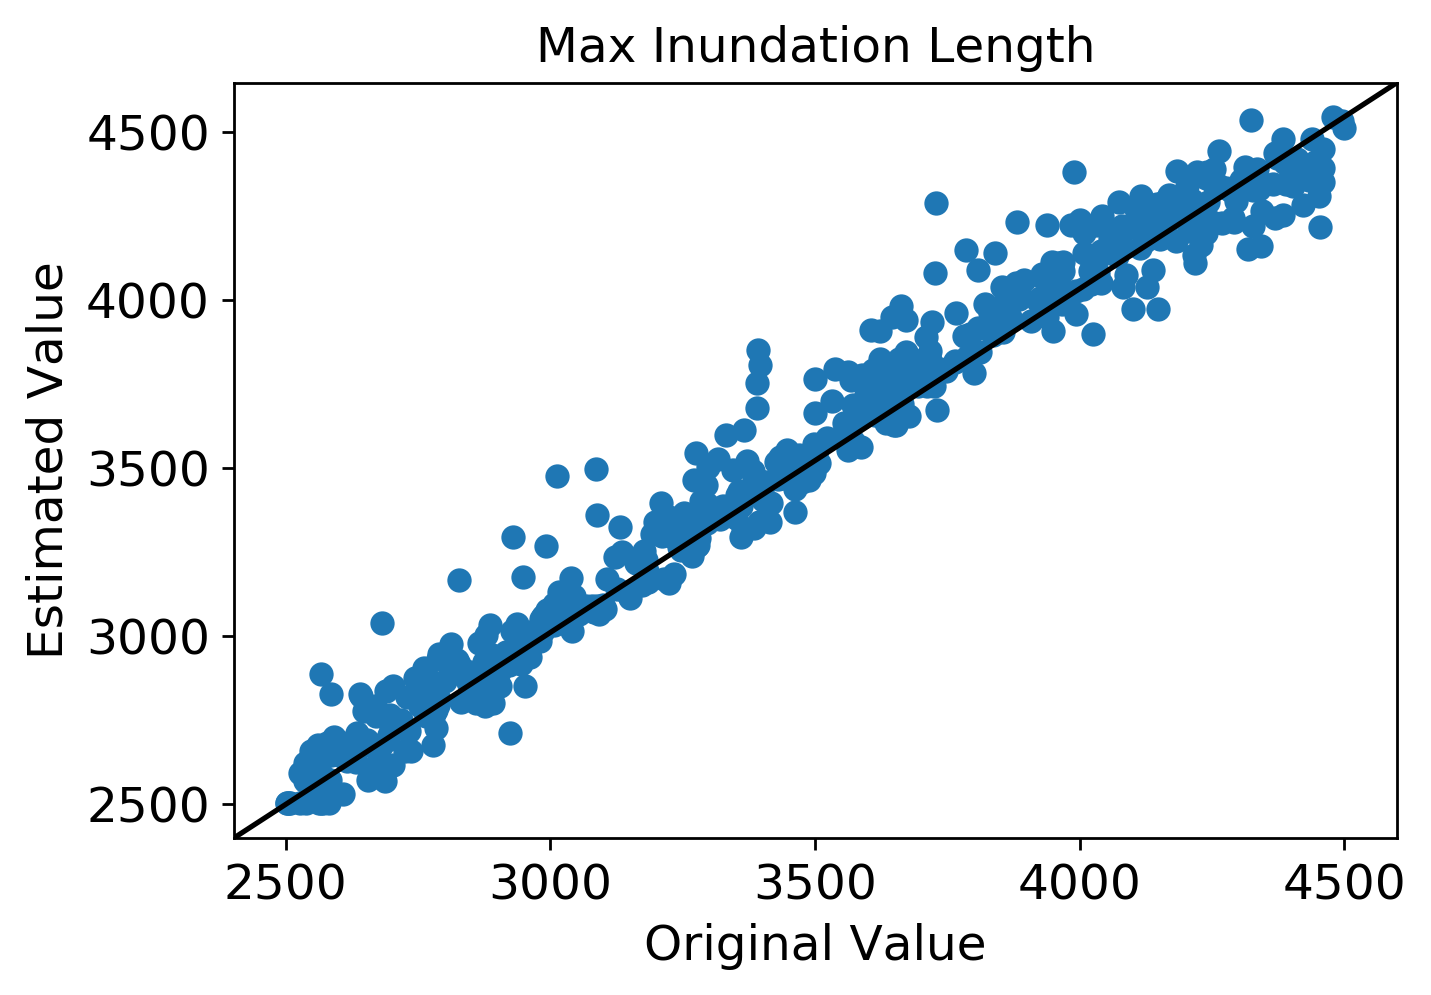

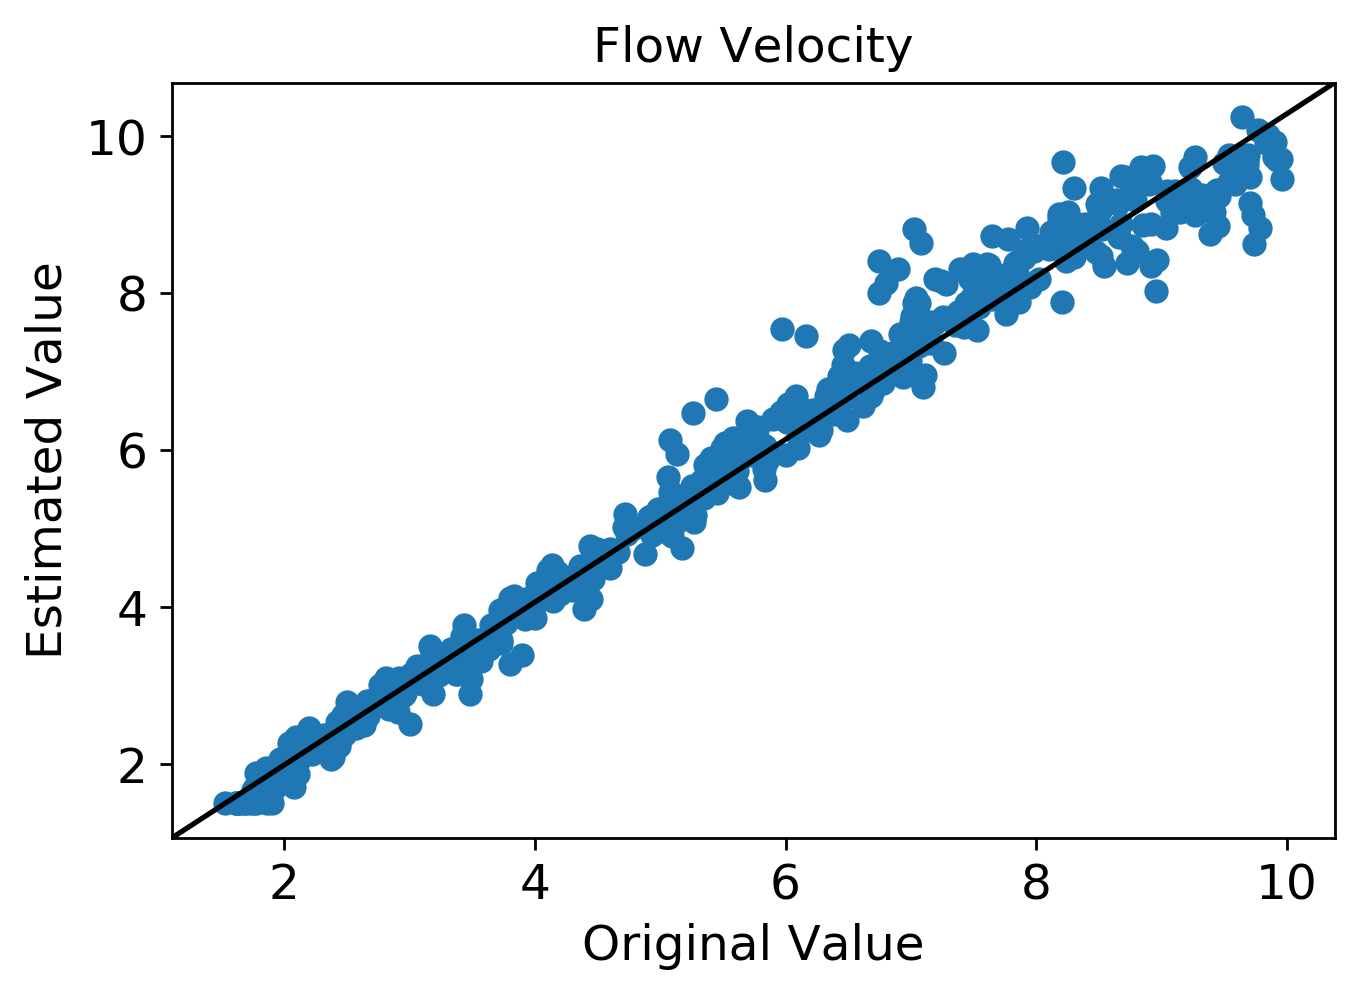

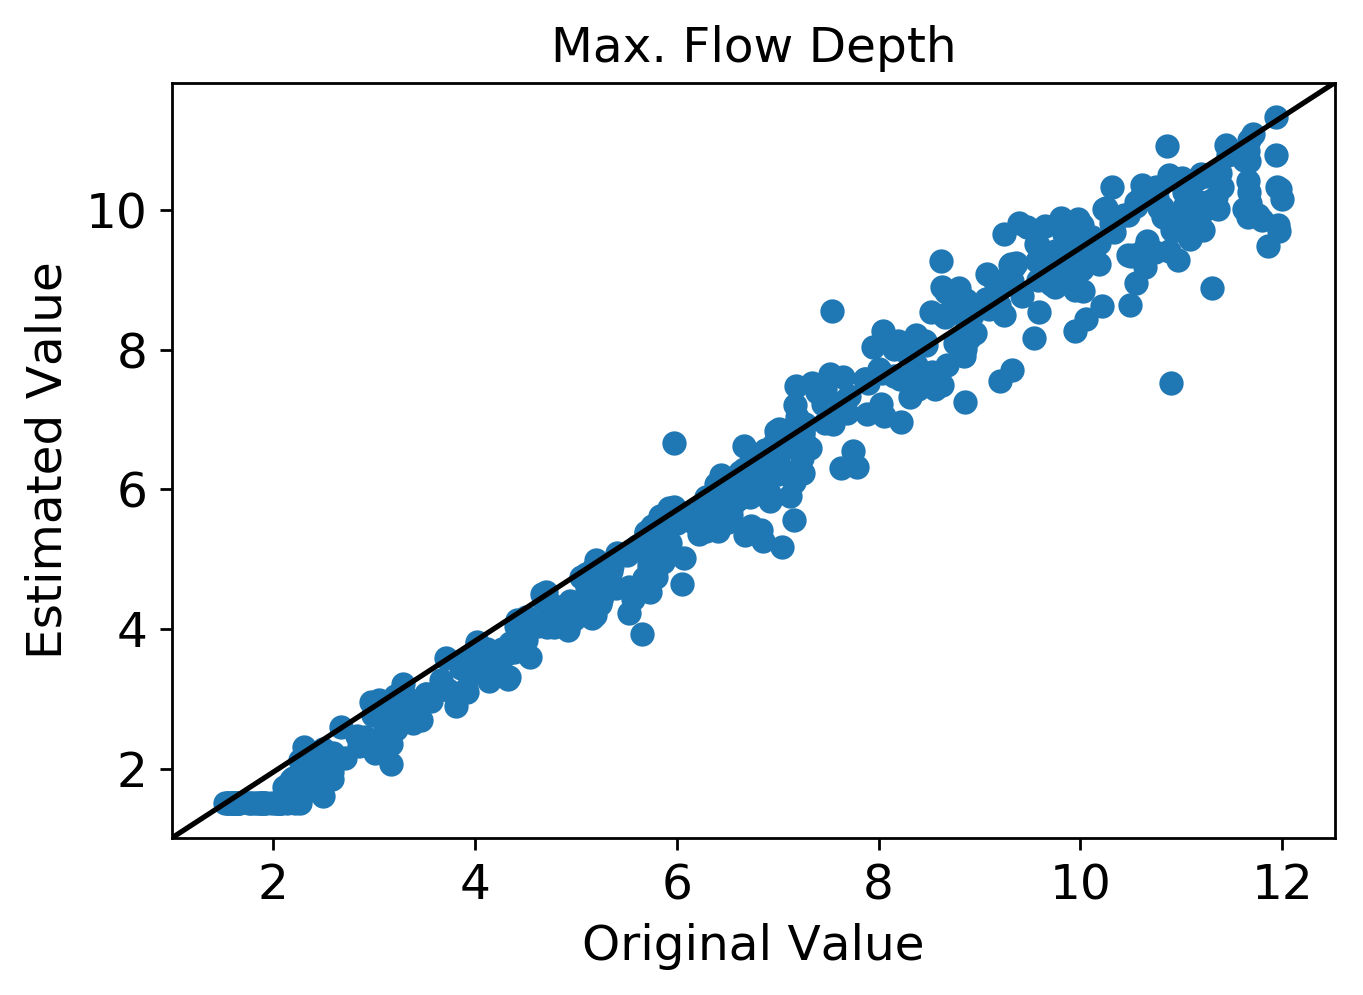

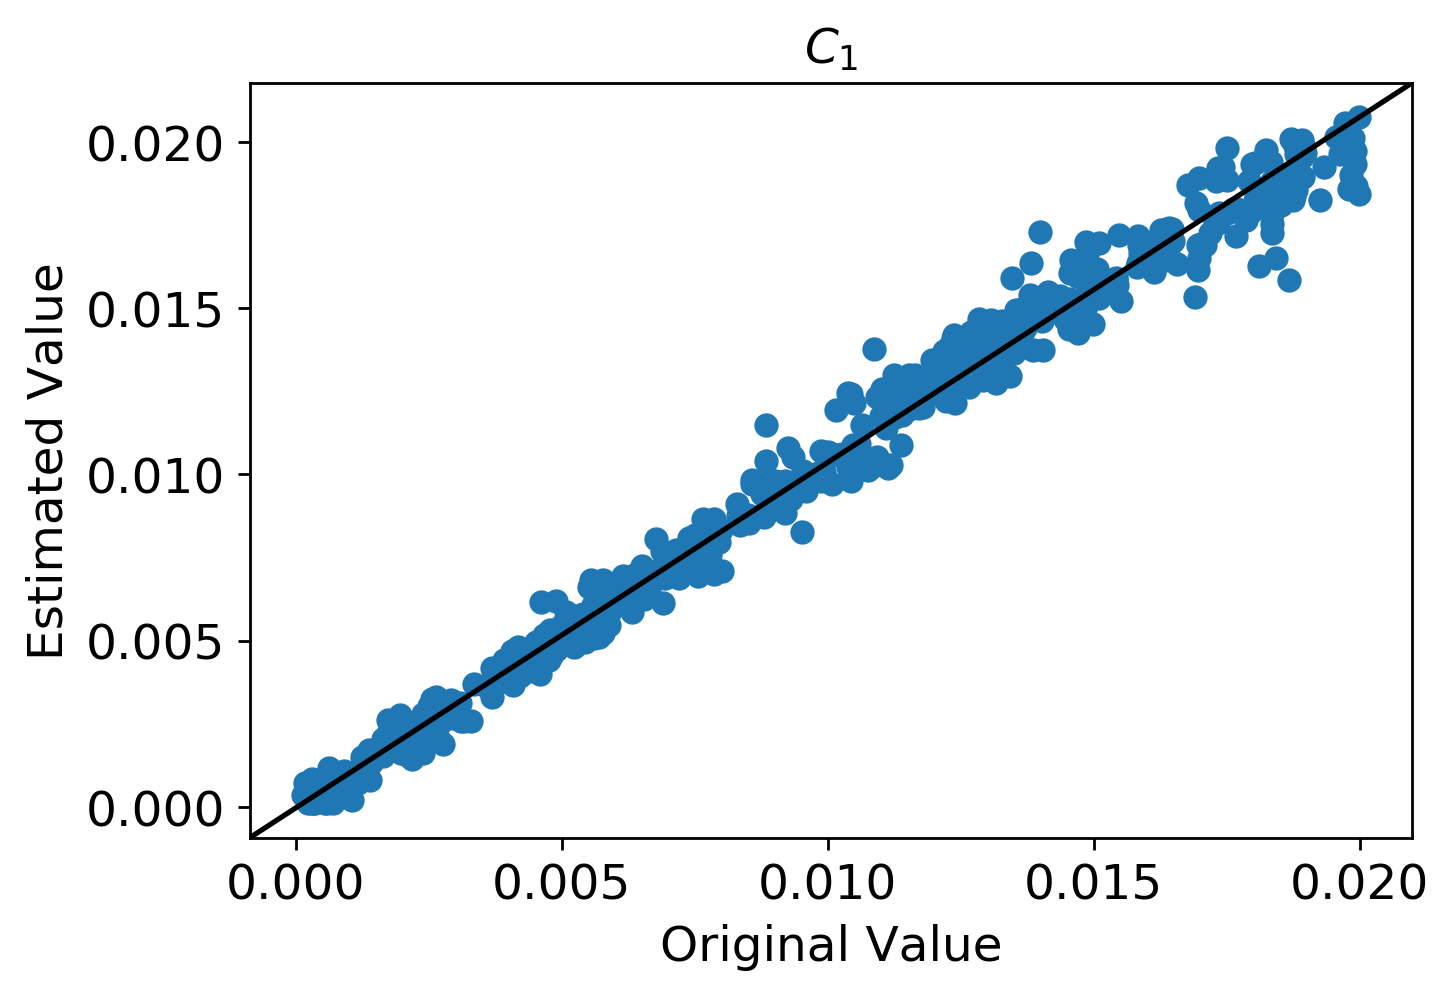

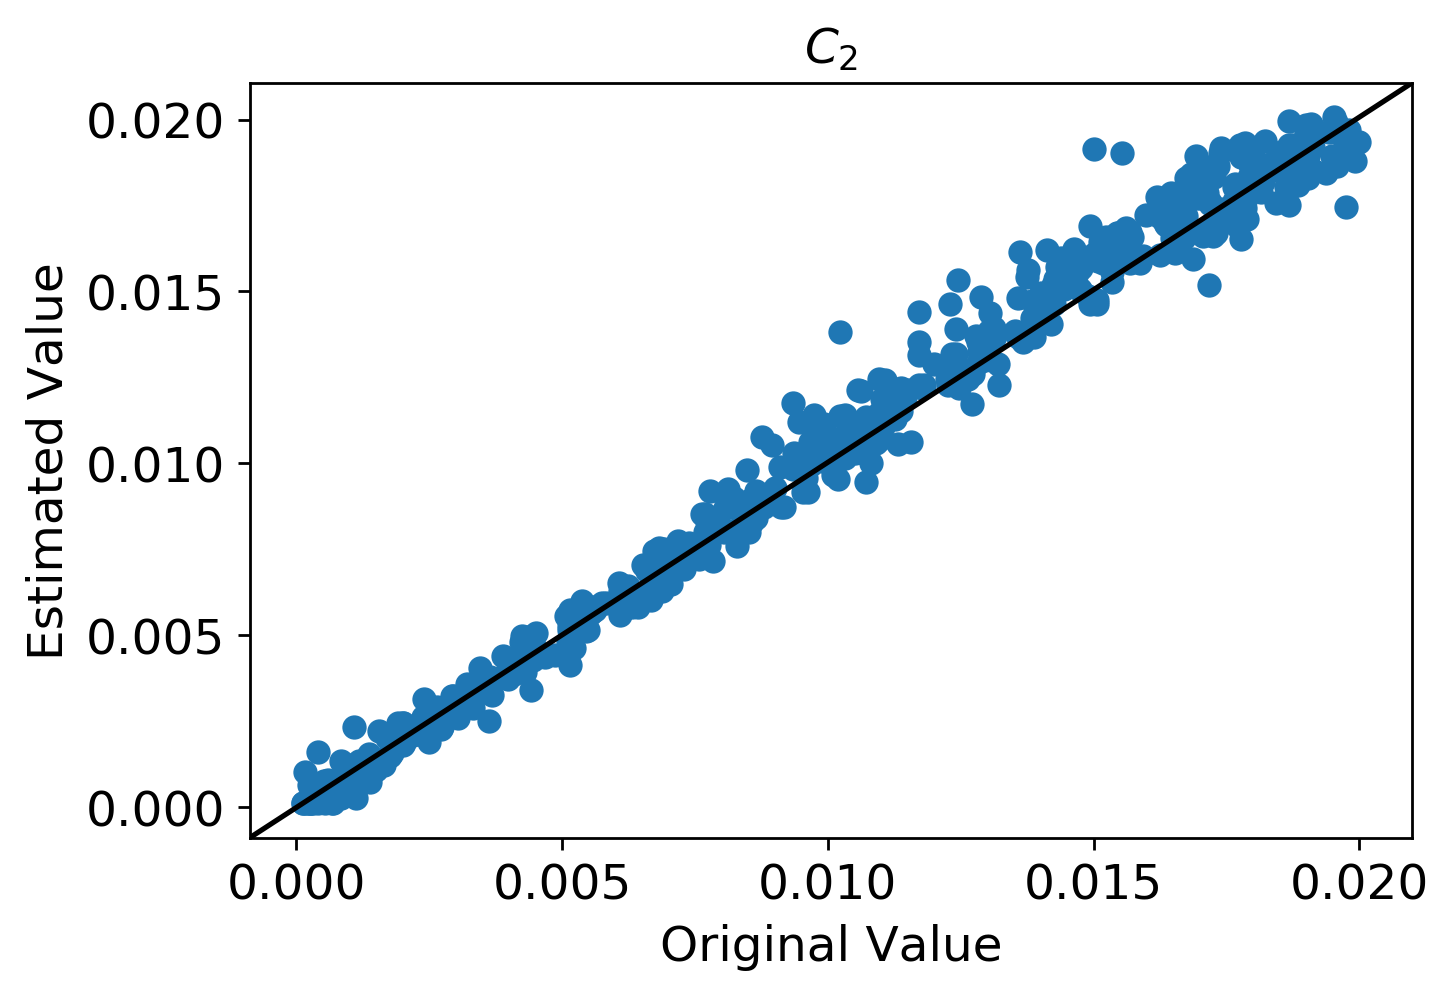

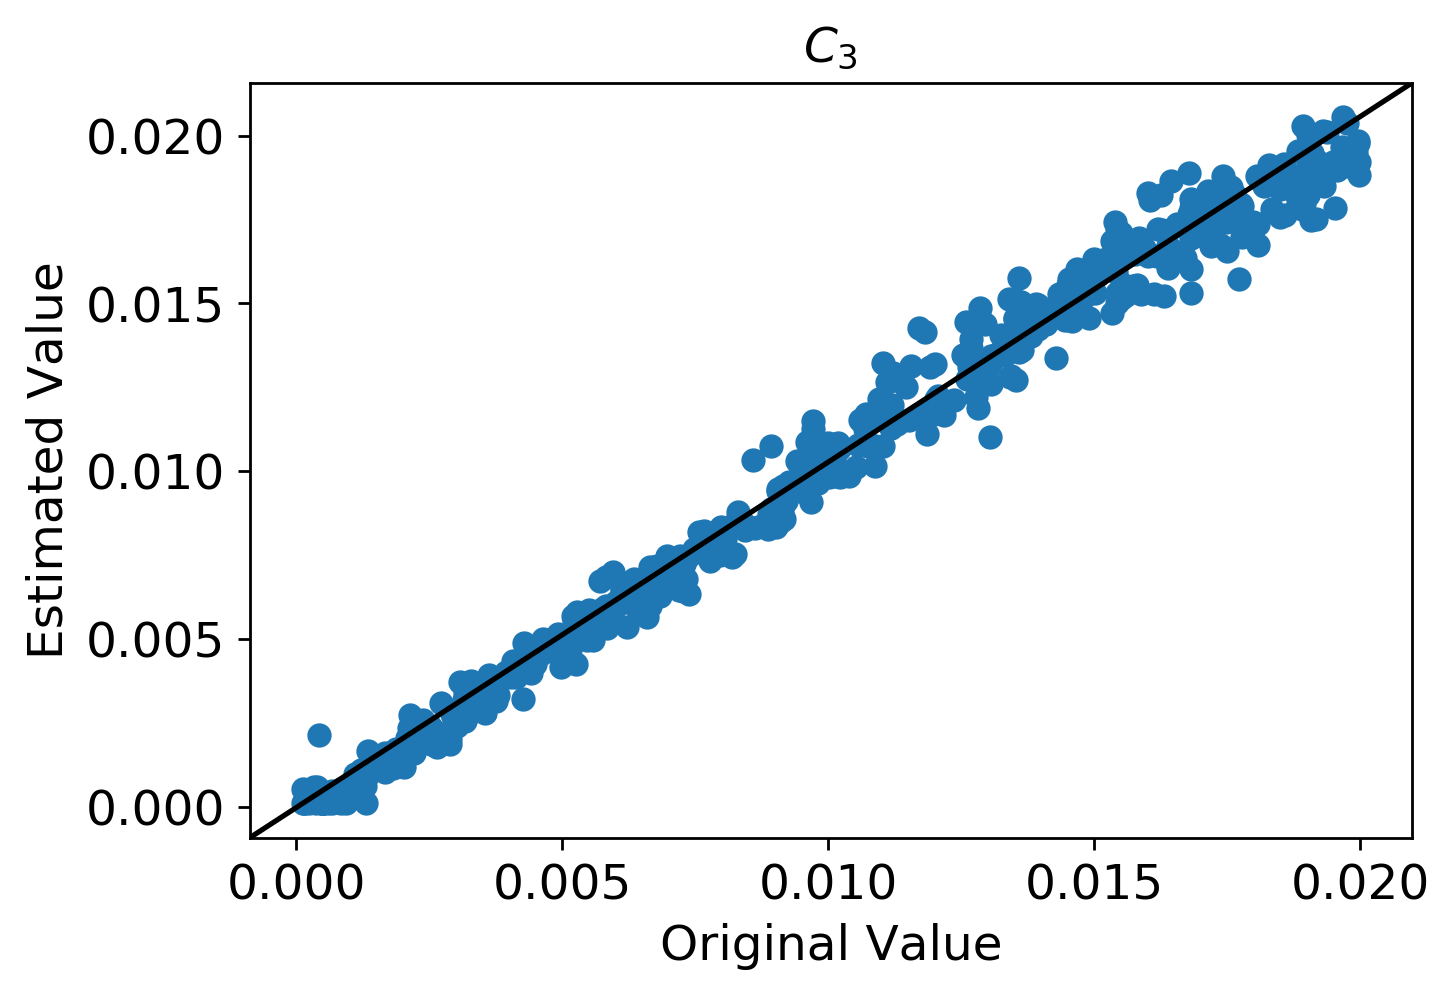

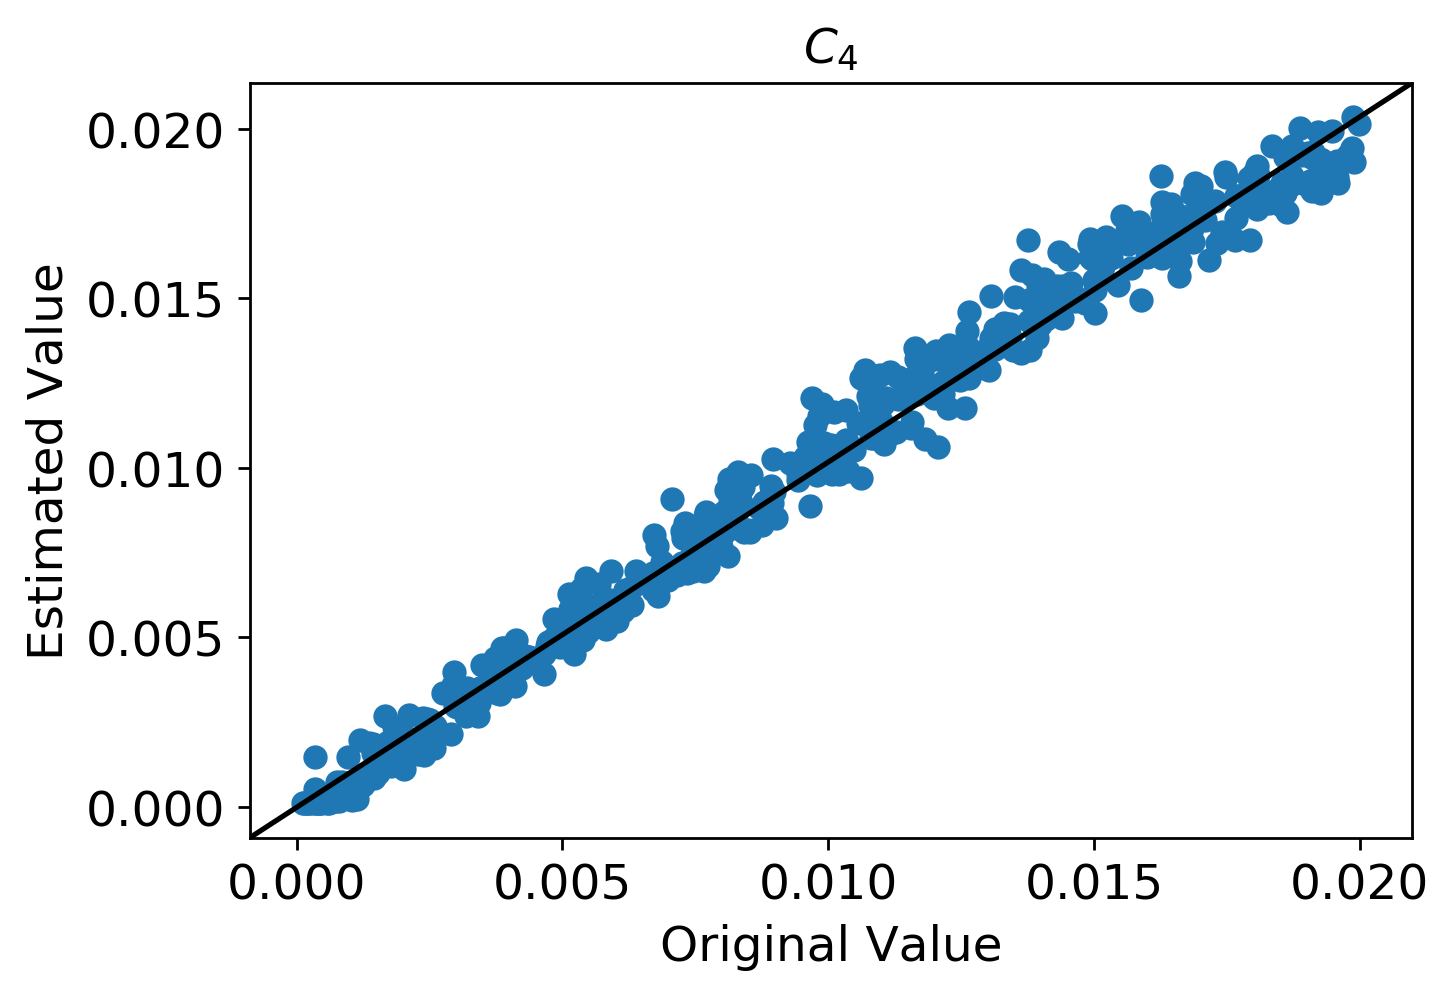

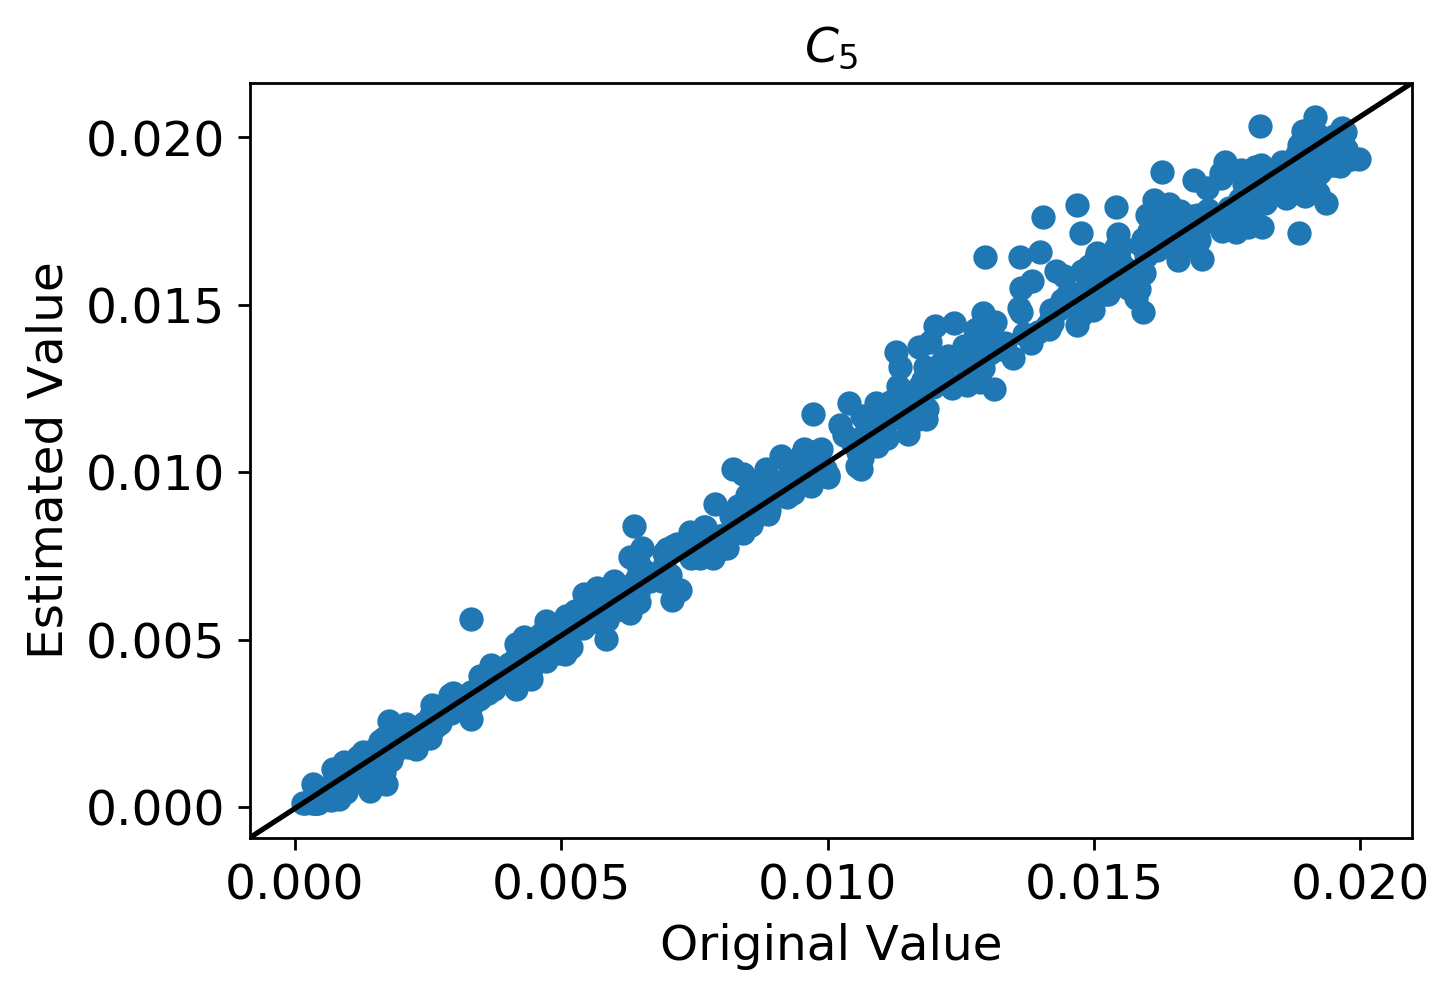

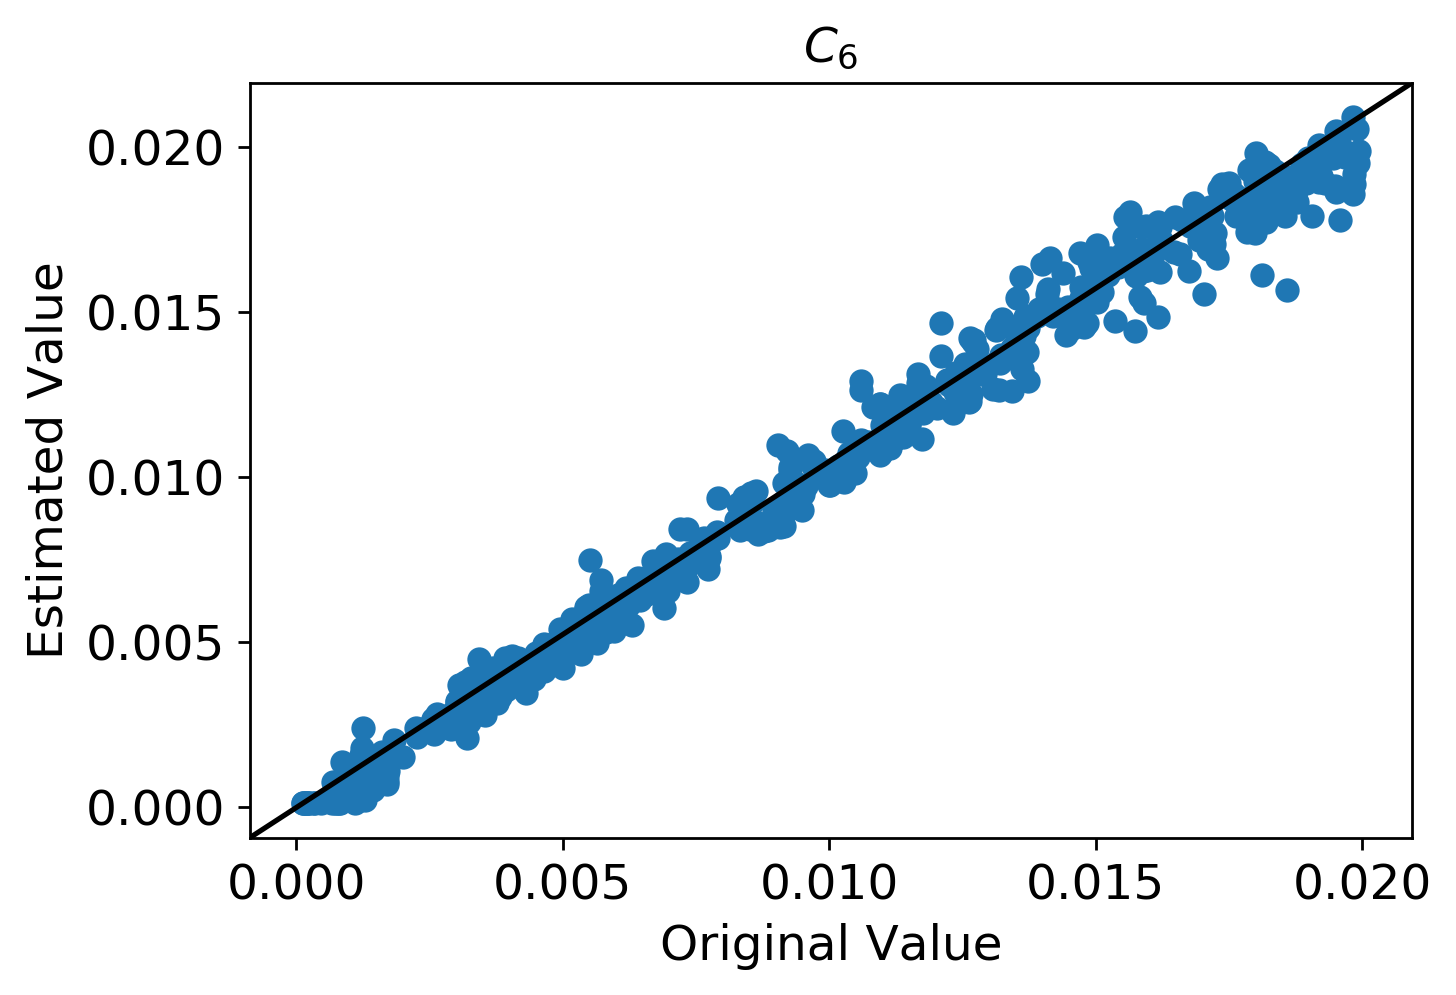

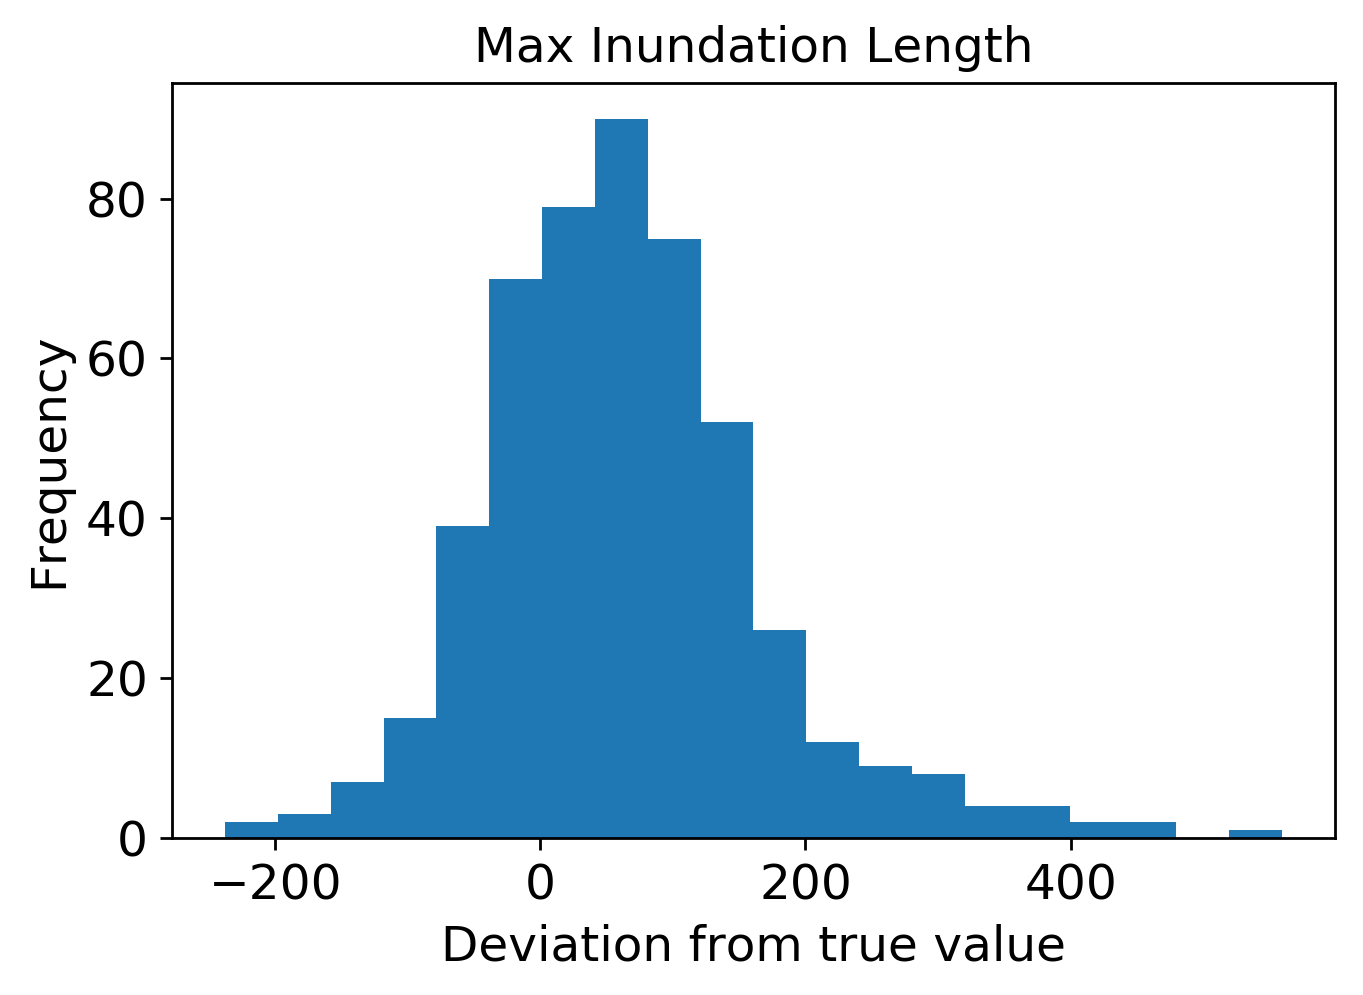

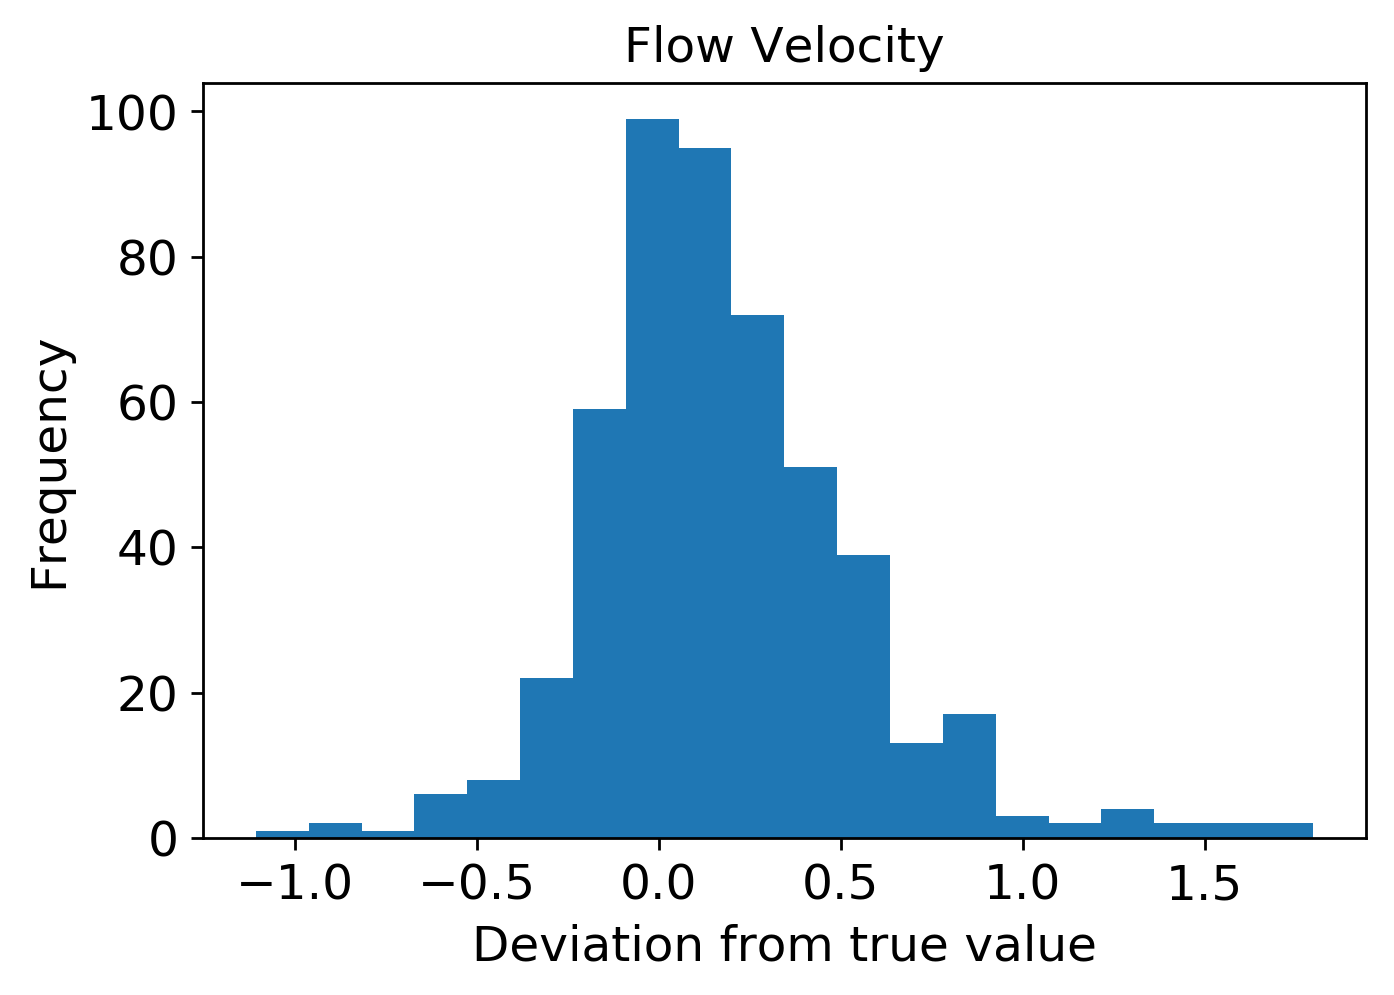

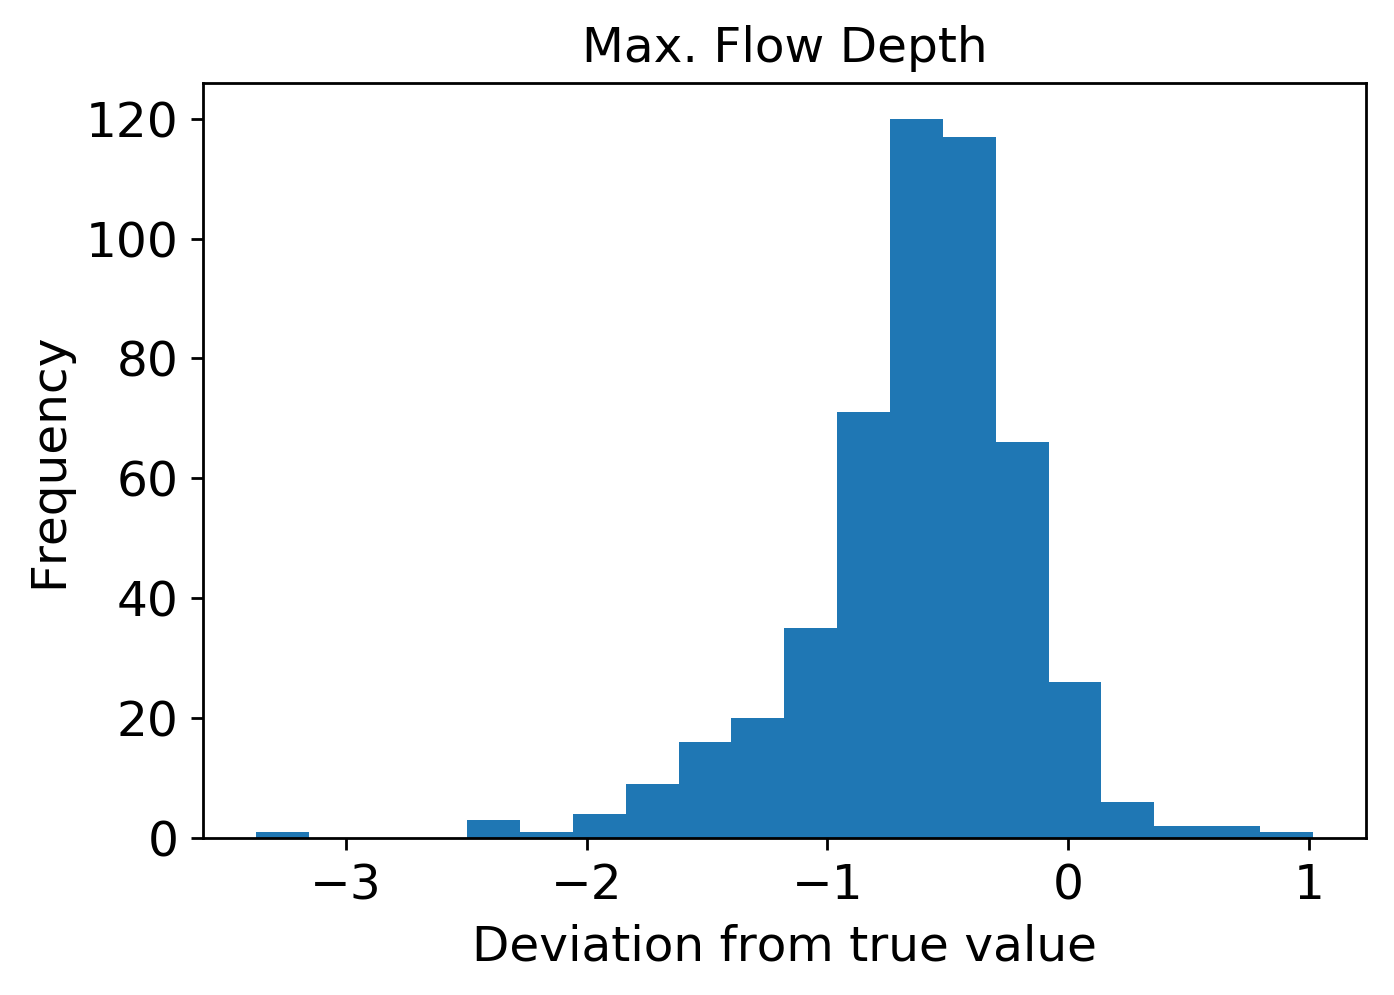

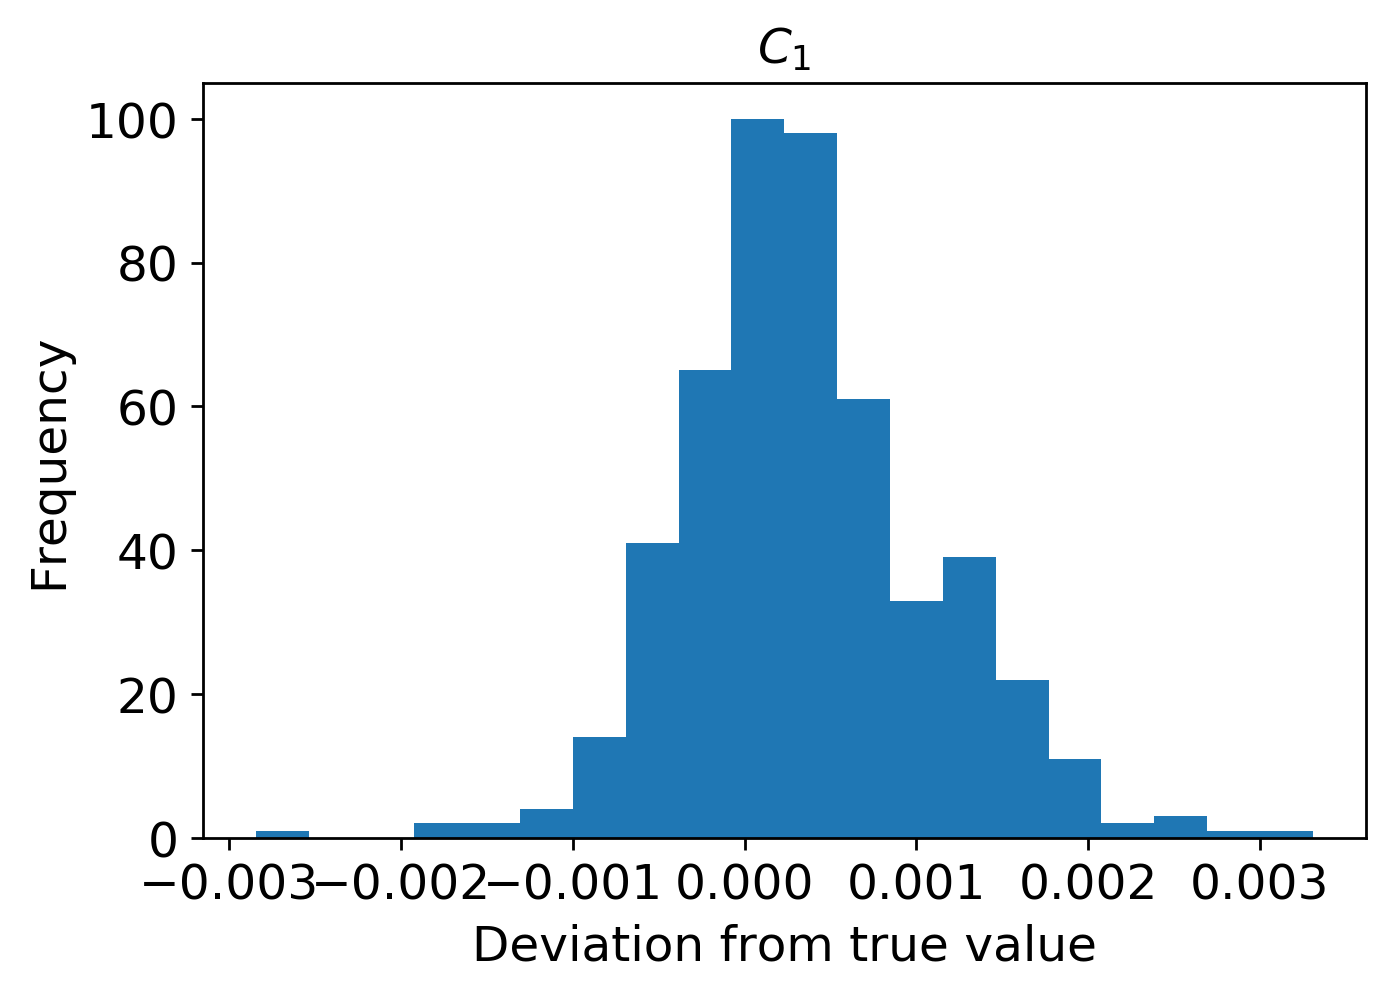

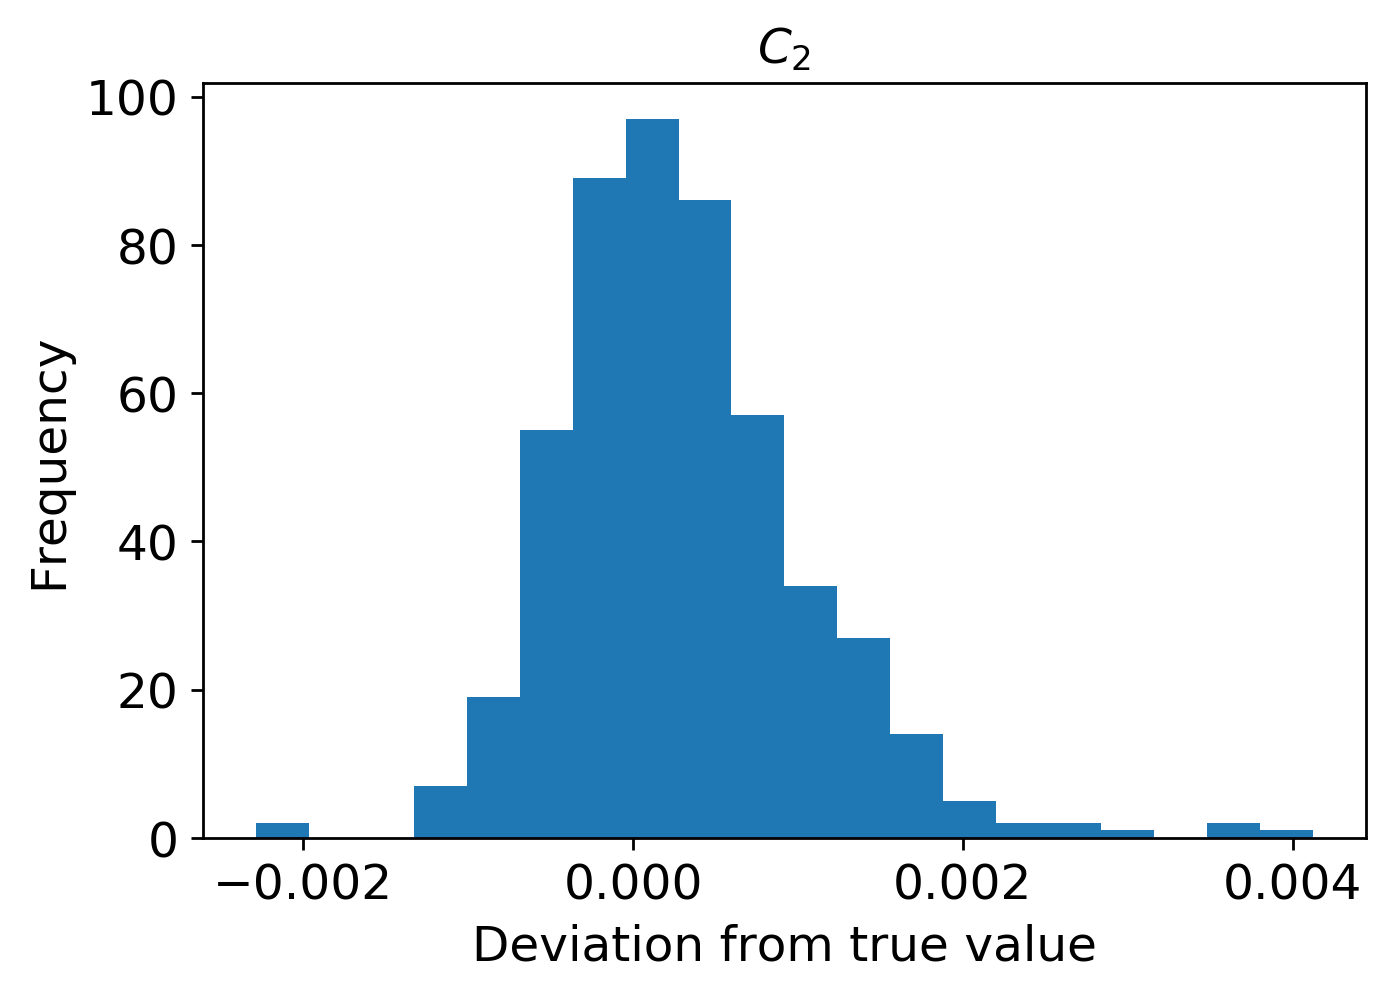

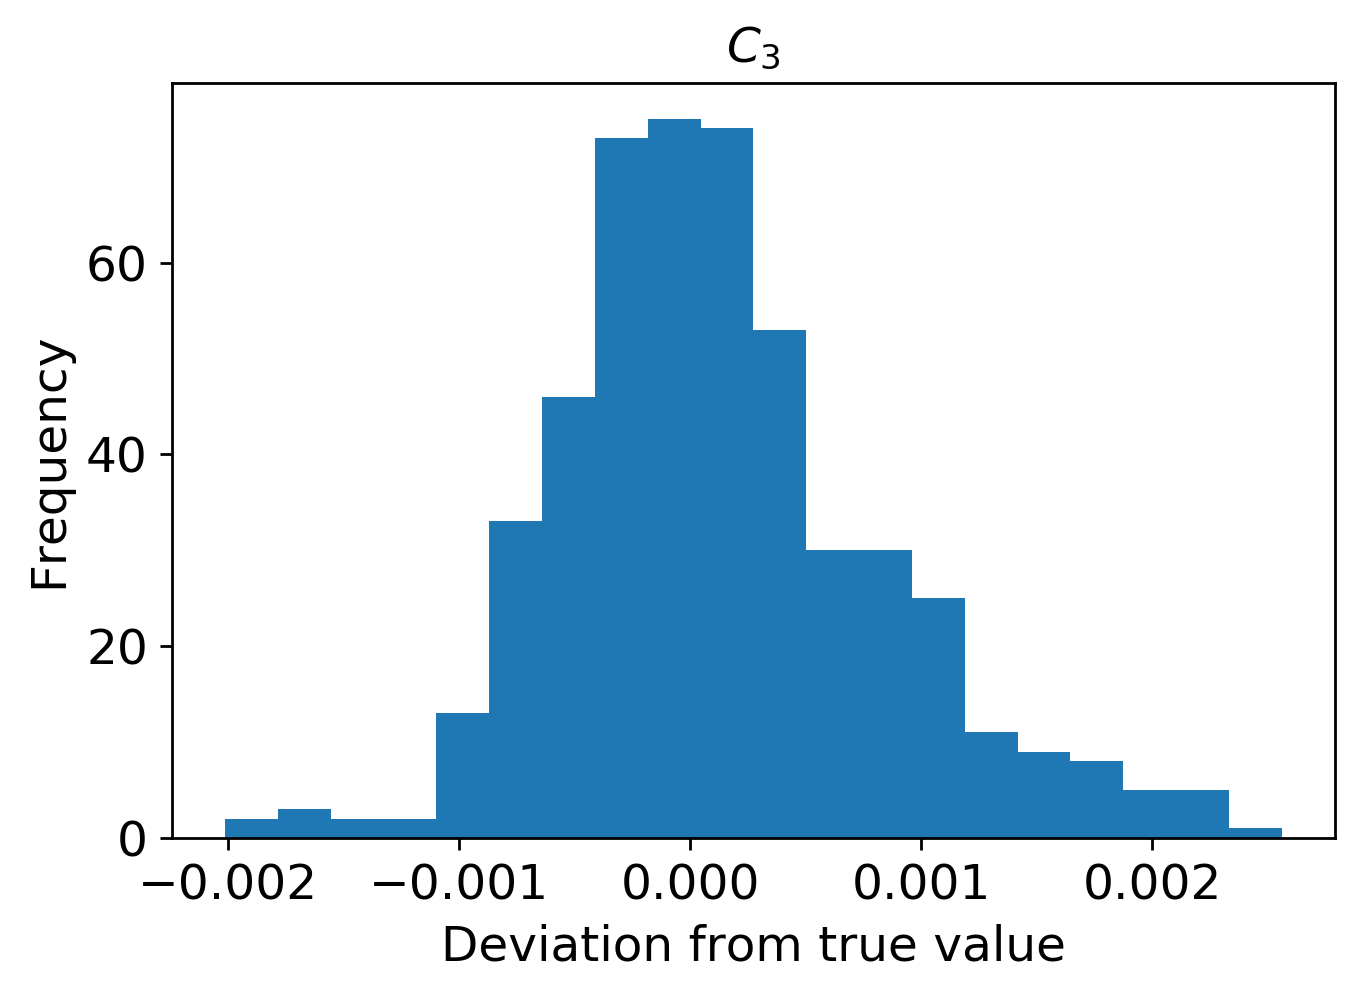

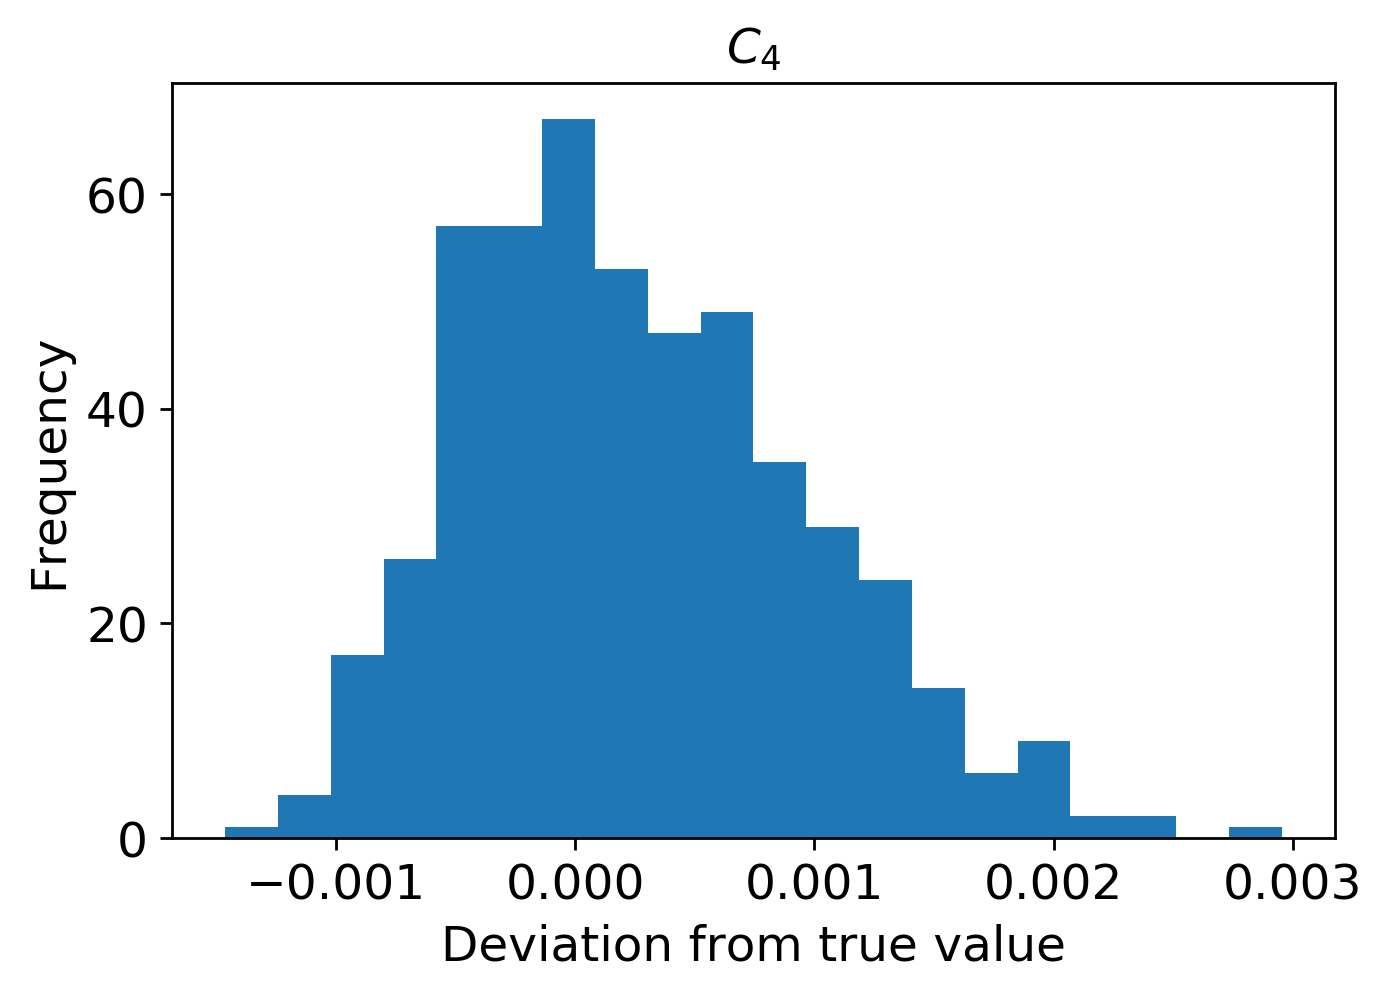

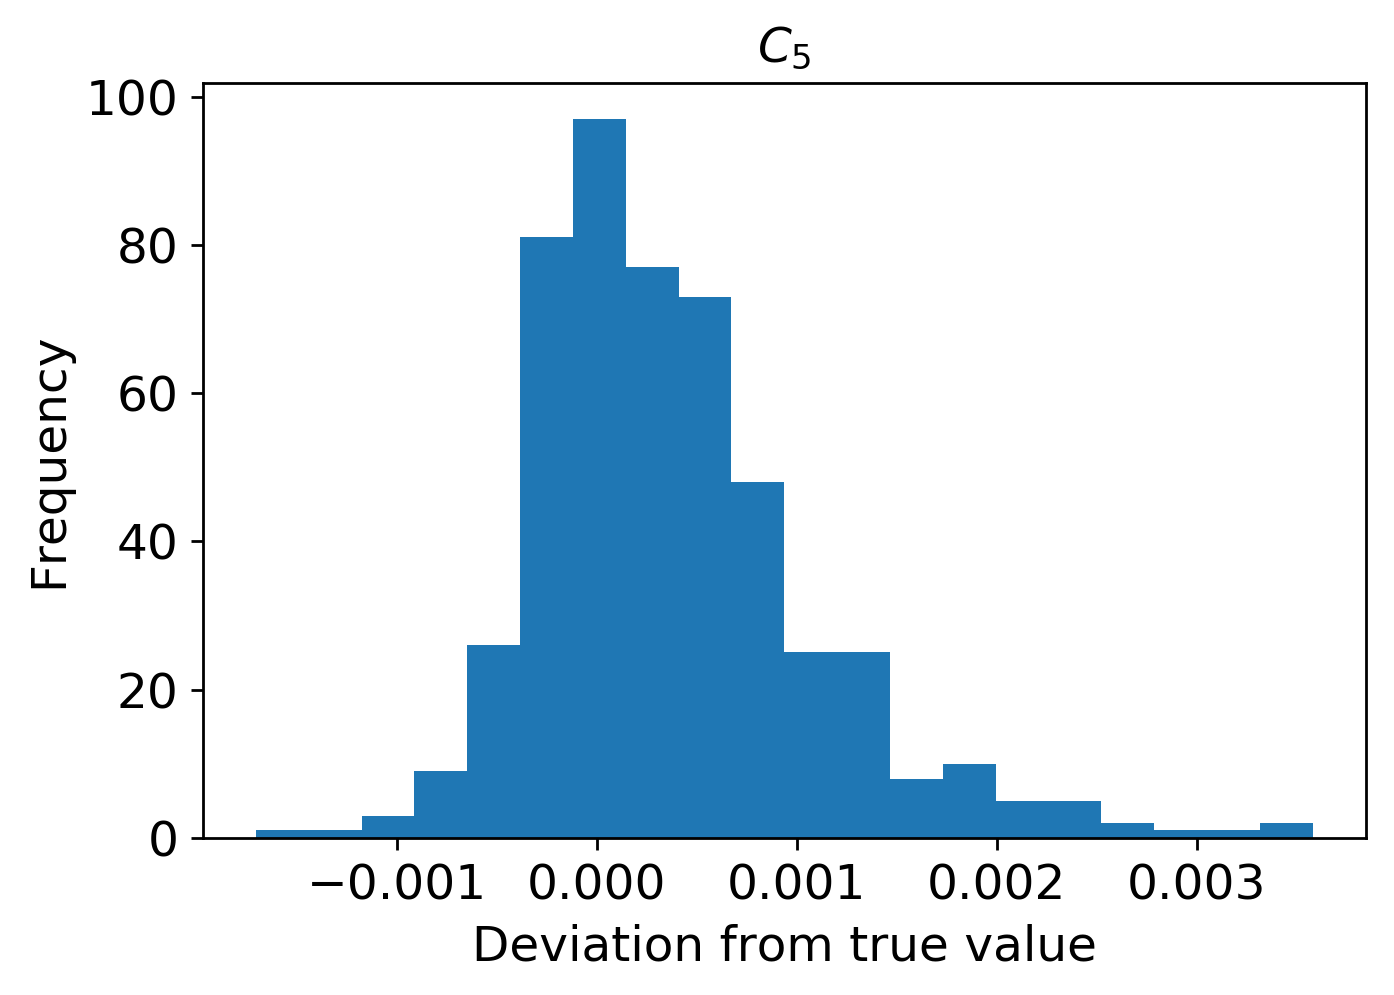

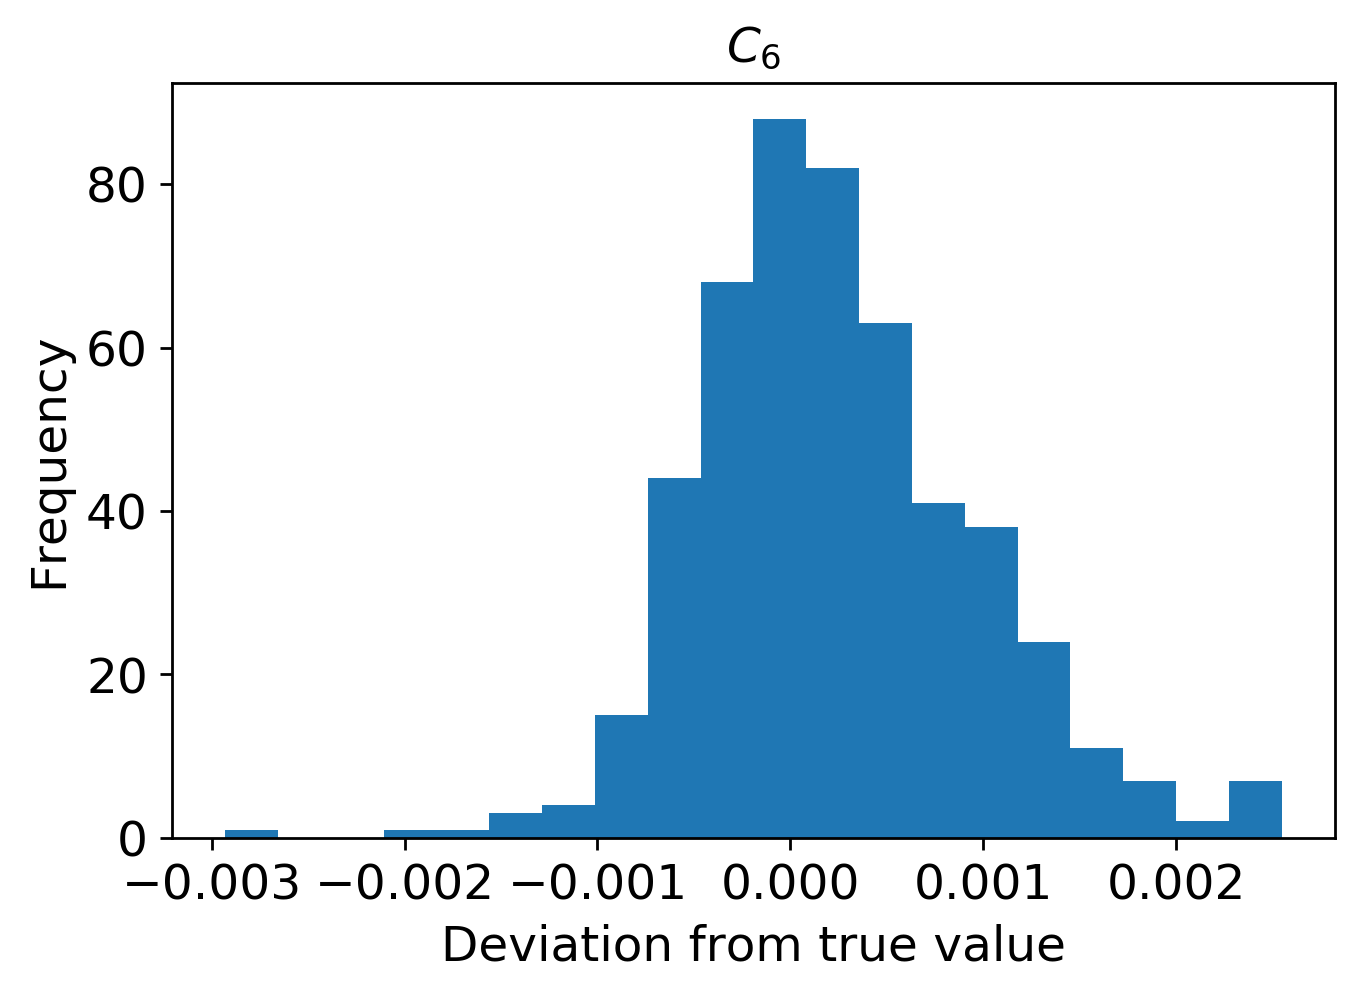

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

datadir = '/home/rimali2009/FITTNUSS-forward_training_DNN/data_g6_300grid_H_5000_20_11_roi1500/'
resdir = '/home/rimali2009/FITTNUSS-forward_training_DNN/result_g6_300grid_H_5000_20_11_roi1500/4500/'

test_result = np.loadtxt(resdir + 'test_result.txt',delimiter=',')
icond = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')
print(icond.shape)
loss = np.loadtxt(resdir+'loss.txt',delimiter=',')
epoch = range(0,2000)
vloss = np.loadtxt(resdir+'val_loss.txt',delimiter=',')
resi = test_result - icond

fig = plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
plt.plot(epoch, loss, 'bo',label='Loss')
plt.plot(epoch, vloss, 'yo',label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend(loc="upper right")
plt.savefig(resdir+ 'mse.eps')
plt.show()

fig2 = plt.figure()
hfont = {'fontname':'Century Gothic'}
textcol = 'k'
titlelabel = ['Max Inundation Length','Flow Velocity', 'Max. Flow Depth', '$C_1$', '$C_2$', '$C_3$', '$C_4$','$C_5$','$C_6$']


    
for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.plot(icond[:,i],test_result[:,i],"o")
    x=icond[:,i]
    y=test_result[:,i]
    y_lim = plt.ylim()
    x_lim = plt.xlim()
    plt.plot(x_lim, y_lim, 'k-', color = 'k')
    plt.ylim(y_lim)
    plt.xlim(x_lim)
    plt.xlabel('Original Value',color=textcol,size=14,**hfont)
    plt.ylabel('Estimated Value',color=textcol,size=14,**hfont)
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + '.eps')
    #plt.show()

for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.hist(resi[:,i],bins=20)
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('Deviation from true value',color=textcol,size=14,**hfont)
    plt.ylabel('Frequency',color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.eps')
    plt.show()

       distance        g1        g2        g3        g4        g5        g6
0      0.000000  0.036771  0.167260  0.114845  0.008449  0.002190  0.005161
1    103.794102  0.000000  0.075200  0.153283  0.013753  0.001885  0.000442
2    171.620654  0.002130  0.051171  0.084309  0.006218  0.001867  0.002843
3    397.112167  0.003115  0.016359  0.078858  0.011466  0.000597  0.000054
4    595.912969  0.000732  0.016896  0.028720  0.002661  0.000914  0.000000
5    707.625749  0.000143  0.002228  0.005502  0.000900  0.000187  0.000104
6    796.435078  0.000236  0.004337  0.021204  0.003169  0.000309  0.000080
7    895.065500  0.001688  0.016059  0.081413  0.020284  0.006824  0.004628
8    988.394177  0.004567  0.008166  0.074658  0.016913  0.002424  0.001580
9   1081.819325  0.001567  0.016305  0.060234  0.011086  0.004165  0.001994
10  1195.756993  0.001022  0.002370  0.017565  0.004194  0.000567  0.000142
11  1290.372534  0.000000  0.004121  0.057974  0.014565  0.000426  0.000213
12  1400.896

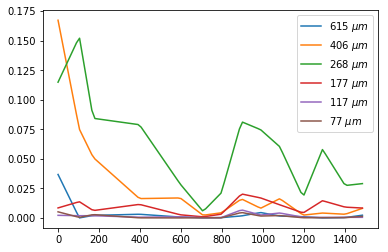

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy import stats
from scipy.interpolate import interp1d 
import pandas as pd
from pykrige import OrdinaryKriging as OK
import ipdb


datadir = '/home/rimali2009/FITTNUSS-forward_training_DNN/data_g6_300grid_H_5000_20_11_roi1500/'
resdir = '/home/rimali2009/FITTNUSS-forward_training_DNN/result_g6_300grid_H_5000_20_11_roi1500/4500/'
#Initial setting
if not "model" in locals(): 
    model = load_model(resdir+'model3.hdf5')
#gclass = 3
#gclass_label = ["500 $\mu$m","125 $\mu$m","63 $\mu$m"]
gclass = 6
gclass_label = ["615 ${\mu}m$","406 ${\mu}m$","268 ${\mu}m$","177 ${\mu}m$", "117 ${\mu}m$","77 ${\mu}m$"]
topodx = 15.0
coord_num = int(model.layers[0].input_shape[1]/gclass)

#Acquires a value for normalizing input data to [0, 1]
min_x, max_x = np.loadtxt(datadir + 'x_minmax.txt',delimiter=',')
y_min = np.loadtxt(datadir + 'icond_min.txt',delimiter=',')
y_max = np.loadtxt(datadir + 'icond_max.txt',delimiter=',')

#Read outcrop data
#dist_max = 22000. #Distance of distal end of learning data
outcrop = pd.read_csv('../FITTNUSS-forward_training_DNN/sendai_increased_class_edit.csv')
#outcrop = pd.read_csv('../DeepLearningTurbidite_Fukuda/GA_naruse_v2.csv')
#outcrop = outcrop.append(pd.DataFrame([[0,'Loc0',0,0,0],[dist_max,'LocE',0,0,0]], columns=outcrop.columns))
outcrop = outcrop.sort_values('distance')
outcrop['distance'] = outcrop['distance'] - 0
#d = pd.DataFrame(np.zeros((1, 7)),columns=['distance', 'g1','g2','g3','g4','g5','g6'])
#print(d)
#v=np.concatenate((outcrop, d))
#print(v)
#outcrop=pd.DataFrame(v,columns=['distance', 'g1','g2','g3','g4','g5','g6'])
#outcrop['distance'].iloc[-1]=4000
#outcrop = outcrop.append(pd.DataFrame([[0,'Loc0',0,0,0,0]], columns=outcrop.columns))
print(outcrop)

#Preparation under interpolation
thick_interp = np.zeros([1,coord_num*gclass])#補間されたサンプル厚さデータ
outcrop_x_id = np.round(outcrop['distance']/topodx).astype(np.int32) #逆解析システムでのサンプリング地点のindex番号
x = np.arange(0,coord_num*topodx,topodx)

#Complement data
for j in range(gclass):
    f = interp1d(outcrop['distance'],outcrop.iloc[:,j+1], kind="linear",bounds_error=False,fill_value='extrapolate')
    #f = interp1d(outcrop['distance'],outcrop.iloc[:,j+2], kind="linear",bounds_error=False,fill_value='extrapolate') 
    #Interpolation function of jth granularity level
    thick_interp[0,coord_num*j:coord_num*(j+1)] = f(x) #Supplemented data

#ipdb.set_trace()
#Kriging Interpolation by
#vparams = np.array([[0.035, 10000., 0.001],[0.006, 10000., 0.002],[0.005, 10000., 0.002],[0.035, 10000., 0.001]])
#for j in range(gclass):
    #okip = OK(outcrop['distance'],np.zeros(outcrop['distance'].shape),outcrop.iloc[:,j+1],variogram_model='linear',)
    #okip.display_variogram_model()
    #ipdata, ipstd = okip.execute('grid',x,np.array([0.]))
    #ipdata = np.squeeze(ipdata)
    #thick_interp[0,coord_num*j:coord_num*(j+1)] = ipdata #Assign complemented d

#Normalize data
thick_interp[thick_interp < 0] = 0
thick_interp_norm =  (thick_interp - min_x) / (max_x - min_x)

#Perform inverse analysis
test_result_outcrop = model.predict(thick_interp_norm)
test_result_outcrop = test_result_outcrop * (y_max - y_min) + y_min
print(test_result_outcrop)
#add=np.array(3000)
#test_result_outcrop_add=np.concatenate((add,test_result_outcrop), axis=None)
#Output results
#print(test_result_outcrop_add)
np.savetxt('outcrop_result_g6_g300_H_5000_20_11_roi1500.txt',test_result_outcrop, delimiter=',')
for i in range(len(gclass_label)):
    plt.plot(x,thick_interp[0,coord_num * i:coord_num * (i+1)],label=gclass_label[i])
plt.legend()
plt.show()



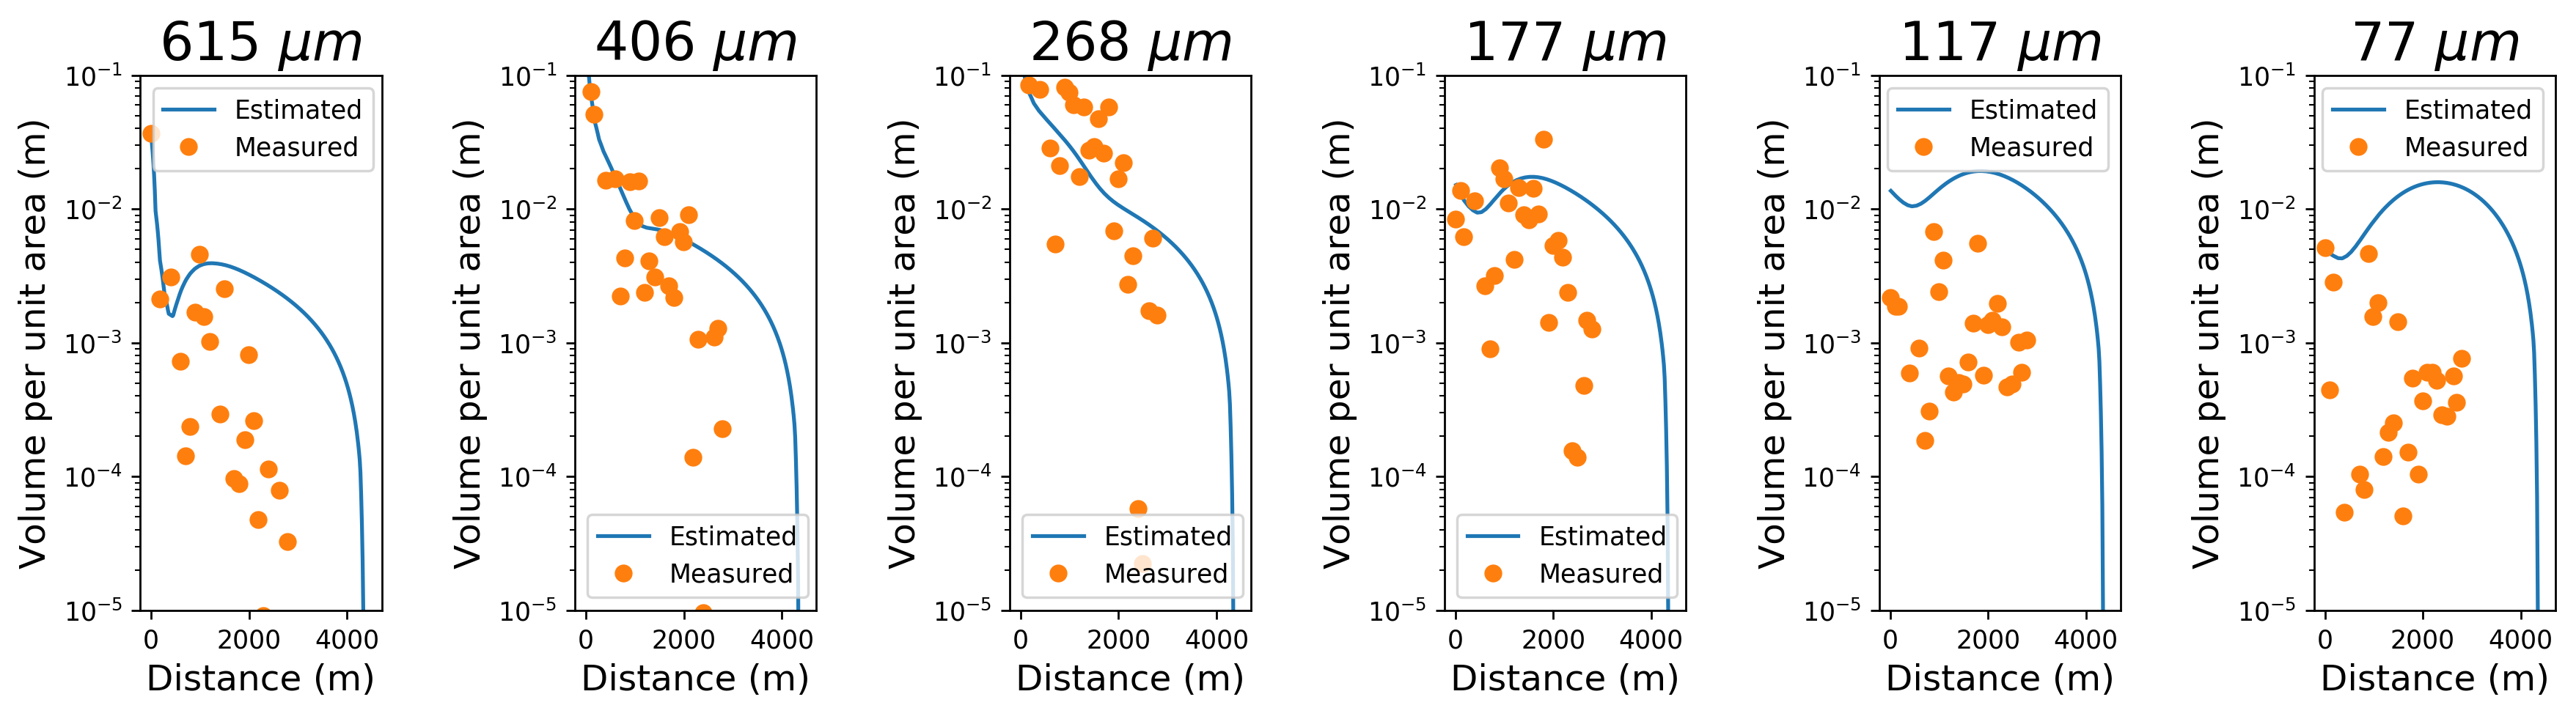

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Forward_model_modified_FITTNUSS_5000_g6_300grid_19_11_case2 as fmodel
import time
import ipdb
import matplotlib.ticker
%matplotlib inline

#Basic setting

#dist_max = 3000.
gclass = 6
topodx=15.0
gclass_name = ['615microm','406microm','268microm','177microm','117microm','77microm']
#gclass_name = ['500micron', '125micron', '63micron']
gname_tex = ["615 ${\mu}m$","406 ${\mu}m$","268 ${\mu}m$","177 ${\mu}m$", "117 ${\mu}m$","77 ${\mu}m$"]
#gname_tex = ['500 $\mu$m','125 $\mu$m','63 $\mu$m']
#calcdir = 'home/rimali2009/FITTNUSS-forward_training_DNN/'
#calcdir = '/home/naruse/Documents/Documents/MATLAB/TCtrainData_forML/TCModel_for_MLTEST/test_output_otadai07/'

#Load estimate
#H1 = np.loadtxt(calcdir + 'H1.txt',delimiter=',')
#H2 = np.loadtxt(calcdir + 'H2.txt',delimiter=',')
#H3 = np.loadtxt(calcdir + 'H3.txt',delimiter=',')
#H4 = np.loadtxt(calcdir + 'H4.txt',delimiter=',')
#Ht = np.loadtxt(calcdir + 'Ht.txt',delimiter=',')
#U = np.loadtxt(calcdir + 'U.txt',delimiter=',')
#xi = np.loadtxt(calcdir + 'xi.txt',delimiter=',')
#x = np.loadtxt(calcdir + 'x.txt',delimiter=',')
#x_bed = np.loadtxt(calcdir + 'x_init.txt',delimiter=',')
#eta_init = np.loadtxt(calcdir + 'eta_init.txt',delimiter=',')
#Ct = np.loadtxt(calcdir + 'Ct.txt',delimiter=',')
#time = np.loadtxt(calcdir + 'time.txt',delimiter=',')
estimated_icond=np.loadtxt('outcrop_result_g6_g300_H_5000_20_11_roi1500.txt', delimiter=',')
start = time.time()
fmodel.read_setfile("config_g6_300grid_19_11_case2.ini")
(x,C,x_dep,deposit) = fmodel.forward(estimated_icond)
np.savetxt('eta_estimated_thickness_5K_g6_TC4_Rwcnst_H_5000_20_11_roi1500.csv', deposit, delimiter=',')
np.savetxt('eta_estimated_Distance_5K_g6_TC4_Rwcnst_H_5000_20_11_roi1500.csv', x_dep,delimiter=',')
estimated_dep_thickness_5000=np.transpose(np.loadtxt('/home/rimali2009/FITTNUSS-forward_training_DNN/'+'eta_estimated_thickness_5K_g6_TC4_Rwcnst_H_5000_20_11_roi1500.csv', delimiter=','))
estimated_dep_thickness_5000=pd.DataFrame(estimated_dep_thickness_5000,columns=['615microm','406microm','268microm','177microm','117microm','77microm'])
estimated_dep_distance_5000=np.transpose(np.loadtxt('/home/rimali2009/FITTNUSS-forward_training_DNN/'+'eta_estimated_Distance_5K_g6_TC4_Rwcnst_H_5000_20_11_roi1500.csv', delimiter=','))
estimated_dep_distance_5000=pd.DataFrame(estimated_dep_distance_5000,columns=['distance'])
estimated_dep_5000=pd.concat([estimated_dep_distance_5000,estimated_dep_thickness_5000],axis=1)
np.savetxt('estimated_dep_5K_g6_TC4_Rwcnst_H_5000_20_11_roi1500.csv',estimated_dep_5000,delimiter=',')
#data_estim=pd.DataFrame(estimated_dep_5000,columns=['distance','1.5phi','2.5phi','3.5phi','4.5phi'])

#Formatting the loaded data
#estimated_dep_df = pd.DataFrame(estimated_dep,columns=['distance','1.5phi','2.5phi','3.5phi','4.5phi'])
#estimated_dep = pd.DataFrame(np.array([x_bed - dist_offset,H1[-1,:],H2[-1,:],H3[-1,:]]).T,columns=['distance','500micron','125micron','63micron'])
estimated_dep_5000= estimated_dep_5000.query('distance > 0')
#estimated_dep_5000 = estimated_dep_5000.query('distance < {}'.format(dist_max))

#Read original data
outcrop = pd.read_csv('../FITTNUSS-forward_training_DNN/sendai_increased_class.csv')
outcrop= pd.DataFrame(outcrop,columns=['distance','615microm','406microm','268microm','177microm','117microm','77microm'])
#outcrop = pd.read_csv('../DeepLearningTurbidite_Fukuda/GA_naruse_v2.csv')
#outcrop = outcrop.append(pd.DataFrame([[0,'Loc0',0,0,0],[dist_max,'LocE',0,0,0]], columns=outcrop.columns))
#outcrop = outcrop.sort_values('distance')
#outcrop['distance'] = outcrop['distance'] - 1000

#Plot
plt.figure(num=None, figsize=(17, 4), dpi=250, facecolor='w', edgecolor='g')
hfont = {'fontname':'Sans'}
plt.subplots_adjust(bottom=0.15, wspace=0.8)
#mf = matplotlib.ticker.ScalarFormatter(useMathText=True)

for i in range(gclass):
    plt.subplot(1,gclass,i+1)
    plt.plot(estimated_dep_5000['distance'],estimated_dep_5000[gclass_name[i]],'-', label='Estimated')
    plt.plot(outcrop['distance'], outcrop[gclass_name[i]],'o', label='Measured')
    plt.yscale('log')
    plt.ylim([0.00001,0.1])
    #mf.ticklabel_format(axis='y', style='plain', scilimits=(-5,-1))
    #plt.axis('scaled')
    plt.title(gname_tex[i], size=21,**hfont)
    plt.xlabel('Distance (m)', size = 14, **hfont)
    plt.ylabel('Volume per unit area (m)', size = 14, **hfont)
    plt.legend(fontsize=10)
    plt.savefig("thickness_distance_curve_5000_g6_300grid_H_5000_20_11_roi1500.png")
    plt.savefig("thickness_distance_curve_5000_g6_300grid_H_5000_20_11_roi1500.eps")
plt.show()



# Jackknife

Using TensorFlow backend.


       distance        g1        g2        g3        g4        g5        g6
0      0.000000  0.036771  0.167260  0.114845  0.008449  0.002190  0.005161
1    103.794102  0.000000  0.075200  0.153283  0.013753  0.001885  0.000442
2    171.620654  0.002130  0.051171  0.084309  0.006218  0.001867  0.002843
3    397.112167  0.003115  0.016359  0.078858  0.011466  0.000597  0.000054
4    595.912969  0.000732  0.016896  0.028720  0.002661  0.000914  0.000000
5    707.625749  0.000143  0.002228  0.005502  0.000900  0.000187  0.000104
6    796.435078  0.000236  0.004337  0.021204  0.003169  0.000309  0.000080
7    895.065500  0.001688  0.016059  0.081413  0.020284  0.006824  0.004628
8    988.394177  0.004567  0.008166  0.074658  0.016913  0.002424  0.001580
9   1081.819325  0.001567  0.016305  0.060234  0.011086  0.004165  0.001994
10  1195.756993  0.001022  0.002370  0.017565  0.004194  0.000567  0.000142
11  1290.372534  0.000000  0.004121  0.057974  0.014565  0.000426  0.000213
12  1400.896

(1, 9)
[[4.54127219e+03 5.07371331e+00 3.88072310e+00 4.89292338e-03
  2.26697432e-02 2.09099053e-02 2.68587783e-03 2.62127319e-03
  1.59426467e-03]]
       distance        g1        g2        g3        g4        g5        g6
0      0.000000  0.036771  0.167260  0.114845  0.008449  0.002190  0.005161
1    103.794102  0.000000  0.075200  0.153283  0.013753  0.001885  0.000442
2    171.620654  0.002130  0.051171  0.084309  0.006218  0.001867  0.002843
3    397.112167  0.003115  0.016359  0.078858  0.011466  0.000597  0.000054
4    595.912969  0.000732  0.016896  0.028720  0.002661  0.000914  0.000000
5    707.625749  0.000143  0.002228  0.005502  0.000900  0.000187  0.000104
6    796.435078  0.000236  0.004337  0.021204  0.003169  0.000309  0.000080
7    895.065500  0.001688  0.016059  0.081413  0.020284  0.006824  0.004628
8   1081.819325  0.001567  0.016305  0.060234  0.011086  0.004165  0.001994
9   1195.756993  0.001022  0.002370  0.017565  0.004194  0.000567  0.000142
10  1290.37253

/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


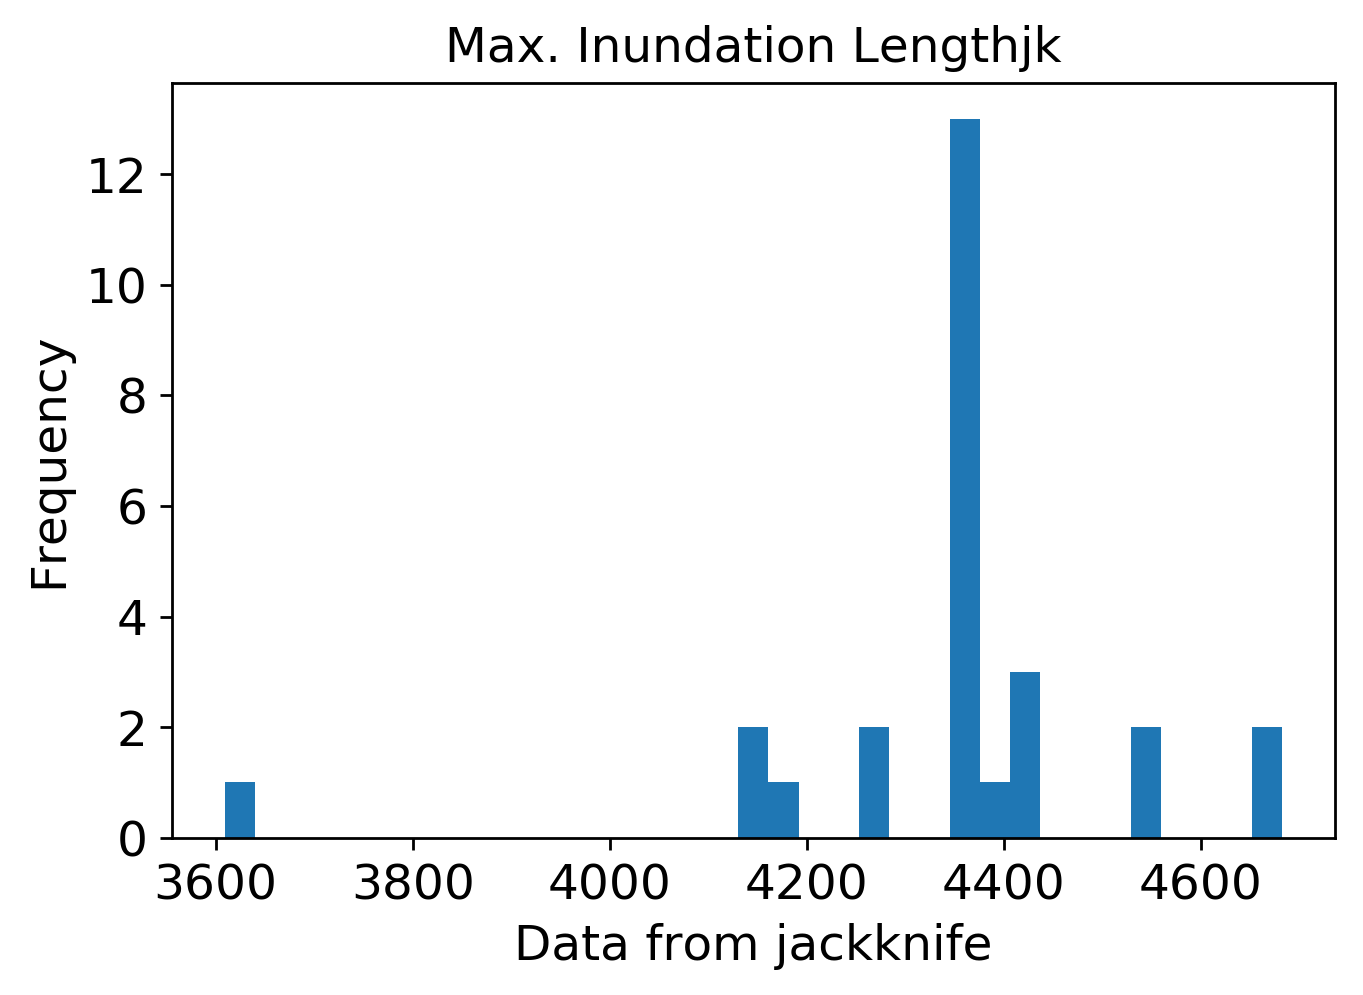

mean: 4.943927257469636
jk_e: 0.06993007568465352


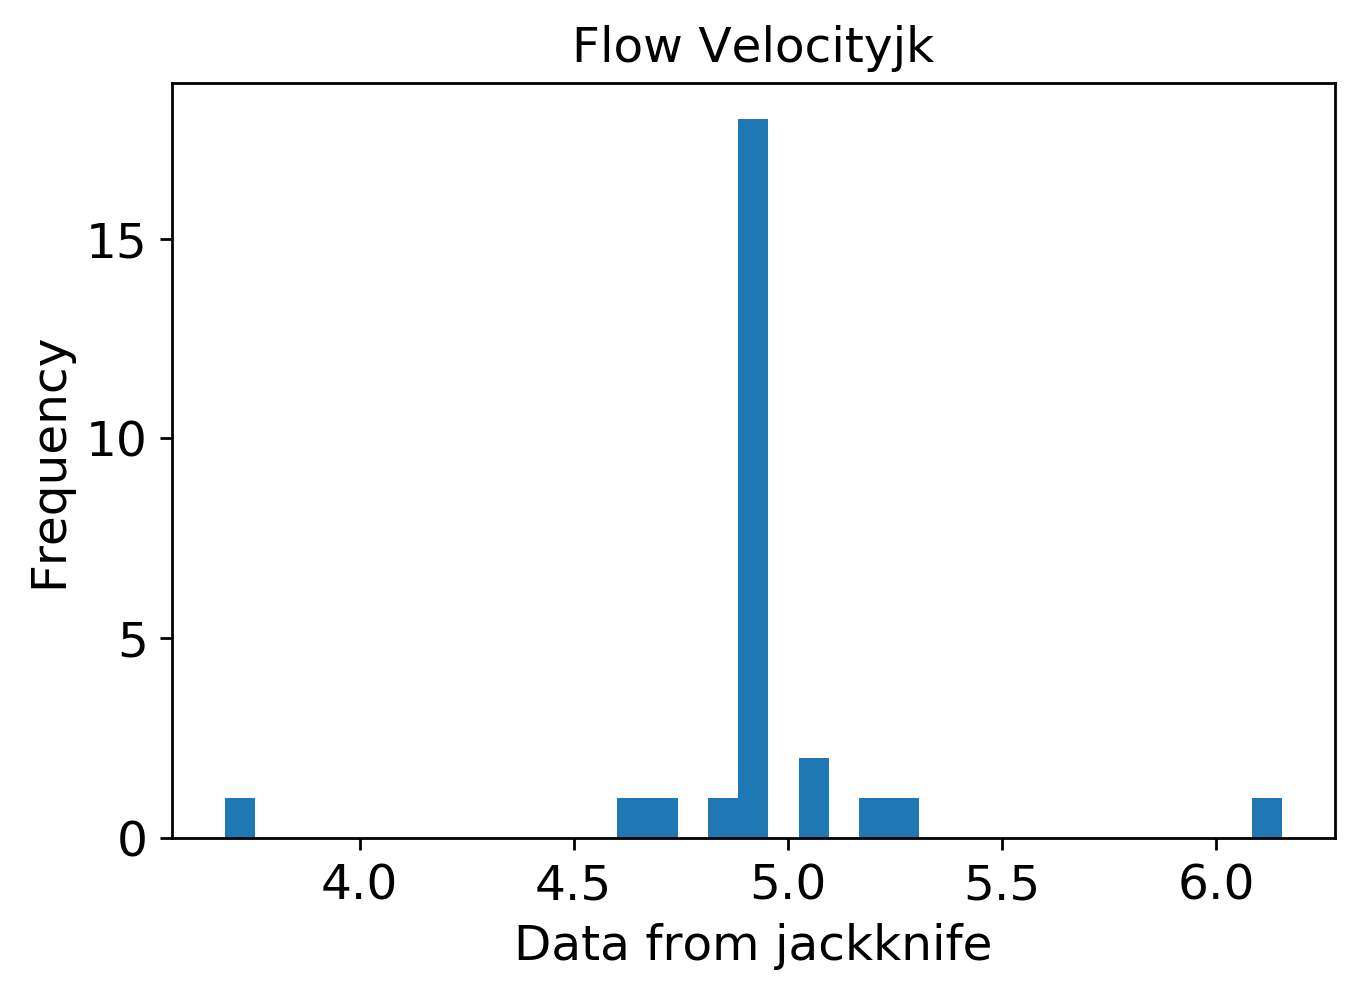

mean: 4.262535526286526
jk_e: 0.06051201298413426


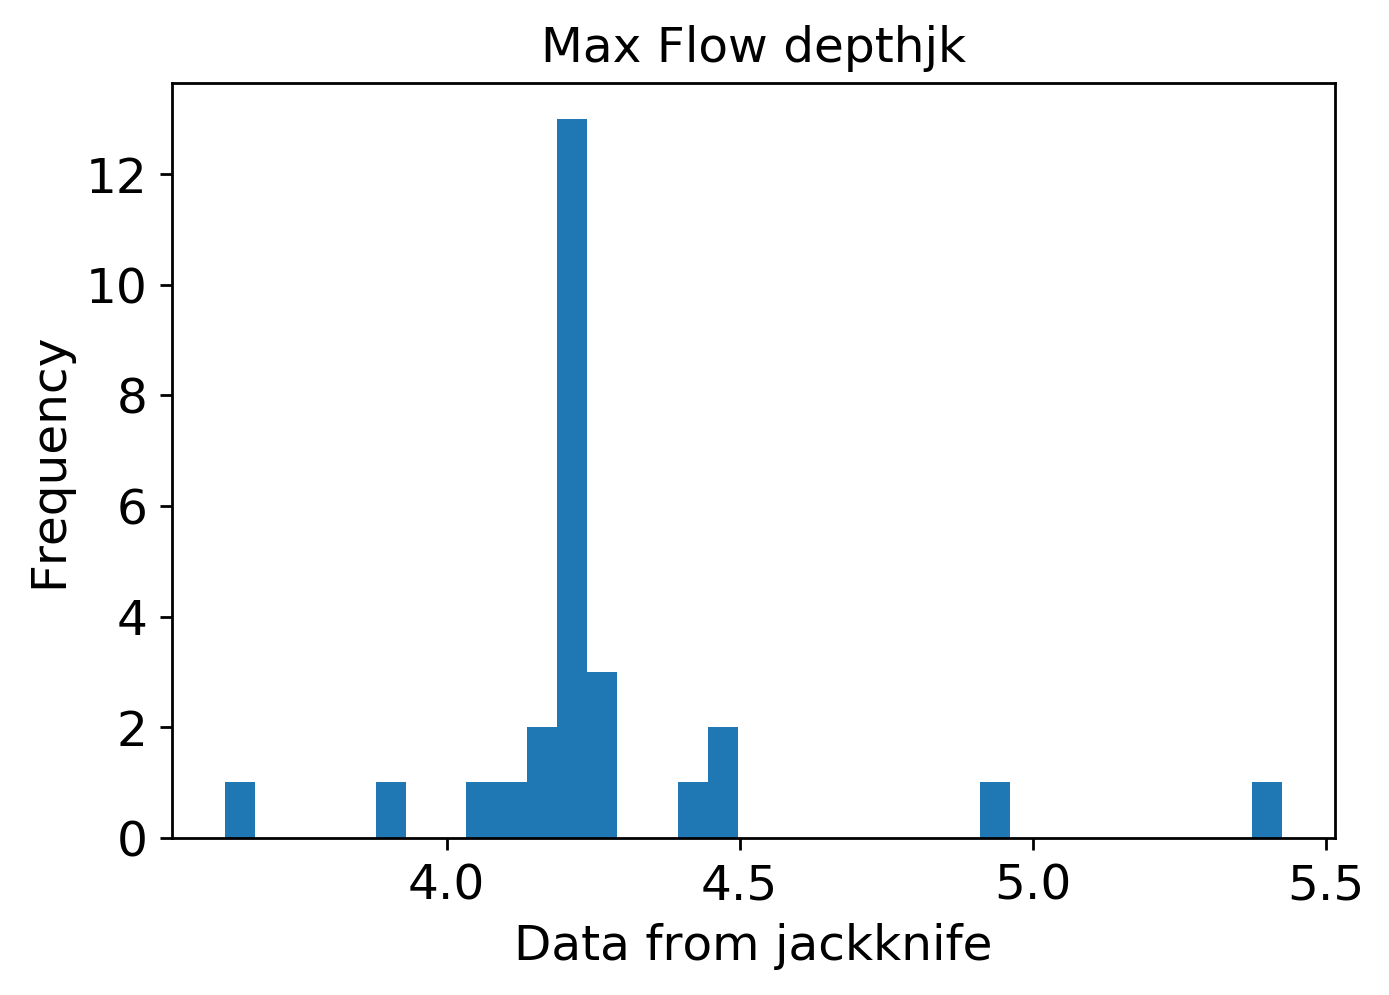

mean: 0.00461803377853364
jk_e: 0.00017101963506963323


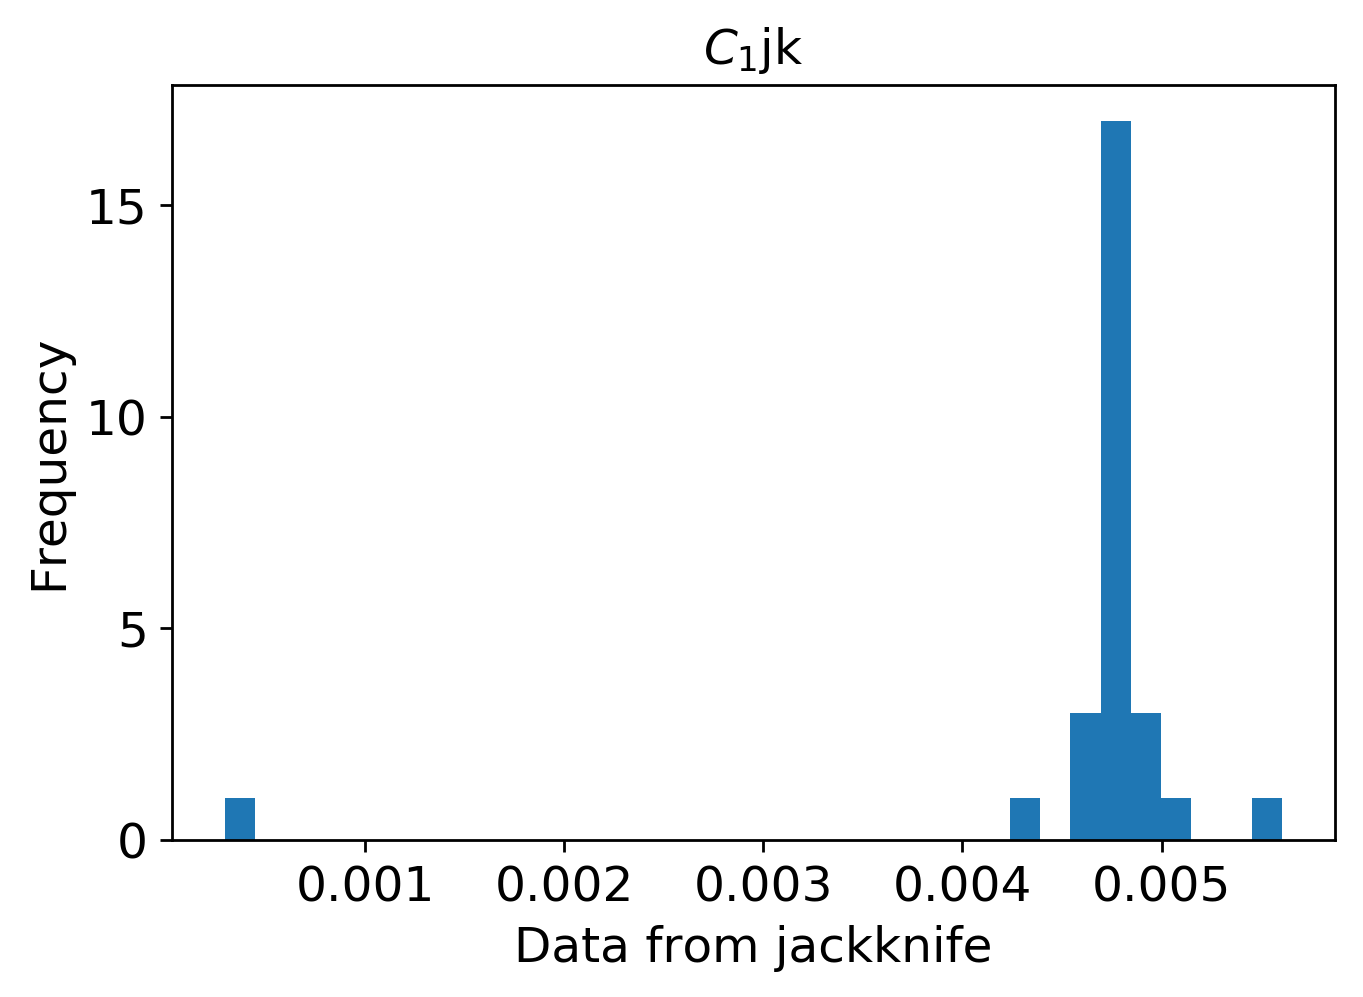

mean: 0.021530385303000894
jk_e: 0.00025675932845126213


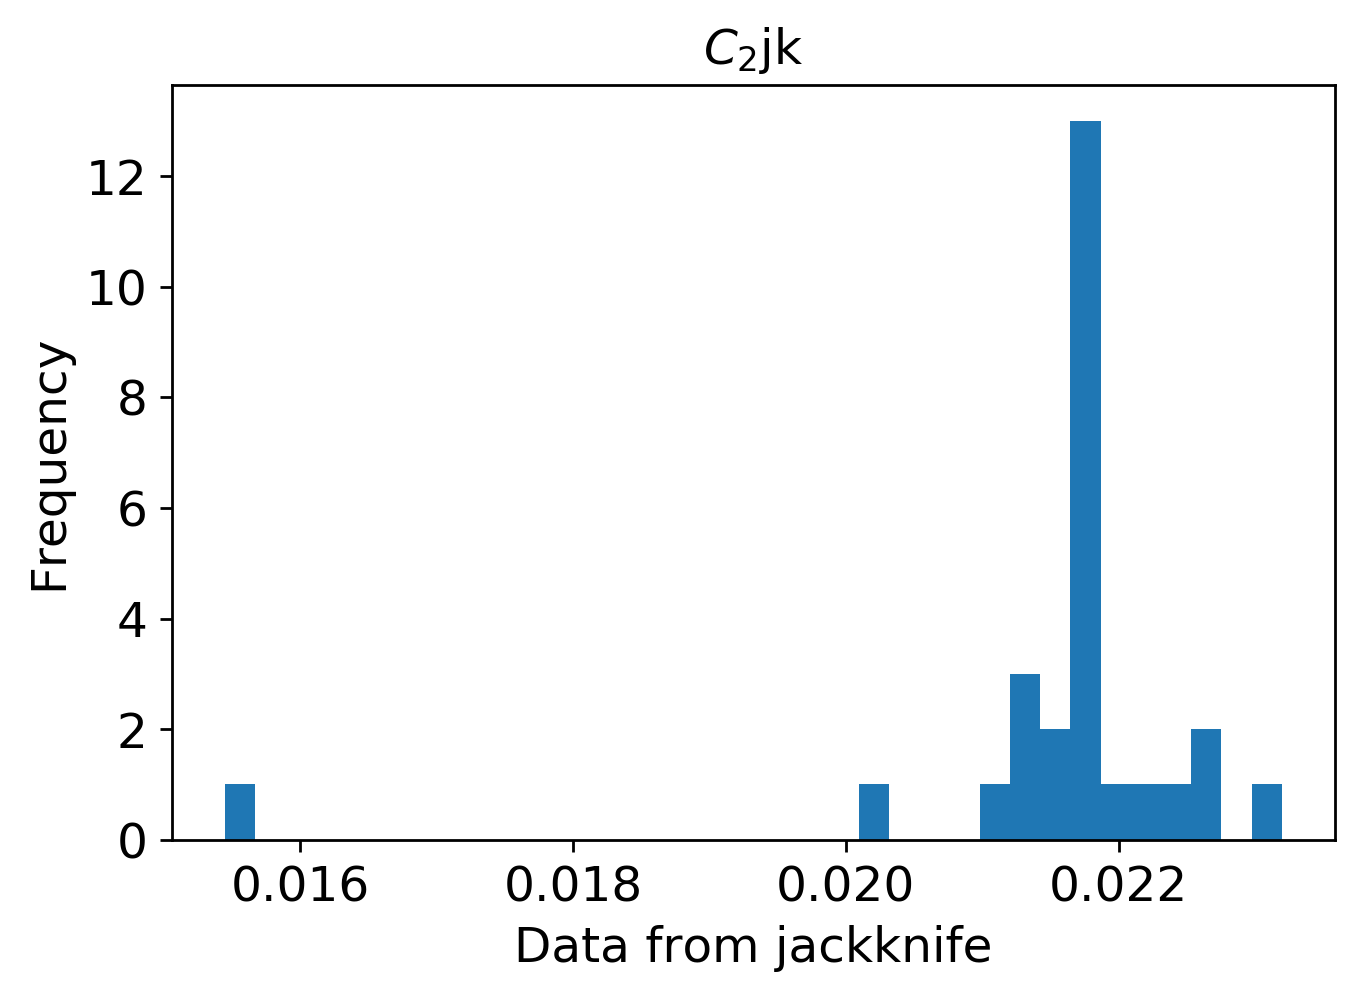

mean: 0.019387744749560593
jk_e: 0.0002612889760351535


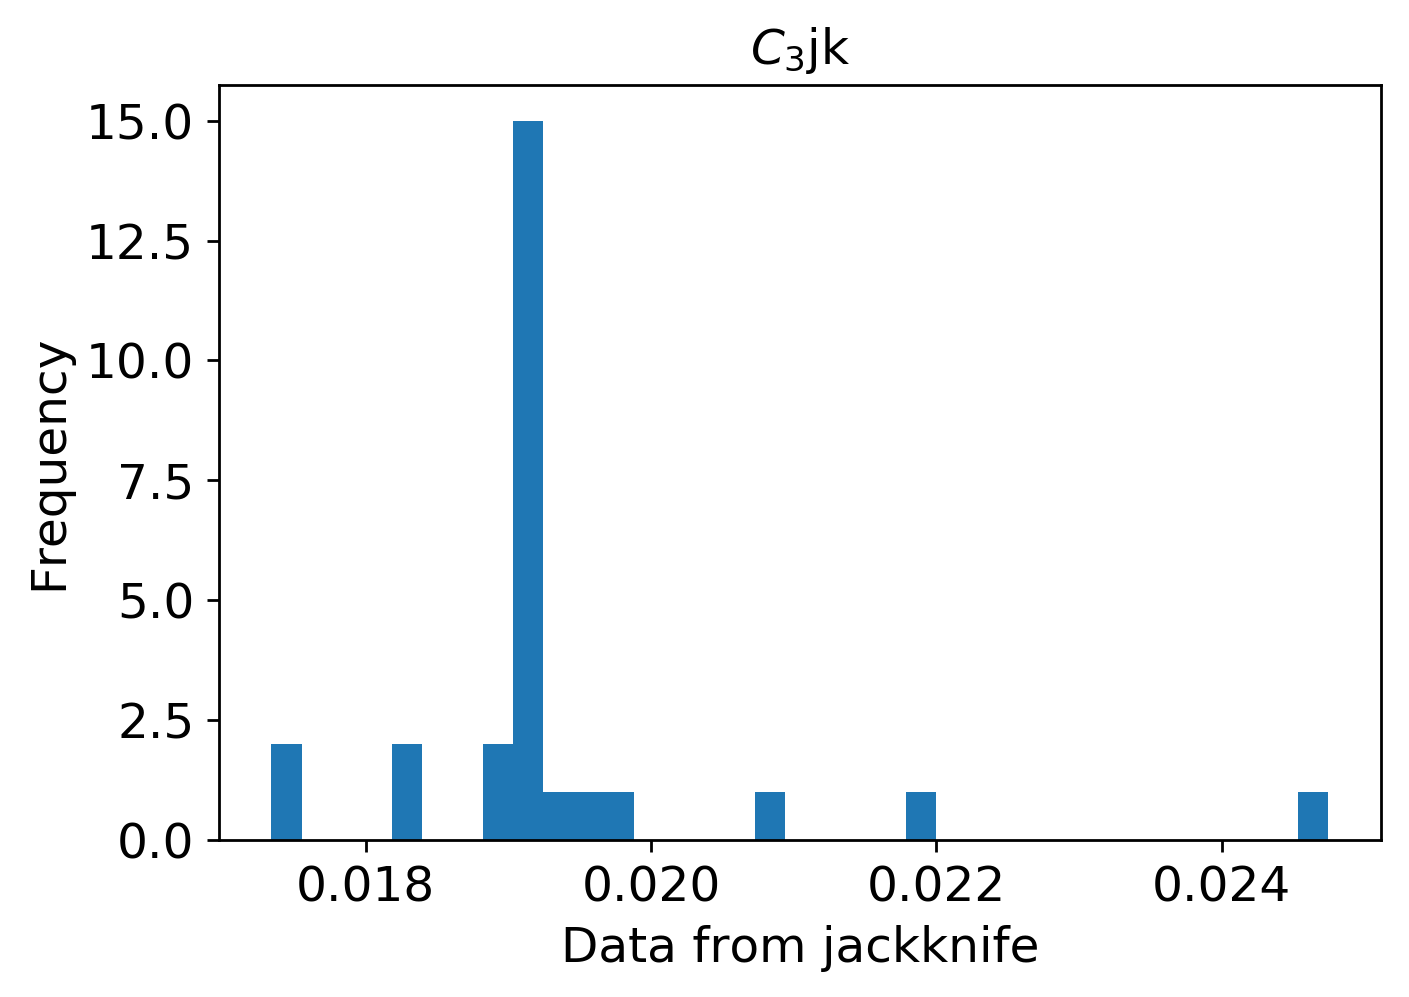

mean: 0.0022609382959225526
jk_e: 5.553714761550449e-05


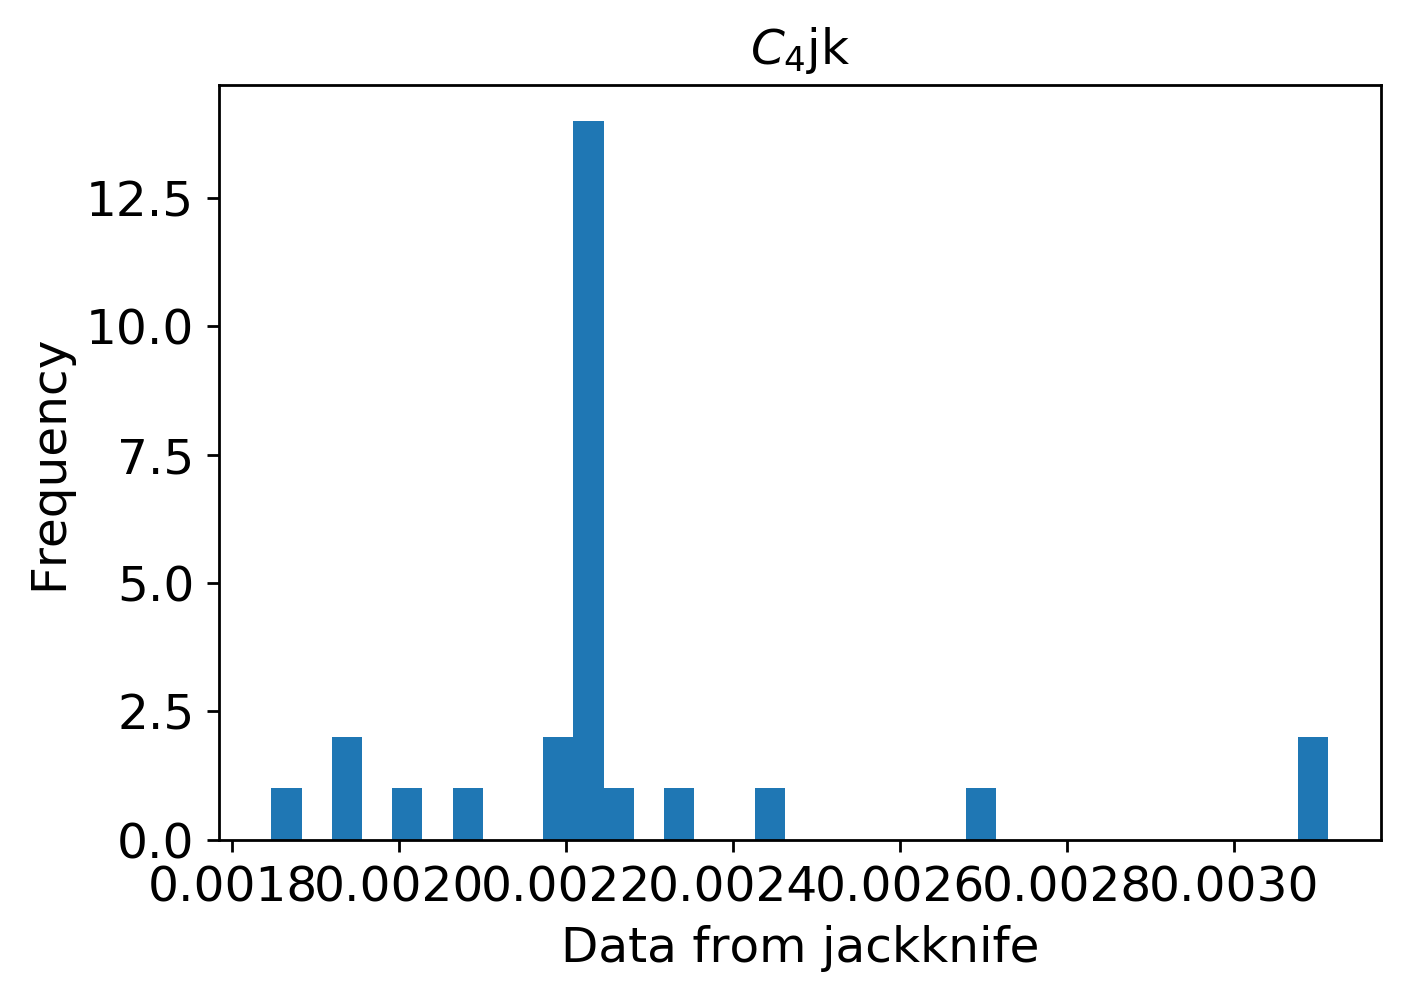

mean: 0.0019790460056134727
jk_e: 7.093881903740156e-05


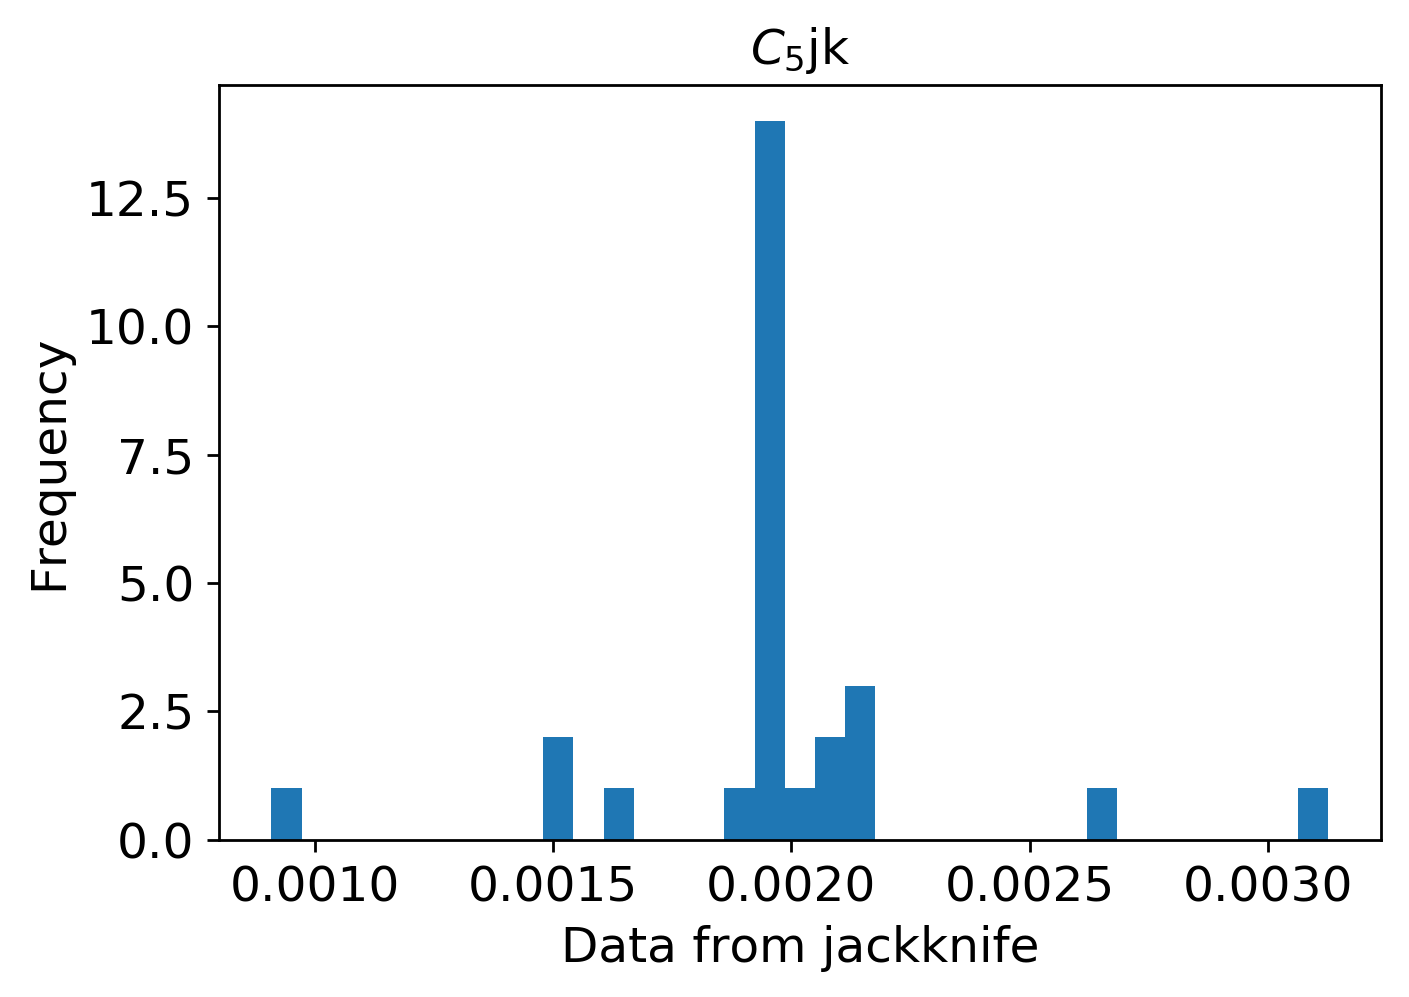

mean: 0.0007414321417211664
jk_e: 6.0746046055996545e-05


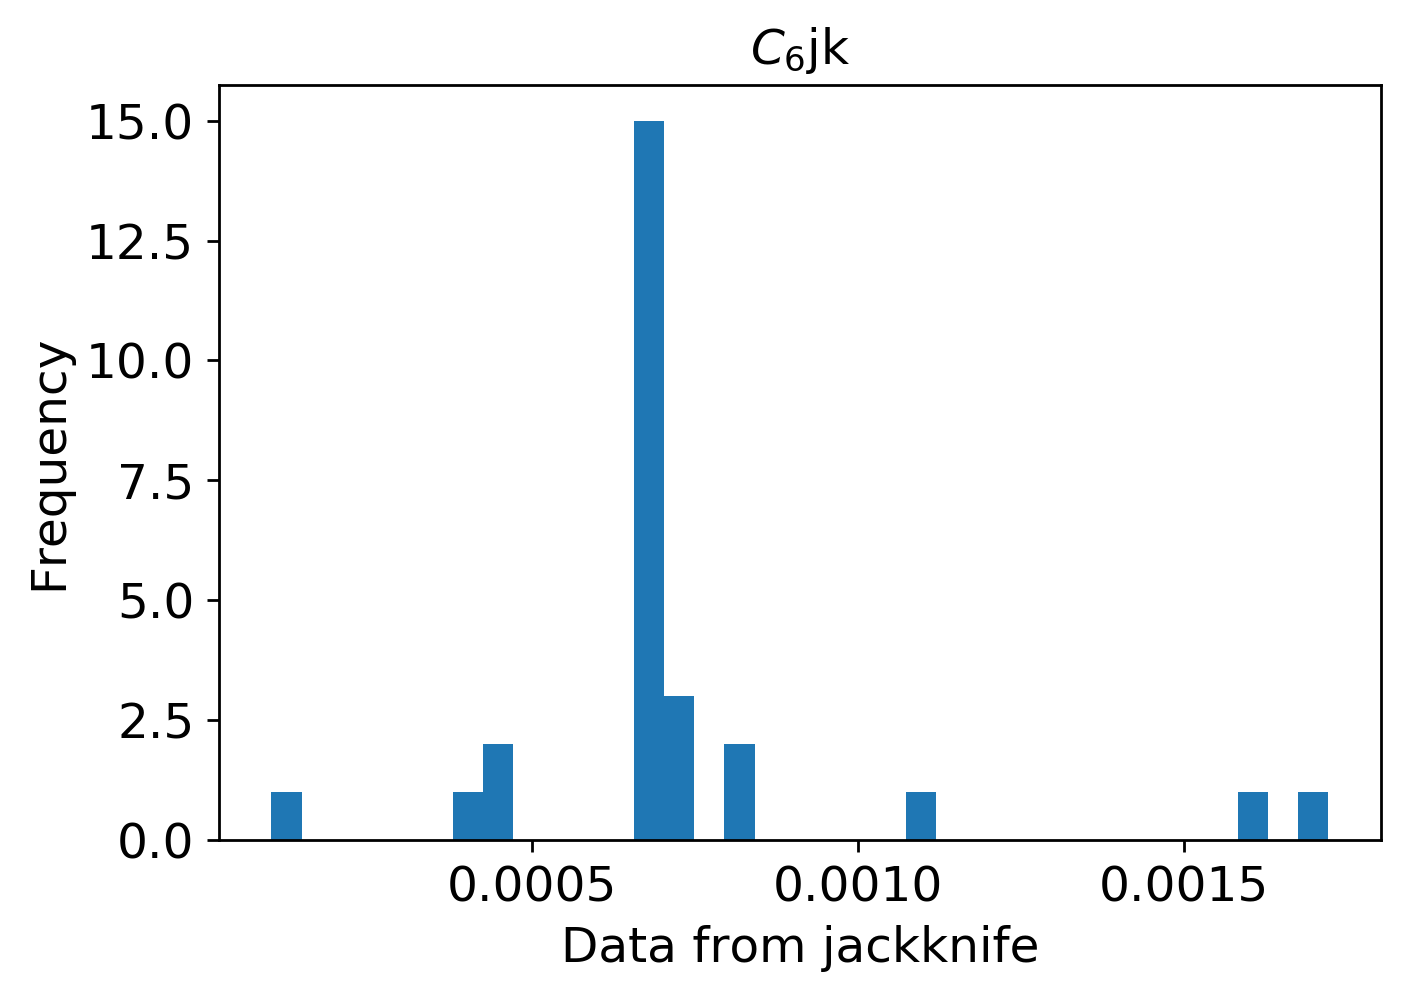

In [1]:
# Jackknife Method
import csv
import numpy as np
import pandas as pd
import math
from keras.models import load_model
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

datadir = '/home/rimali2009/FITTNUSS-forward_training_DNN/data_g6_300grid_H_5000_20_11_roi1500/'
resdir = '/home/rimali2009/FITTNUSS-forward_training_DNN/result_g6_300grid_H_5000_20_11_roi1500/4500/'
# Initial setting
if not "model" in locals():
    model = load_model(resdir+'model3.hdf5')
gclass = 6
gclass_label = ["615 ${\mu}m$", "406 ${\mu}m$", "268 ${\mu}m$",
                "177 ${\mu}m$", "117 ${\mu}m$", "77 ${\mu}m$"]
topodx = 15.0
coord_num = int(model.layers[0].input_shape[1]/gclass)
min_x, max_x = np.loadtxt(datadir + 'x_minmax.txt', delimiter=',')
y_min = np.loadtxt(datadir + 'icond_min.txt', delimiter=',')
y_max = np.loadtxt(datadir + 'icond_max.txt', delimiter=',')


a = pd.read_csv(
    '../FITTNUSS-forward_training_DNN/sendai_increased_class_edit.csv', delimiter=',')
print(a)
y = pd.DataFrame()
output = []

with open('output_final_20_11_roi1500.csv', 'w') as outfile:

    # x=[]
    for index in range(len(a)):
        df = y.append(pd.read_csv(
            '../FITTNUSS-forward_training_DNN/sendai_increased_class_edit.csv', skiprows=[index+1]))
        print(df)
        df = df.sort_values('distance')
        thick_interp = np.zeros([1, coord_num*gclass])
        x = np.arange(0, coord_num*topodx, topodx)
        for j in range(gclass):
            # Interpolation function of jth granularity level
            f = interp1d(df['distance'], df.iloc[:, j+1],
                         kind="linear", bounds_error=False,fill_value='extrapolate')
            thick_interp[0, coord_num*j:coord_num*(j+1)] = f(x)
        thick_interp[thick_interp < 0] = 0
        thick_interp_norm = (thick_interp - min_x) / (max_x - min_x)
        test_result_outcrop = model.predict(thick_interp_norm)
        test_result_outcrop = test_result_outcrop * (y_max - y_min) + y_min
        print(test_result_outcrop.shape)
        print(test_result_outcrop)
    # output.append(test_result_outcrop)
        np.savetxt(outfile,test_result_outcrop, delimiter=',')
        # outfile.write('# New iteration\n')
hfont = {'fontname': 'Century Gothic'}
textcol = 'k'
resi = np.loadtxt('output_final_20_11_roi1500.csv', delimiter=',')
titlelabel = ['Max. Inundation Lengthjk','Flow Velocityjk', 'Max Flow depthjk',
              '$C_1$jk', '$C_2$jk', '$C_3$jk', '$C_4$jk', '$C_5$jk', '$C_6$jk']
jk_er=[]
with open('jk_e_roi1500.txt','wb') as ftext:
    for i in range(len(titlelabel)):
        plt.figure(num=None, dpi=250, facecolor='w', edgecolor='k')
        plt.hist(resi[:, i], bins=35)
        mean = sum(resi[:,i]) / len(resi[:,i])
        print("mean:",mean)
        var_jk  = sum(pow(x-mean,2) for x in resi[:,i]) / ((len(resi[:,i])-1)*(len(resi[:,i])))
        jk_e= math.sqrt(var_jk)
        print("jk_e:",jk_e)
        e=np.append(jk_e,jk_er)
        np.savetxt(ftext,e,delimiter=',')
        plt.title(titlelabel[i], color=textcol, size=14, **hfont)
        plt.xlabel('Data from jackknife', color=textcol, size=14, **hfont)
        plt.ylabel('Frequency', color=textcol, size=14, **hfont)
        plt.tick_params(labelsize=14, colors=textcol)
        plt.savefig(resdir+titlelabel[i] + 'jkhist' + '.eps')
        plt.show()
